### Import libraries

In [1]:
from model import classic_model, losses, dot_prod_attention
from data import data_generation, batch_creator, gp_kernels, gp_priors
from keras.callbacks import ModelCheckpoint
from helpers import helpers, masks, metrics
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from inference import infer
import tensorflow as tf
import numpy as np
import matplotlib 
import time
import keras
plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
save_dir = '/Users/omernivron/Downloads/GPT'

In [3]:
pad_pos_tr, pad_pos_te, pad_y_fren_tr, pad_y_fren_te, _, df_te = data_generation.data_generator_for_gp_mimick_gpt(50000)

In [4]:
np.save('/Users/omernivron/Downloads/x_interpol', pad_pos_tr)
np.save('/Users/omernivron/Downloads/y_interpol', pad_y_fren_tr)

In [5]:
np.save('/Users/omernivron/Downloads/x_extra', pad_pos_te)
np.save('/Users/omernivron/Downloads/y_extra', pad_y_fren_te)

In [4]:
loss_object = tf.keras.losses.MeanSquaredError()
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')
m_tr = tf.keras.metrics.Mean()
m_te = tf.keras.metrics.Mean()

In [5]:
@tf.function
def train_step(decoder, optimizer_c, train_loss, m_tr, pos, tar, pos_mask):
    '''
    A typical train step function for TF2. Elements which we wish to track their gradient
    has to be inside the GradientTape() clause. see (1) https://www.tensorflow.org/guide/migrate 
    (2) https://www.tensorflow.org/tutorials/quickstart/advanced
    ------------------
    Parameters:
    pos (np array): array of positions (x values) - the 1st/2nd output from data_generator_for_gp_mimick_gpt
    tar (np array): array of targets. Notice that if dealing with sequnces, we typically want to have the targets go from 0 to n-1. The 3rd/4th output from data_generator_for_gp_mimick_gpt  
    pos_mask (np array): see description in position_mask function
    ------------------    
    '''
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    combined_mask_tar = masks.create_masks(tar_inp)
    with tf.GradientTape(persistent=True) as tape:
        pred, pred_log_sig = decoder(pos, tar_inp, True, pos_mask, combined_mask_tar)

        loss, mse, mask = losses.loss_function(tar_real, pred, pred_log_sig)

    gradients = tape.gradient(loss, decoder.trainable_variables)
    # Ask the optimizer to apply the processed gradients.
    optimizer_c.apply_gradients(zip(gradients, decoder.trainable_variables))
    train_loss(loss)
    m_tr.update_state(mse, mask)

In [6]:
@tf.function
def test_step(decoder, test_loss, m_te, pos_te, tar_te, pos_mask_te):
    '''
    
    ---------------
    Parameters:
    pos (np array): array of positions (x values) - the 1st/2nd output from data_generator_for_gp_mimick_gpt
    tar (np array): array of targets. Notice that if dealing with sequnces, we typically want to have the targets go from 0 to n-1. The 3rd/4th output from data_generator_for_gp_mimick_gpt  
    pos_mask_te (np array): see description in position_mask function
    ---------------
    
    '''
    tar_inp_te = tar_te[:, :-1]
    tar_real_te = tar_te[:, 1:]
    combined_mask_tar_te = masks.create_masks(tar_inp_te)
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
    pred, pred_log_sig = decoder(pos_te, tar_inp_te, False, pos_mask_te, combined_mask_tar_te)
    t_loss, t_mse, t_mask = losses.loss_function(tar_real_te, pred, pred_log_sig)
    test_loss(t_loss)
    m_te.update_state(t_mse, t_mask)

In [7]:
tf.keras.backend.set_floatx('float64')

In [8]:
if __name__ == '__main__':
    writer = tf.summary.create_file_writer(save_dir + '/logs/')
    optimizer_c = tf.keras.optimizers.Adam()
    decoder = classic_model.Decoder(16)
    EPOCHS = 10
    batch_s  = 128
    run = 0; step = 0
    num_batches = int(pad_y_fren_tr.shape[0] / batch_s)
    tf.random.set_seed(1)   
    ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer = optimizer_c, net = decoder)
    main_folder = "/Users/omernivron/Downloads/GPT/ckpt/check_"
    folder = main_folder + str(run); helpers.mkdir(folder)
    manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=3)
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")
    
    with writer.as_default():
        for epoch in range(EPOCHS):
            start = time.time()

            for batch_n in range(num_batches):
                m_tr.reset_states(); train_loss.reset_states()
                m_te.reset_states(); test_loss.reset_states()
                batch_pos_tr, batch_tar_tr, _ = batch_creator.create_batch_gp_mim_2(pad_pos_tr, pad_y_fren_tr)
                # batch_tar_tr shape := 128 X 59 = (batch_size, max_seq_len)
                # batch_pos_tr shape := 128 X 59 = (batch_size, max_seq_len)
                batch_pos_mask = masks.position_mask(batch_pos_tr)
                train_step(decoder, optimizer_c, train_loss, m_tr, batch_pos_tr, batch_tar_tr, batch_pos_mask)

                if batch_n % 50 == 0:
                    batch_pos_te, batch_tar_te, _ = batch_creator.create_batch_gp_mim_2(pad_pos_te, pad_y_fren_te)
                    batch_pos_mask_te = masks.position_mask(batch_pos_te)
                    test_step(decoder, test_loss, m_te, batch_pos_te, batch_tar_te, batch_pos_mask_te)
                    helpers.print_progress(epoch, batch_n, train_loss.result(), test_loss.result(), m_tr.result())
                    helpers.tf_summaries(run, step, train_loss.result(), test_loss.result(), m_tr.result(), m_te.result())
                    manager.save()
                step += 1
                ckpt.step.assign_add(1)

            print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Already exists
Restored from /Users/omernivron/Downloads/GPT/ckpt/check_0/ckpt-106
Epoch 0 batch 0 train Loss -1.6890 test Loss -2.0139 with MSE metric 0.0067


KeyboardInterrupt: 

In [46]:
extrapo = True

In [48]:
if extrapo:
    x = np.load('/Users/omernivron/Downloads/x_te_extrapo.npy')
    y = np.load('/Users/omernivron/Downloads/y_te_extrapo.npy')
else:
    x = np.load('/Users/omernivron/Downloads/x_tr_interpo.npy')
    y = np.load('/Users/omernivron/Downloads/y_tr_interpo.npy')

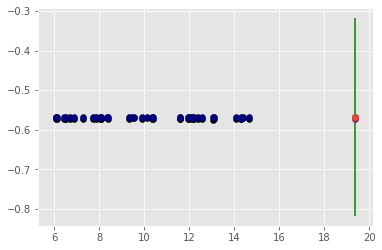

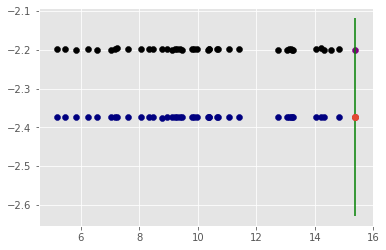

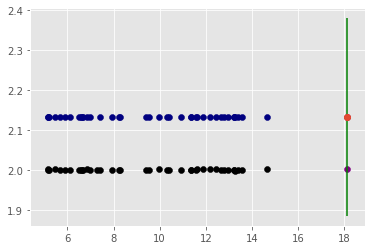

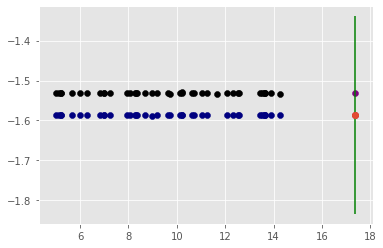

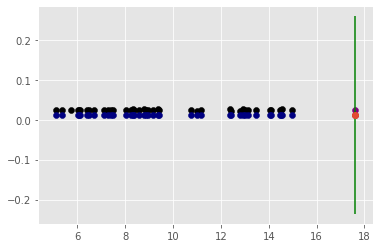

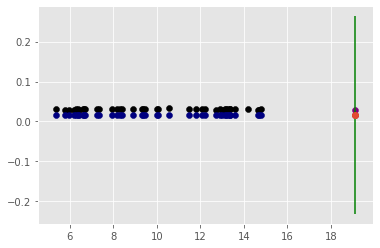

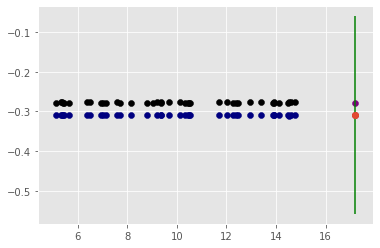

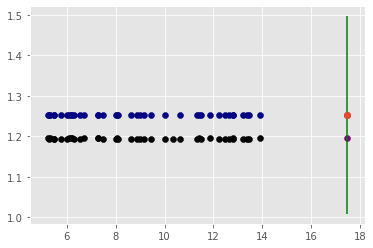

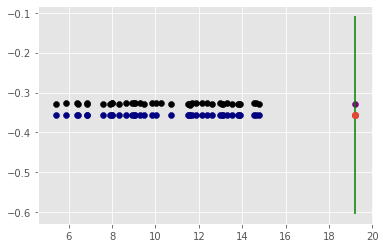

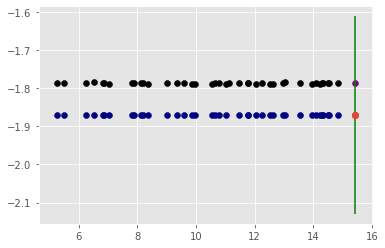

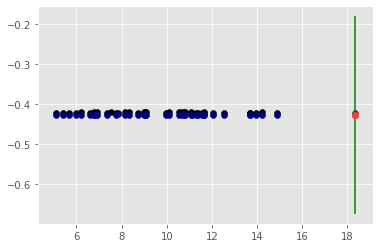

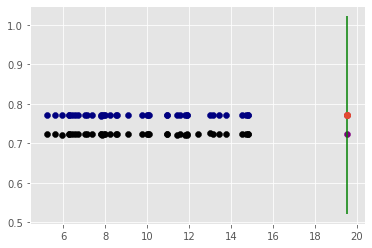

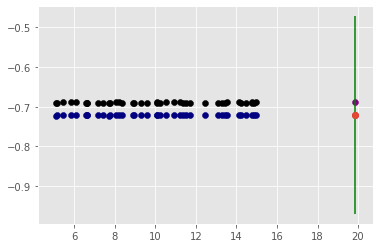

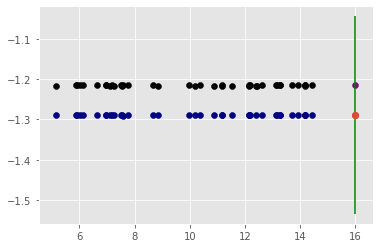

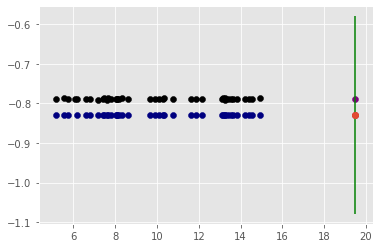

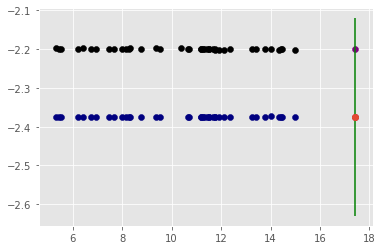

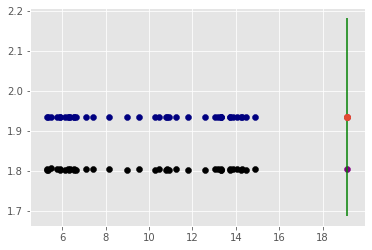

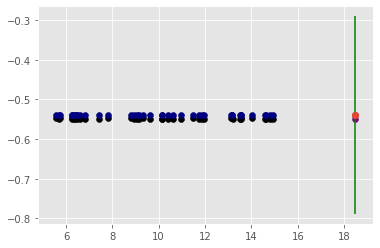

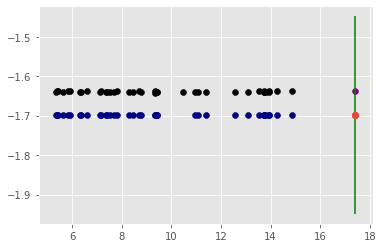

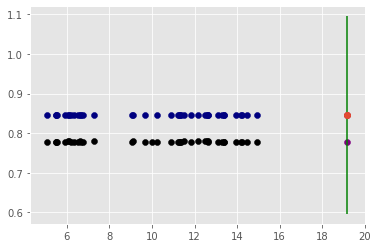

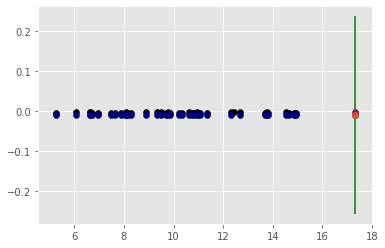

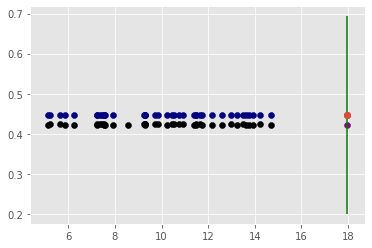

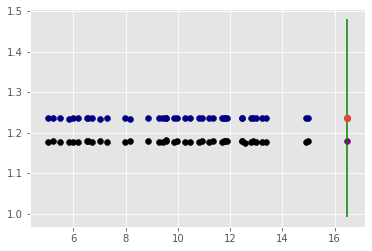

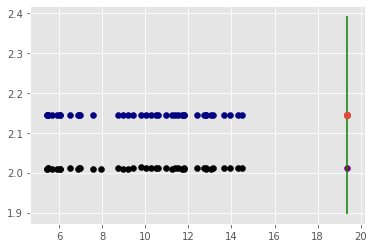

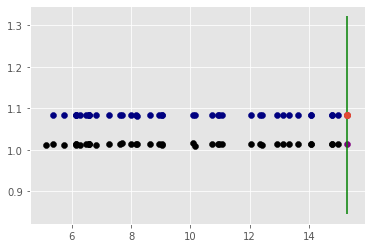

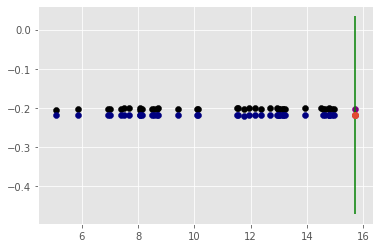

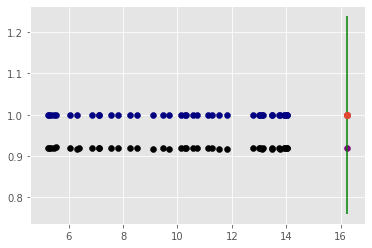

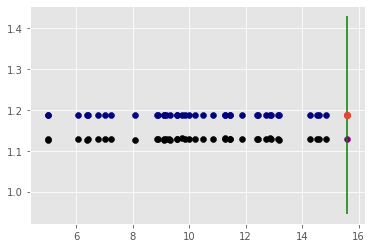

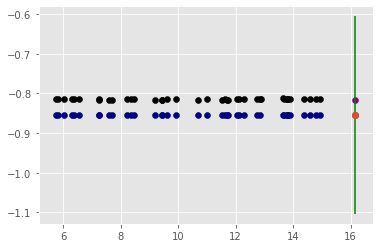

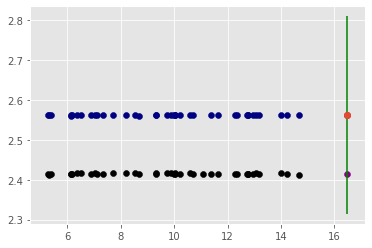

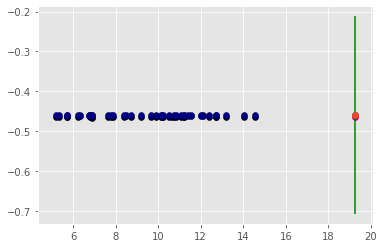

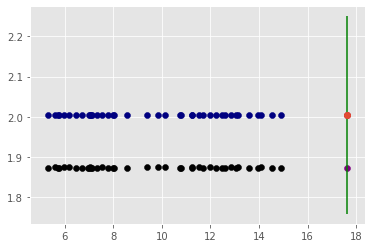

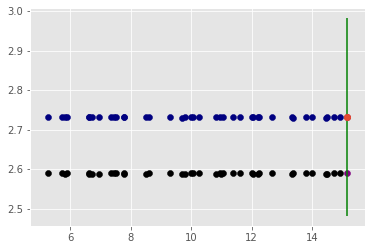

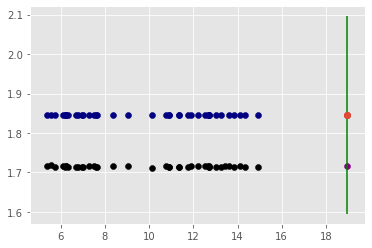

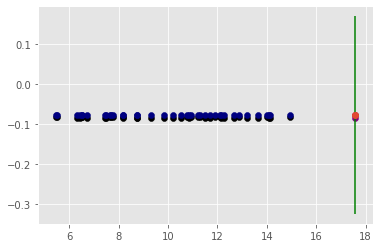

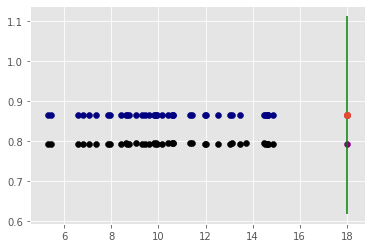

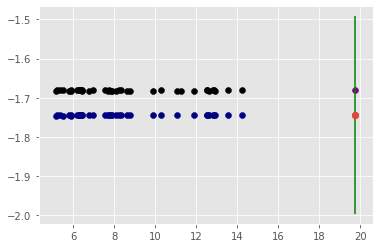

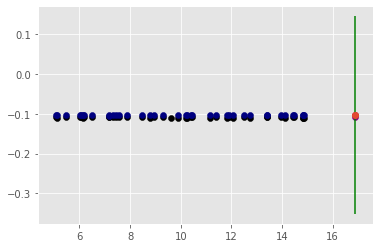

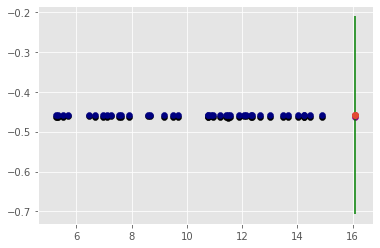

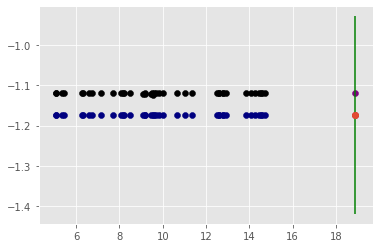

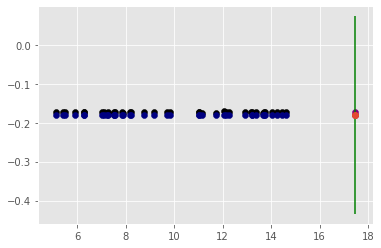

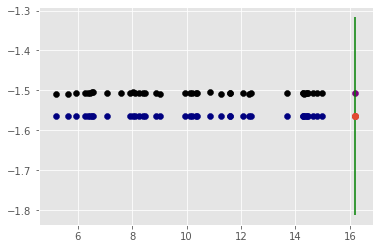

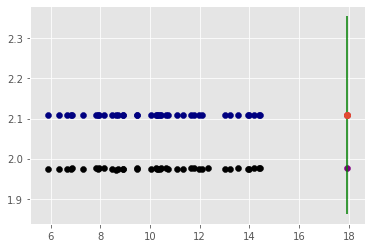

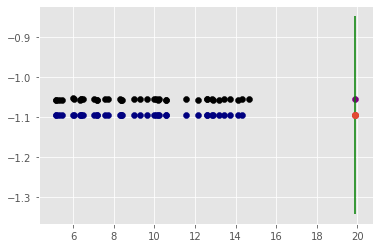

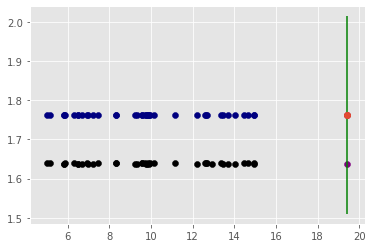

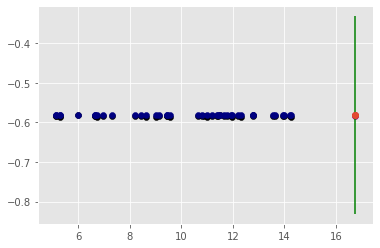

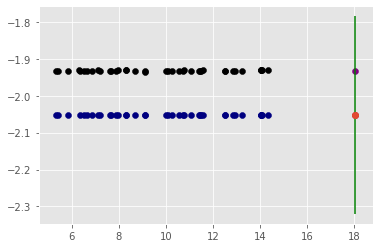

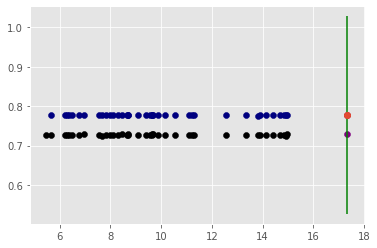

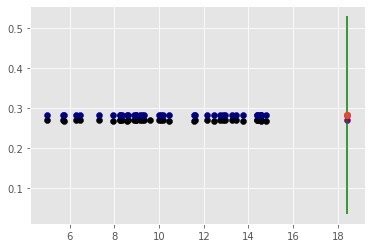

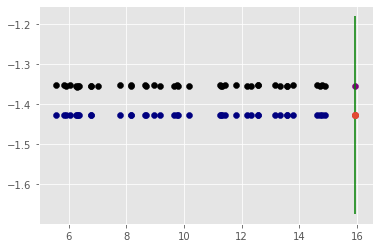

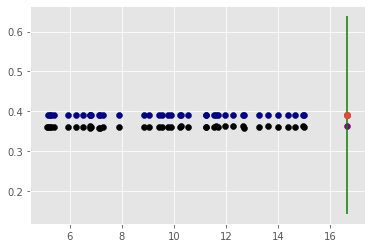

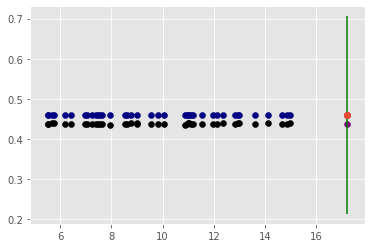

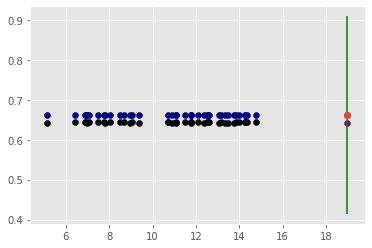

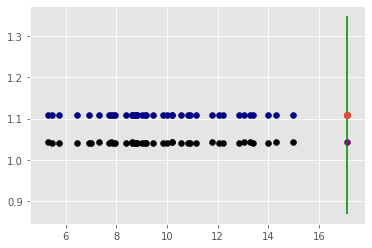

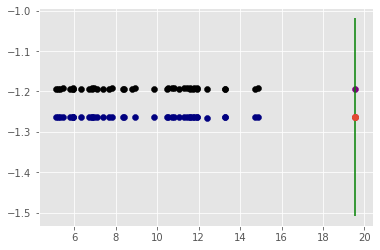

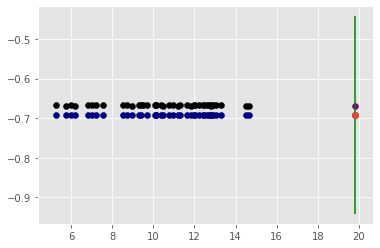

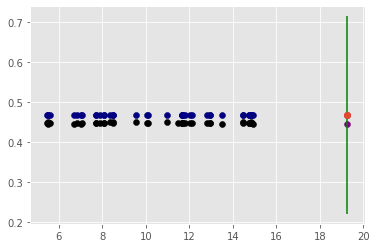

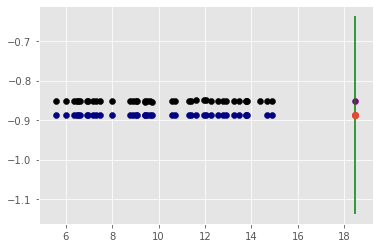

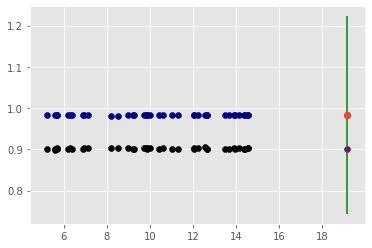

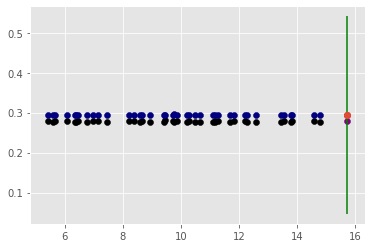

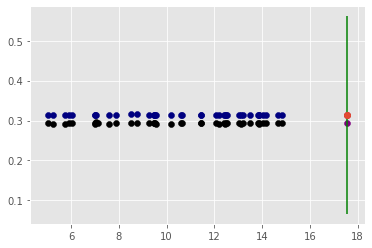

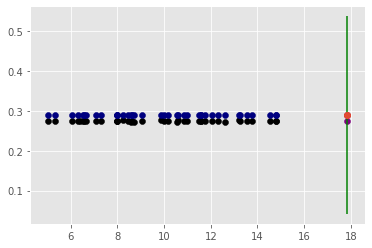

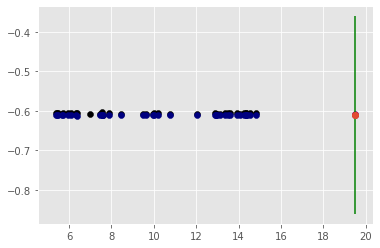

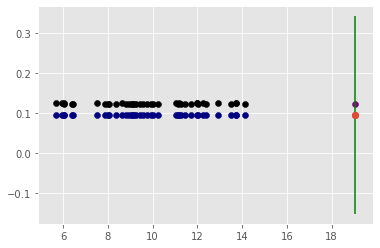

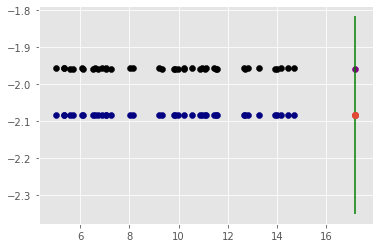

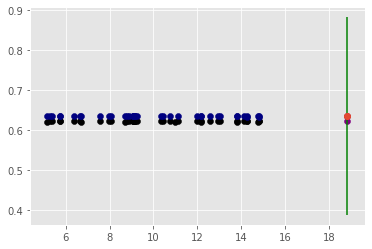

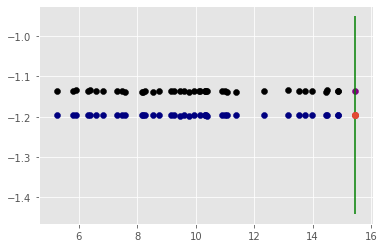

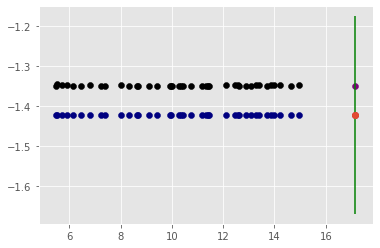

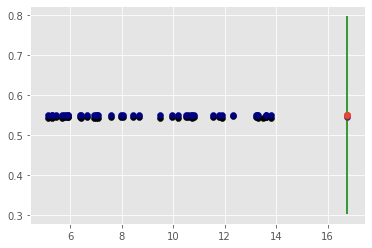

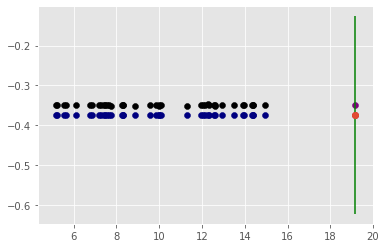

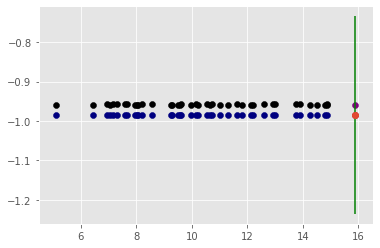

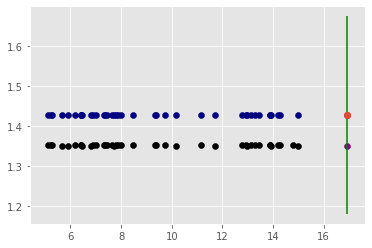

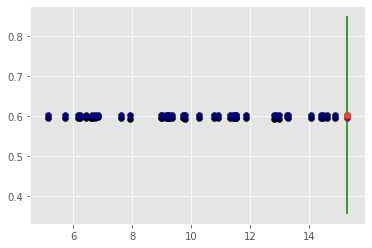

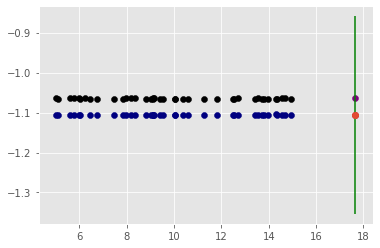

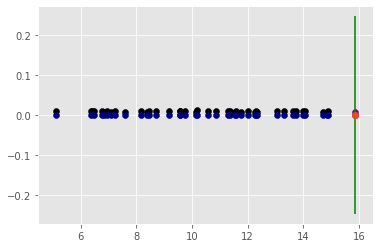

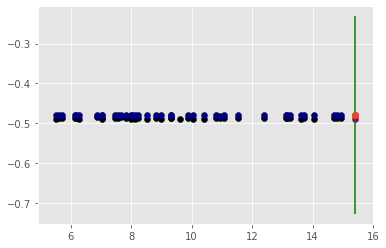

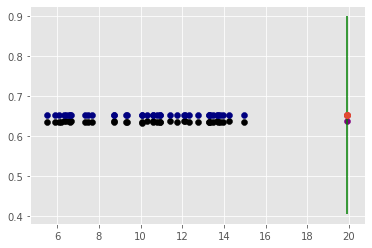

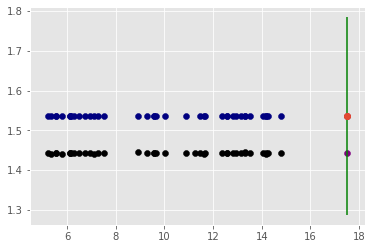

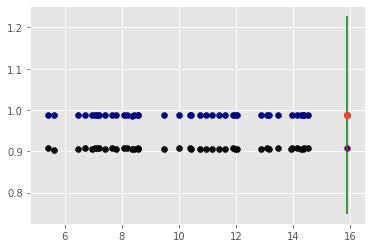

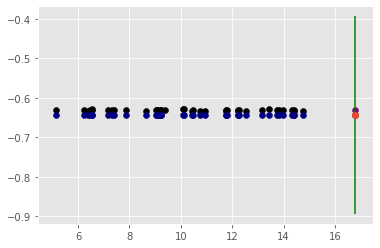

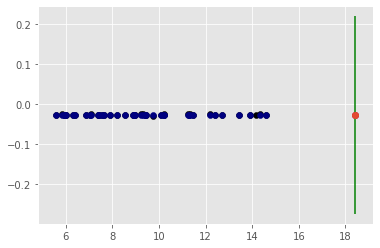

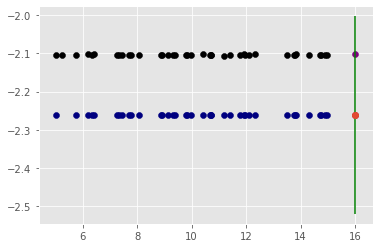

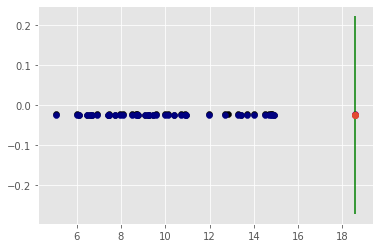

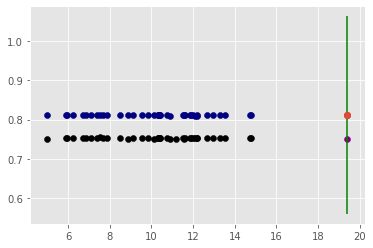

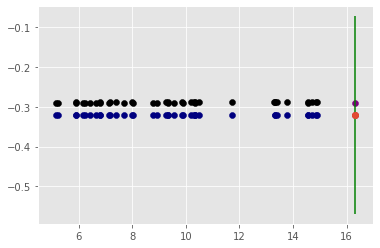

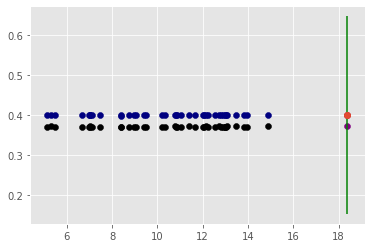

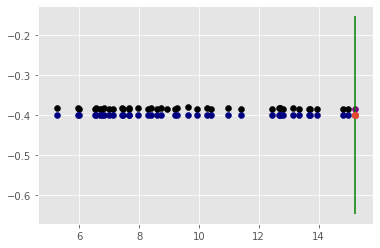

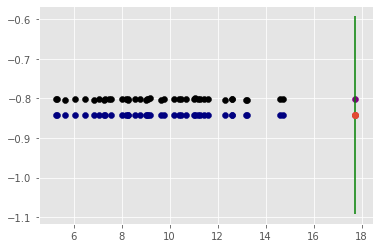

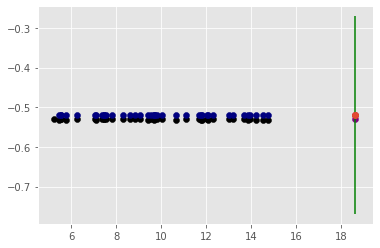

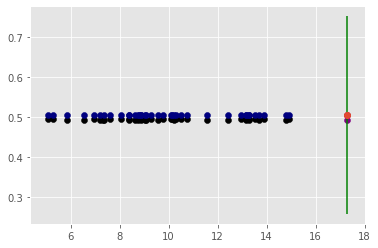

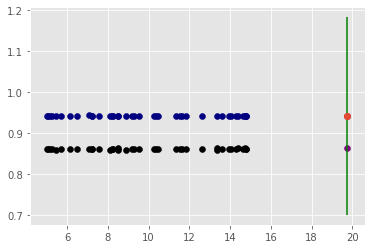

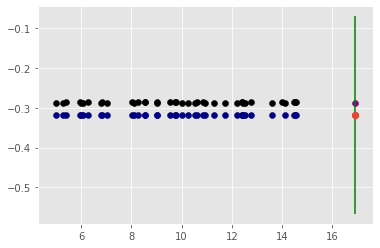

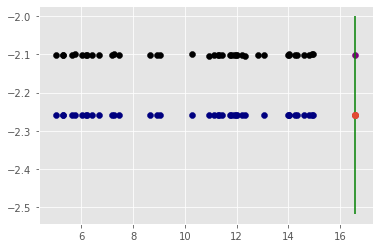

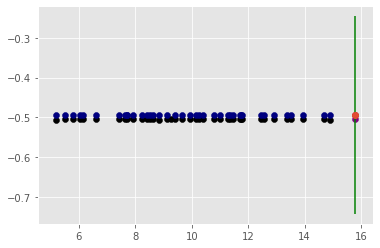

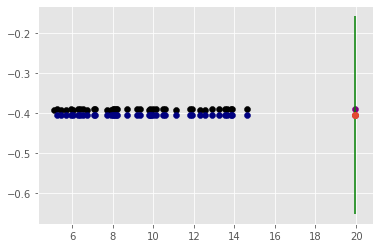

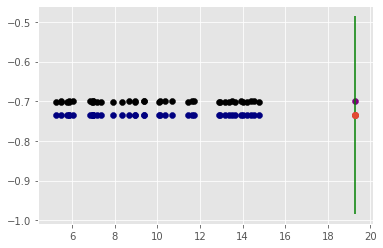

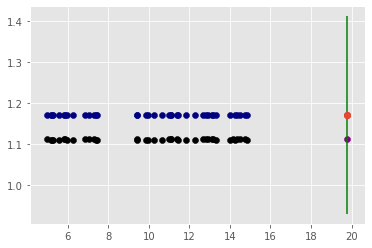

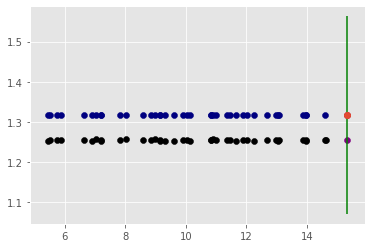

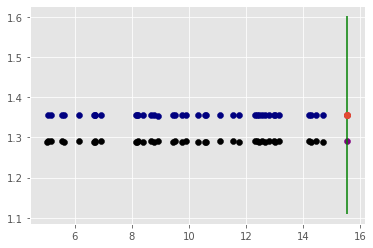

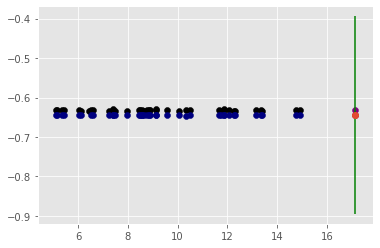

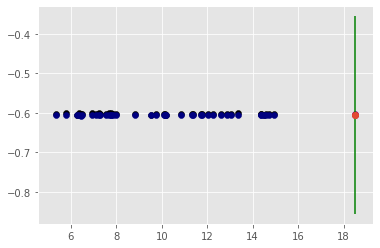

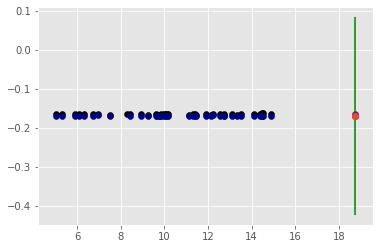

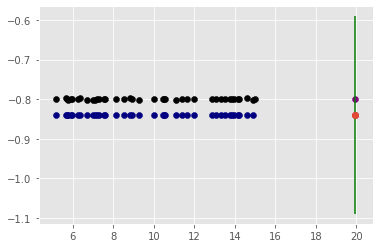

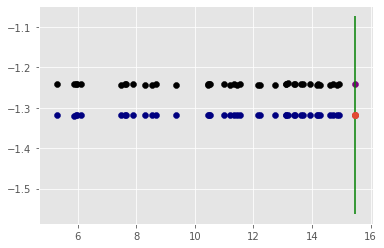

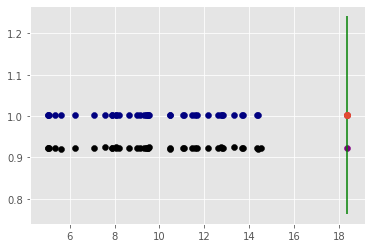

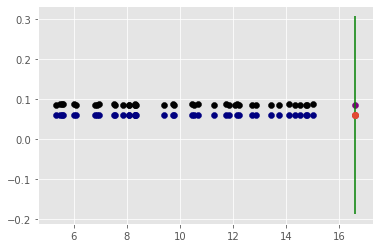

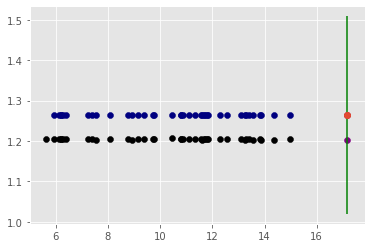

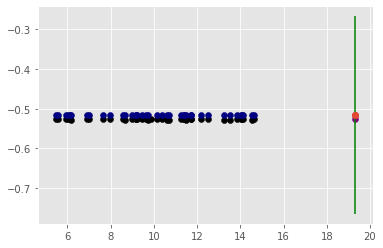

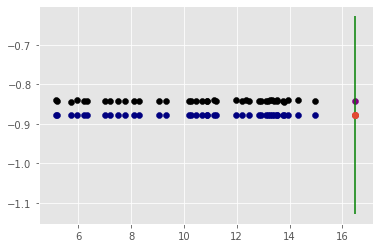

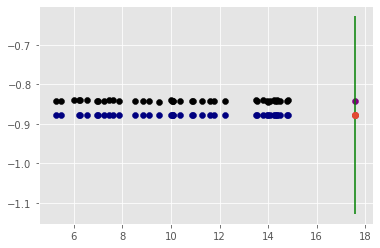

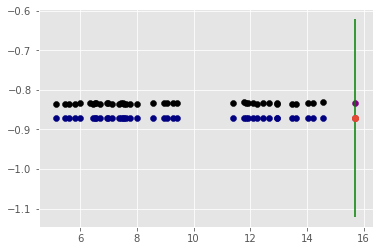

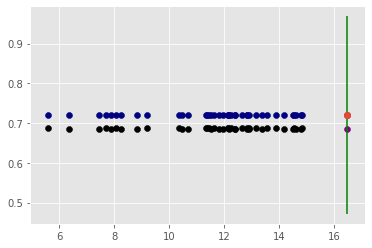

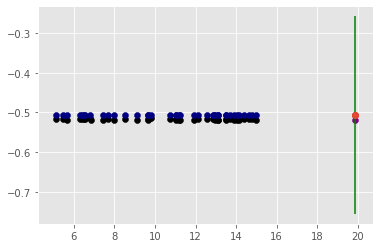

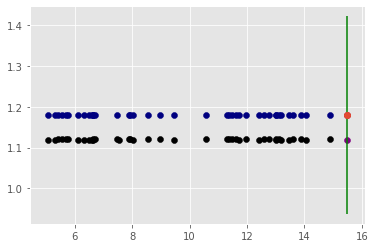

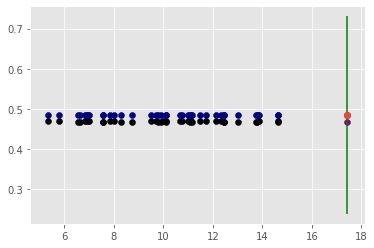

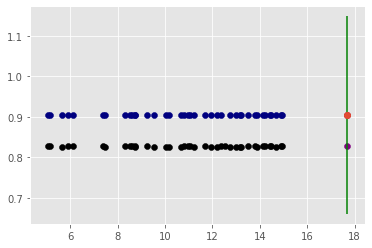

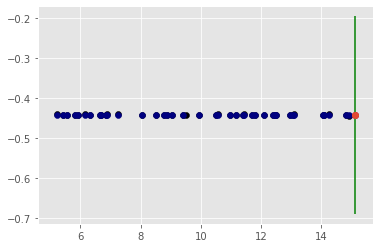

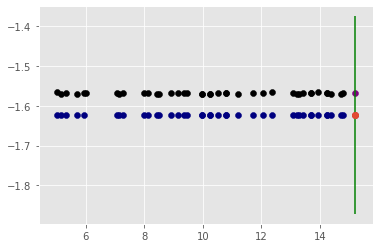

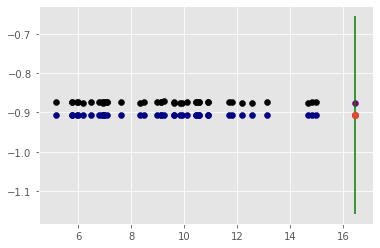

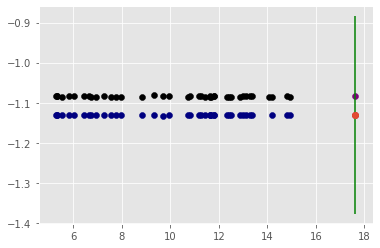

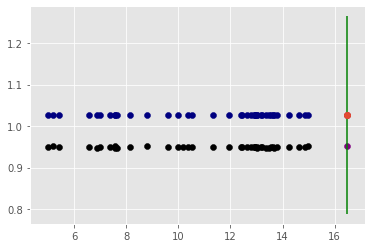

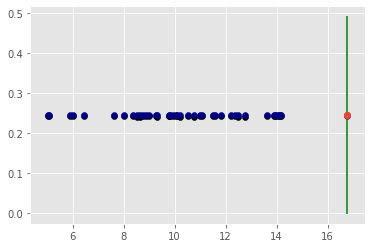

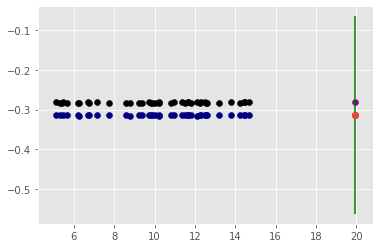

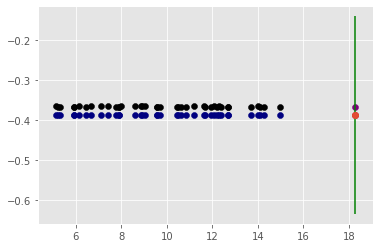

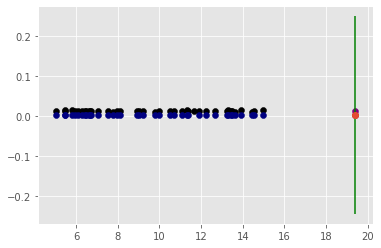

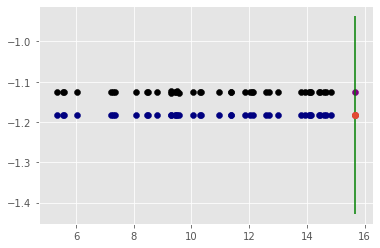

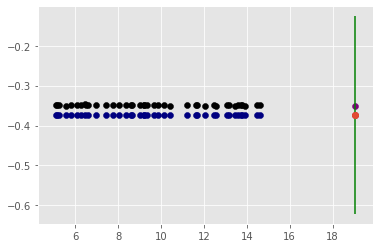

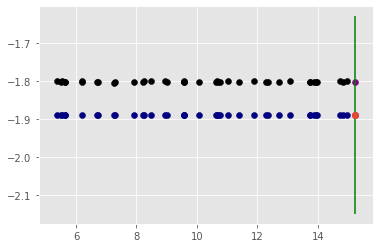

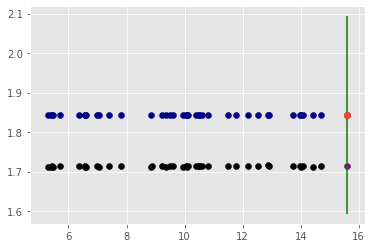

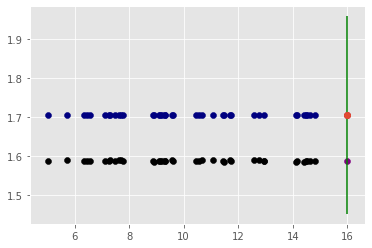

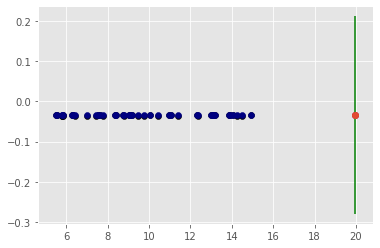

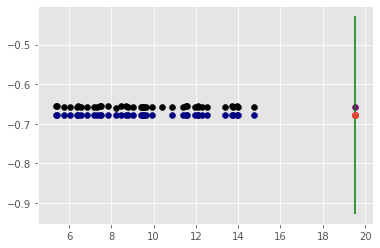

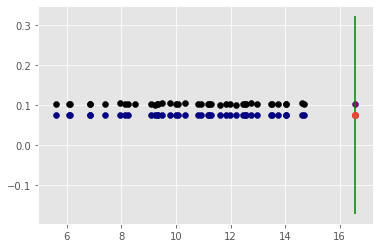

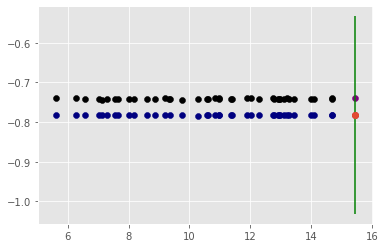

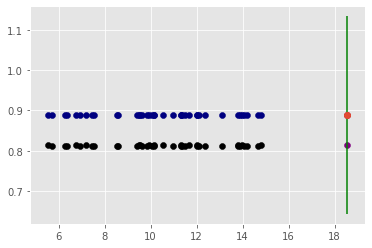

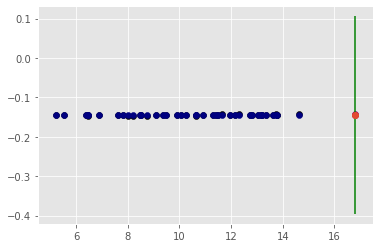

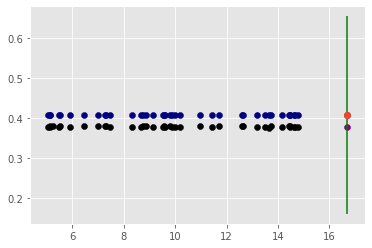

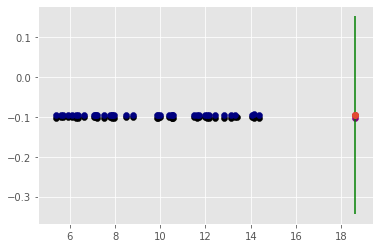

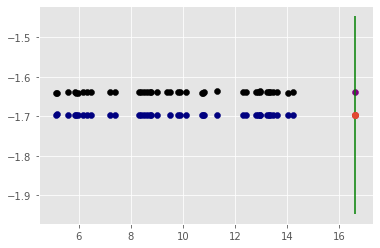

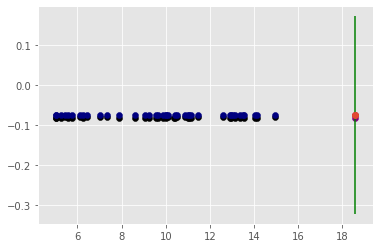

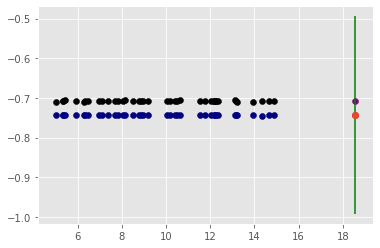

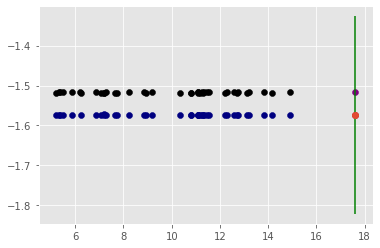

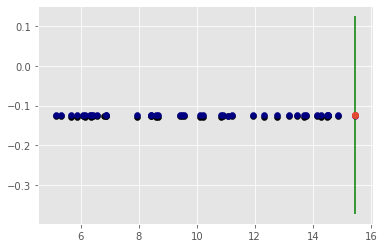

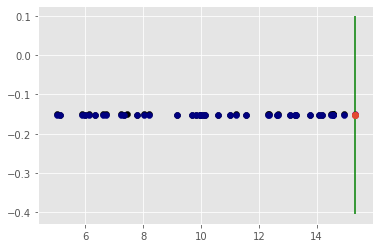

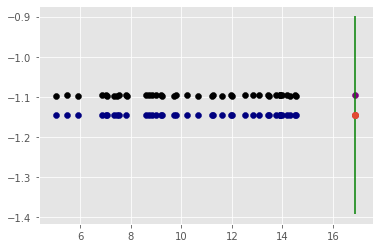

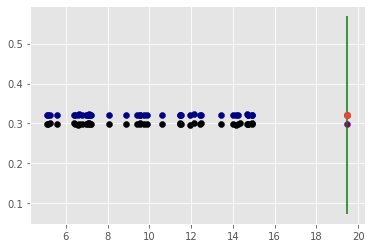

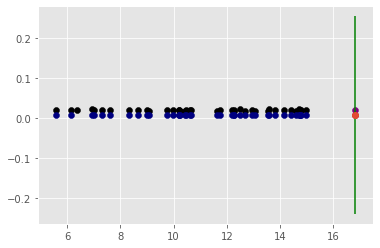

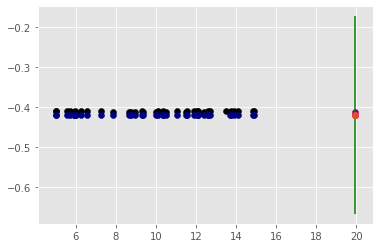

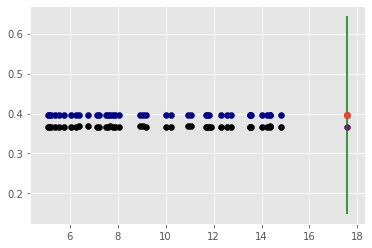

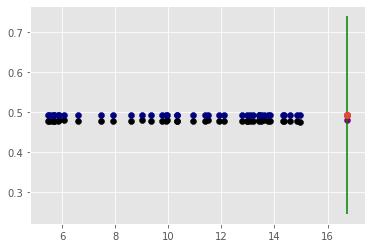

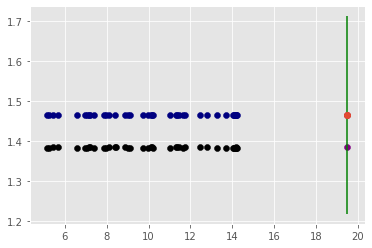

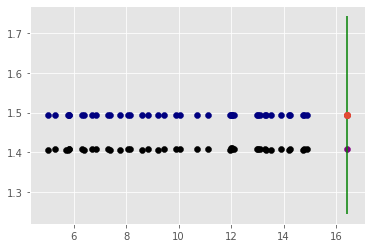

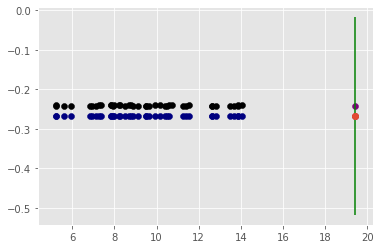

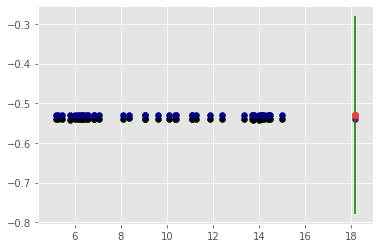

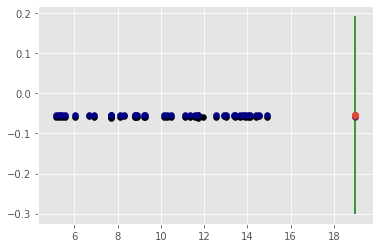

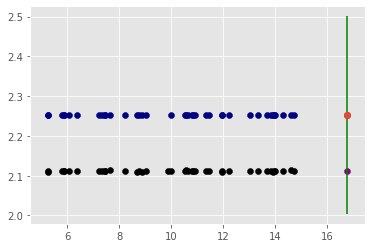

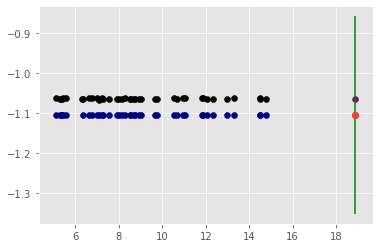

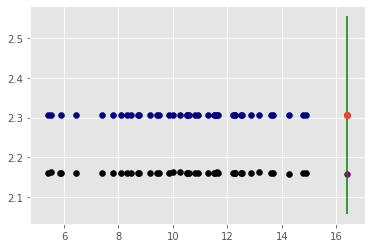

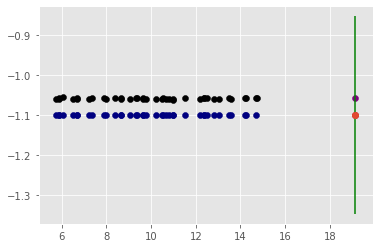

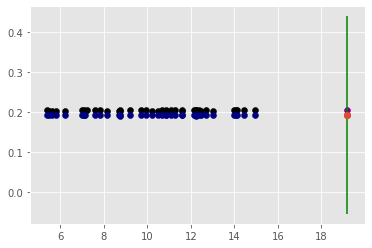

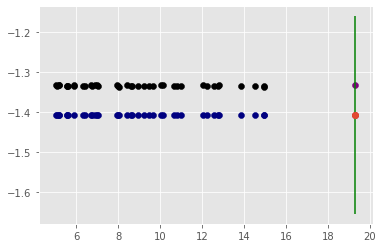

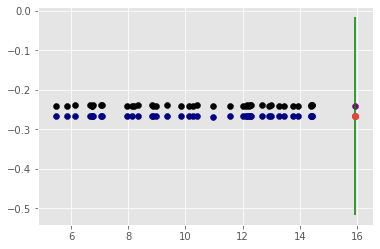

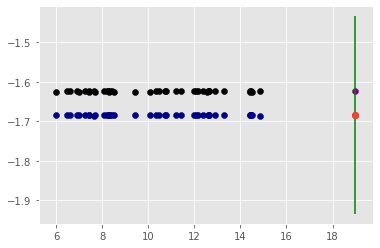

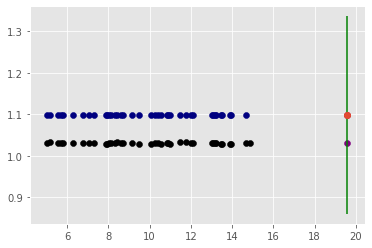

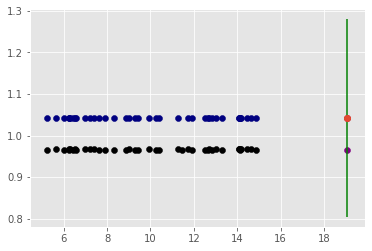

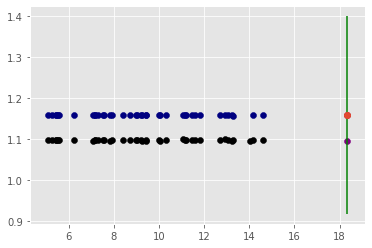

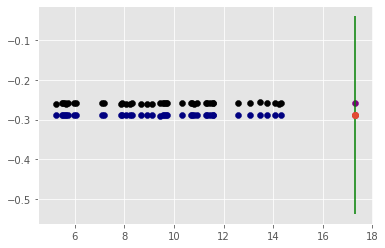

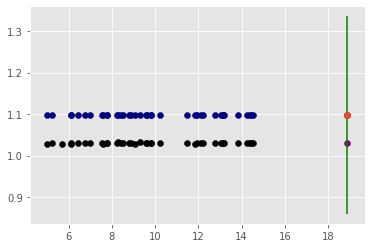

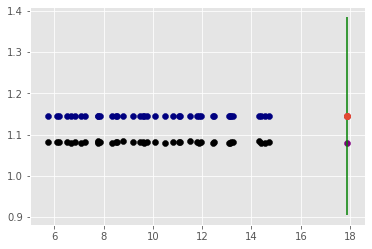

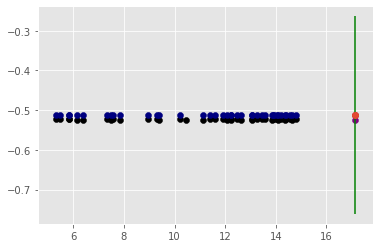

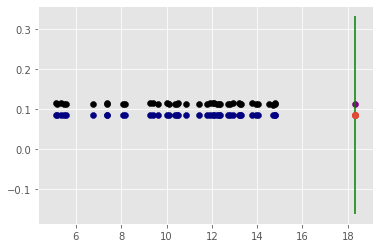

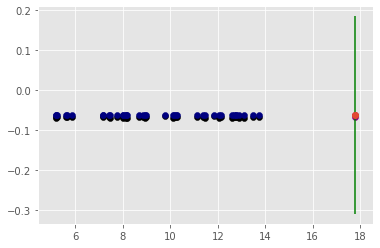

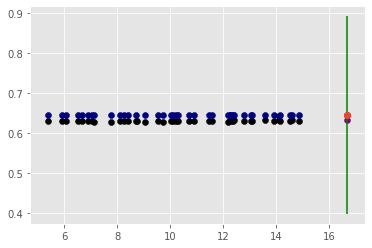

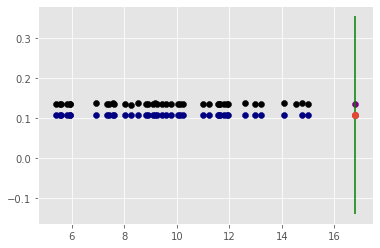

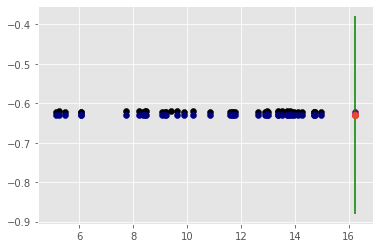

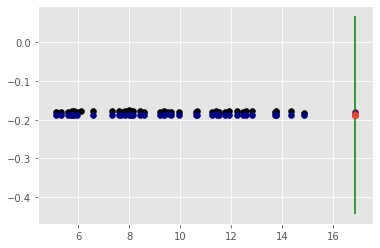

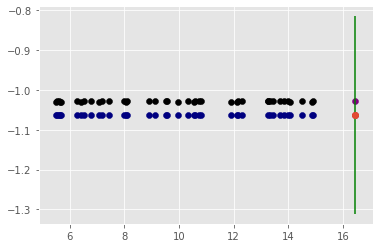

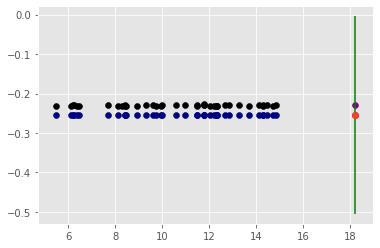

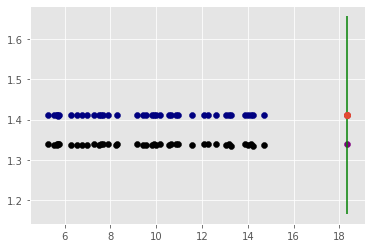

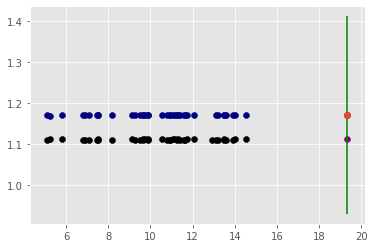

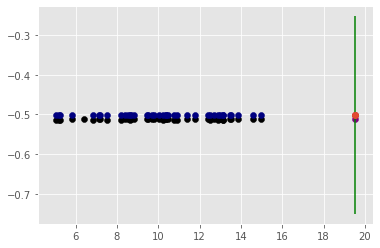

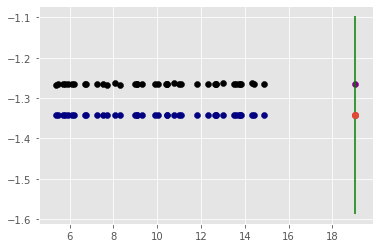

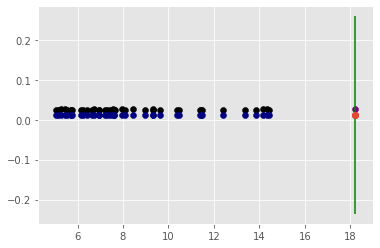

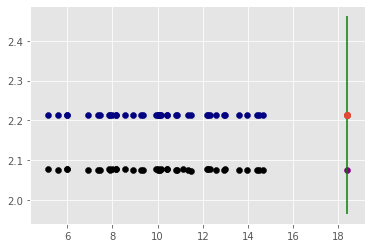

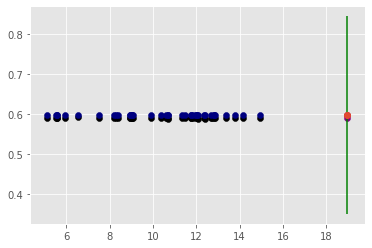

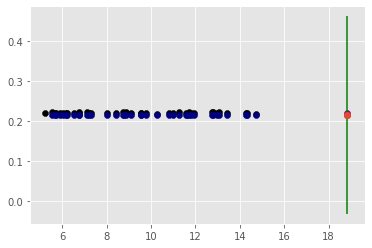

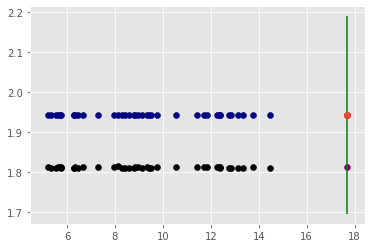

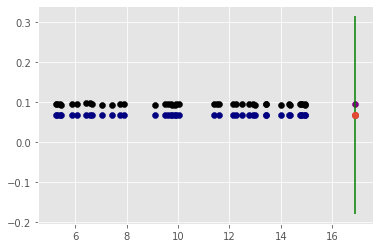

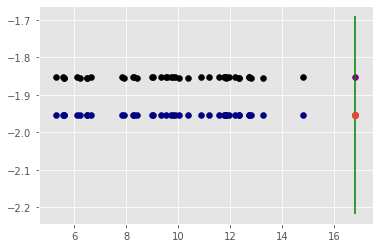

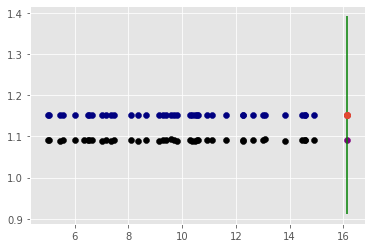

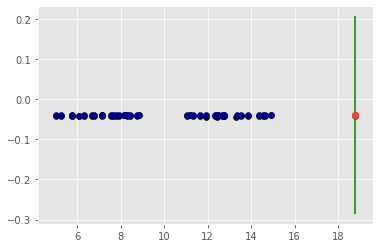

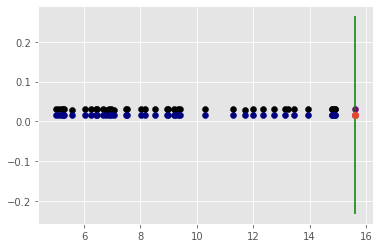

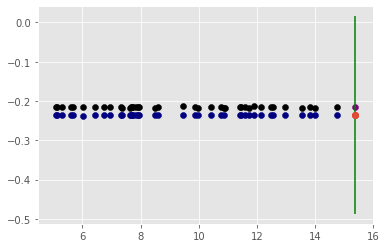

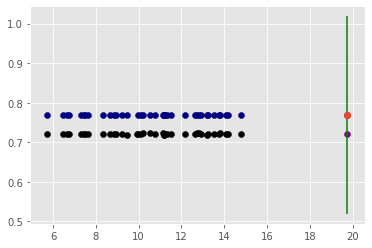

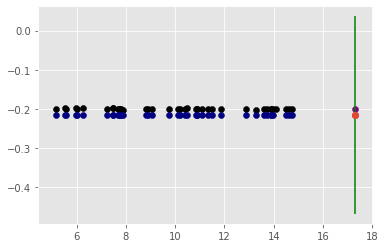

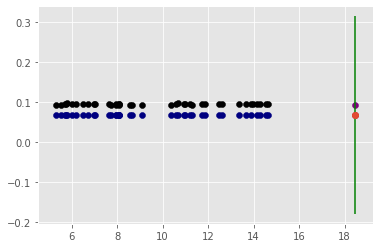

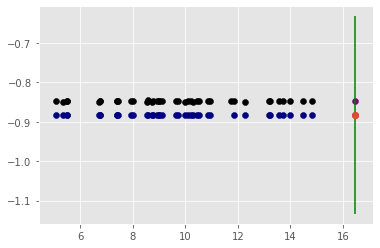

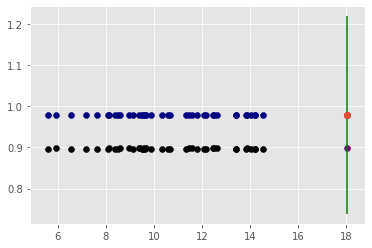

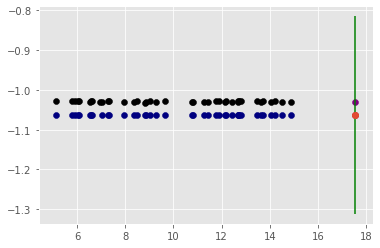

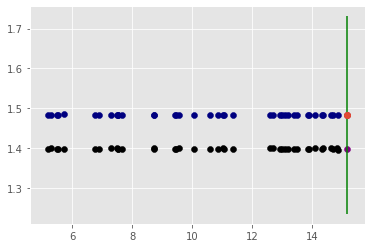

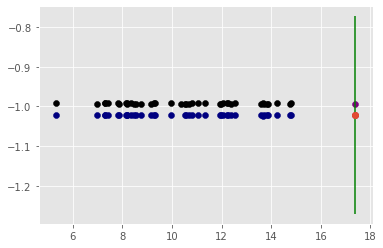

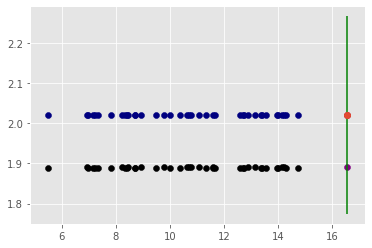

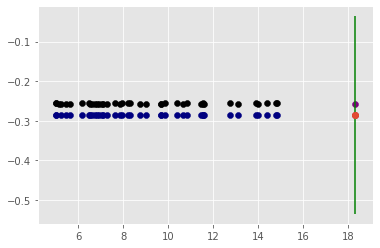

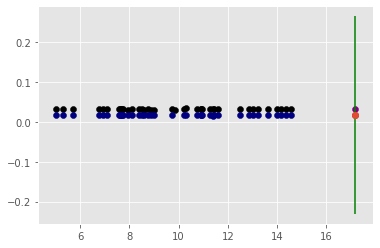

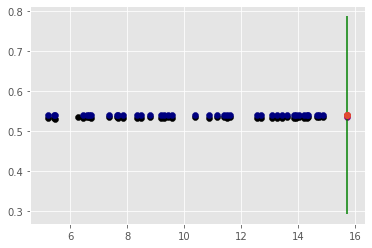

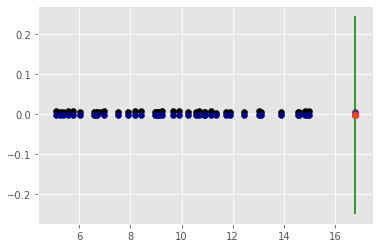

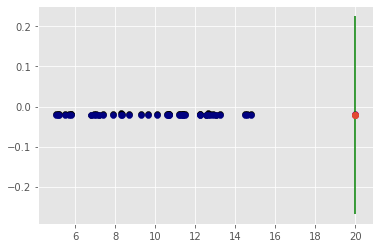

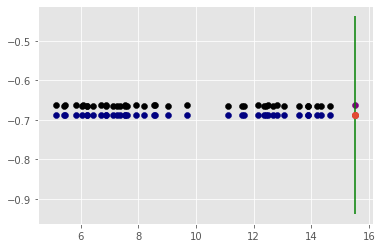

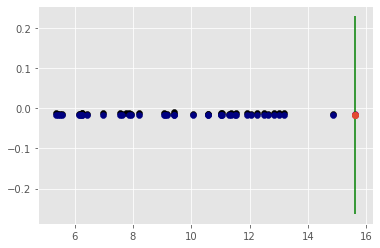

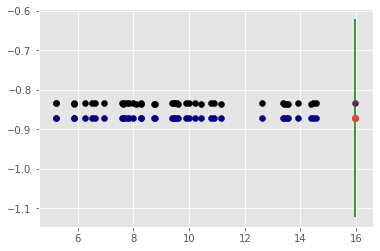

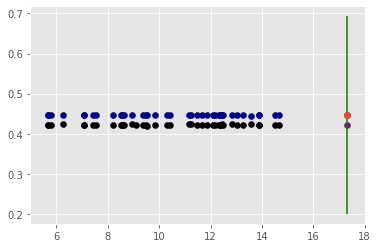

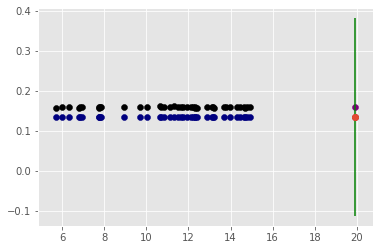

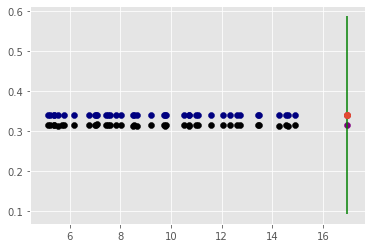

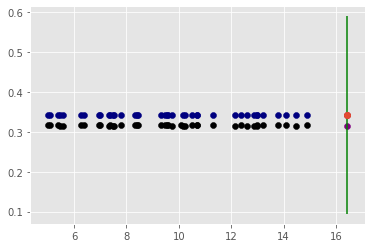

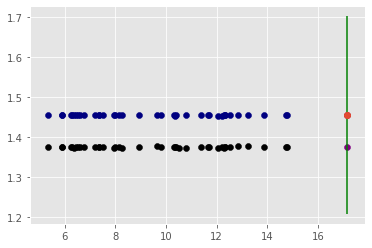

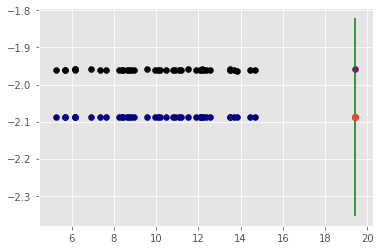

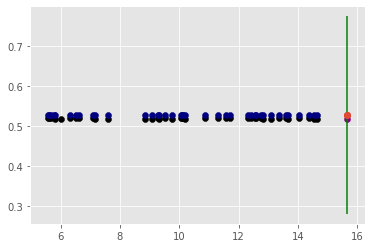

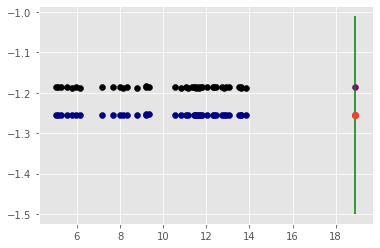

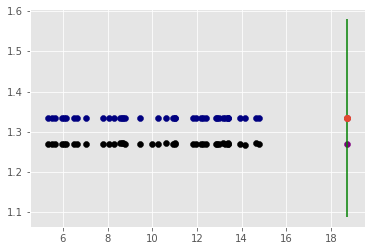

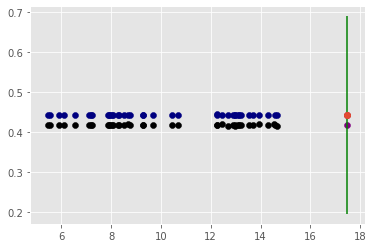

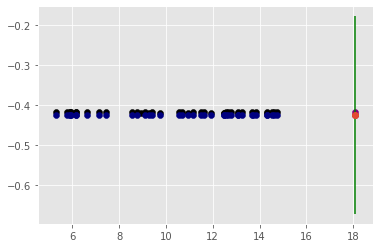

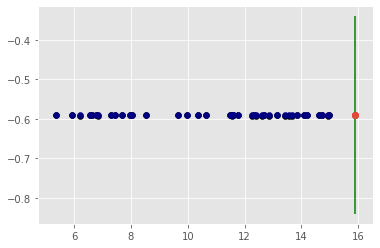

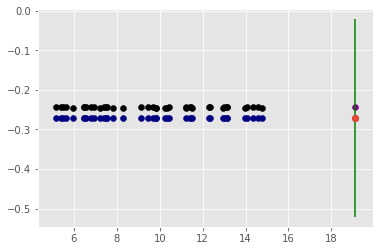

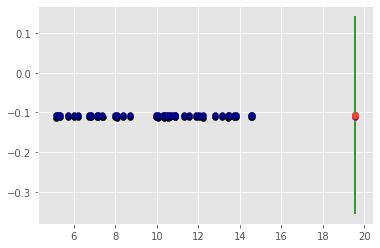

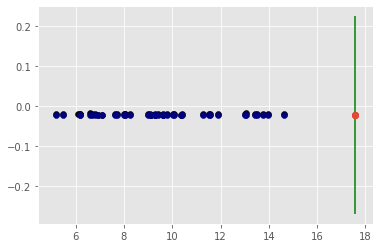

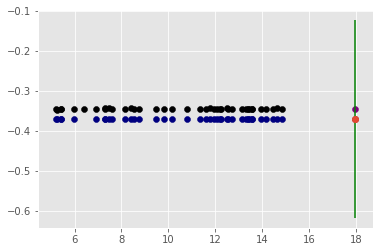

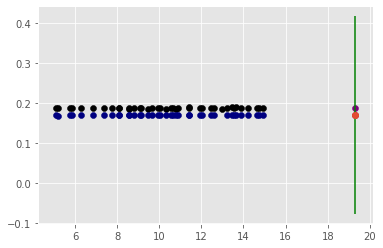

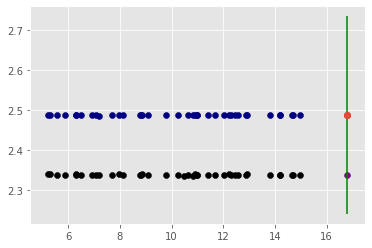

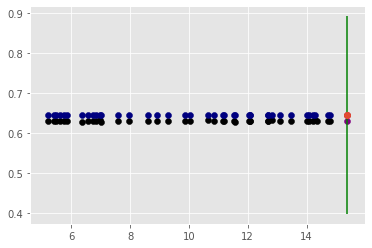

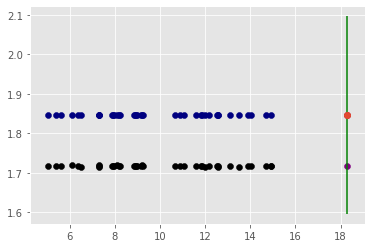

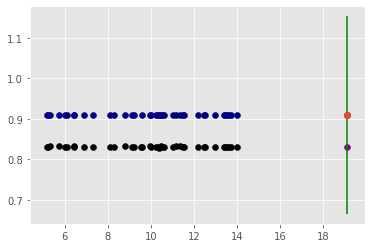

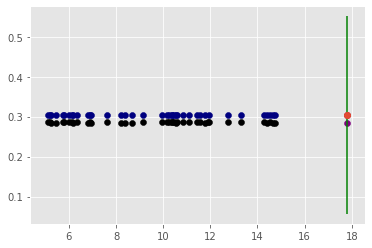

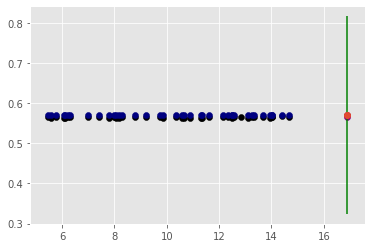

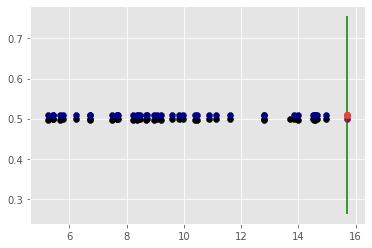

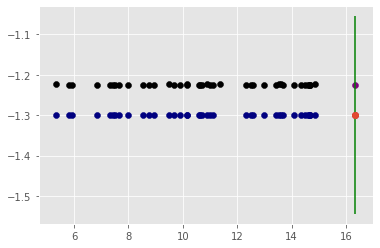

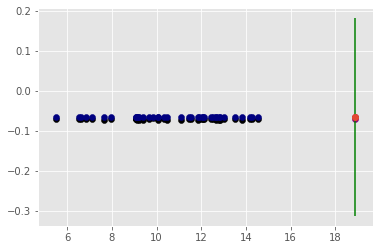

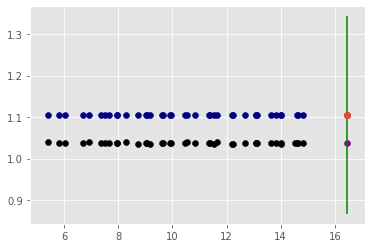

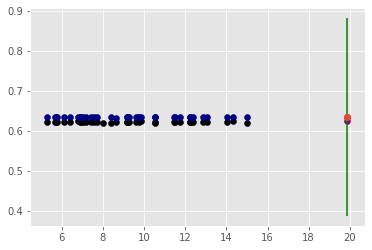

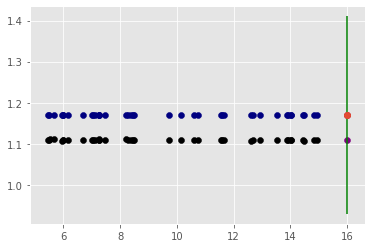

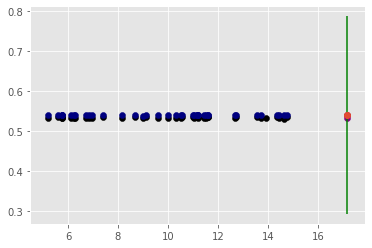

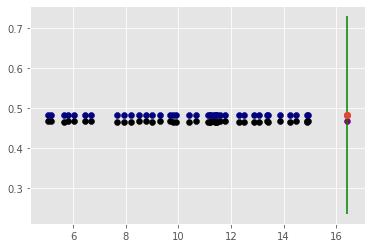

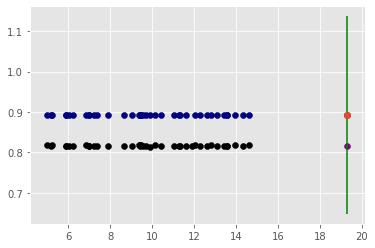

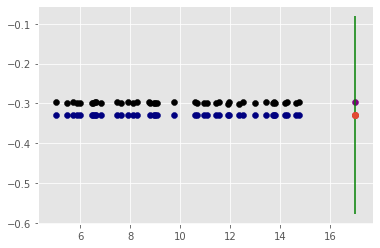

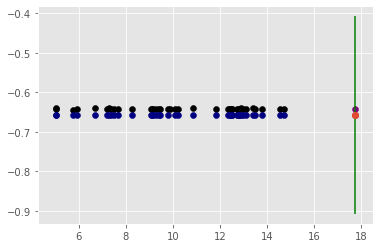

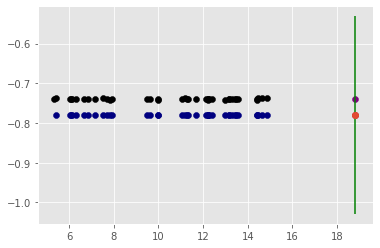

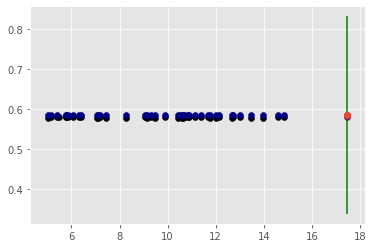

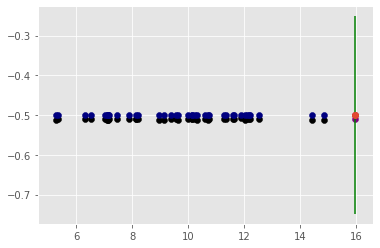

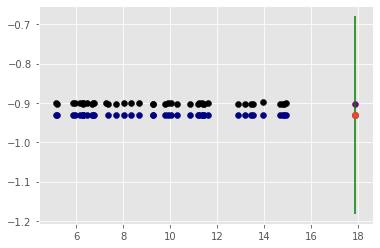

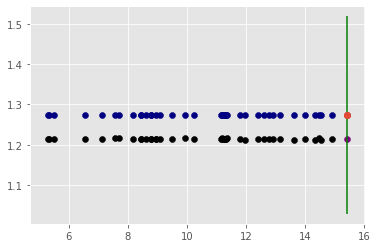

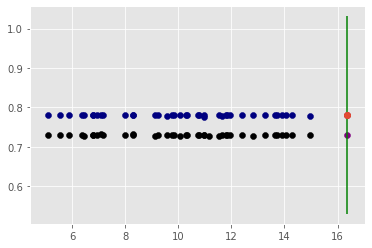

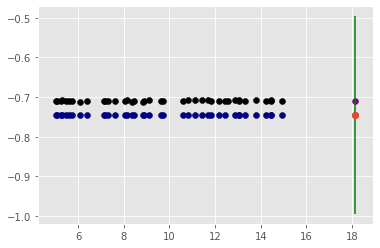

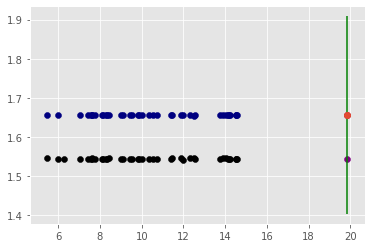

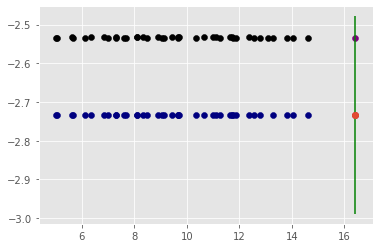

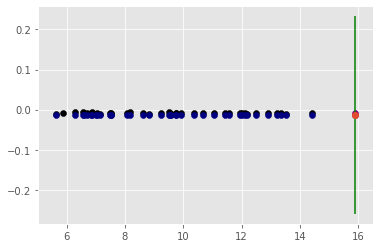

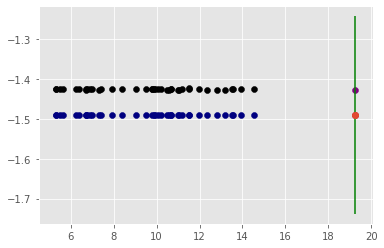

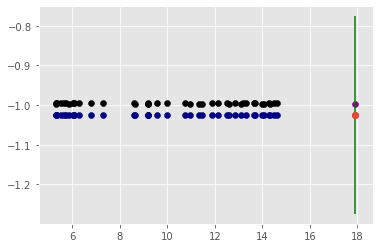

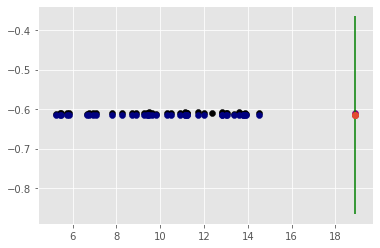

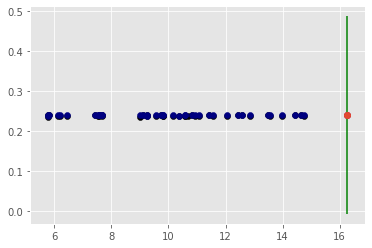

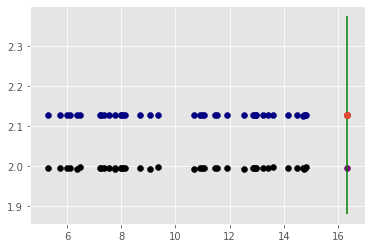

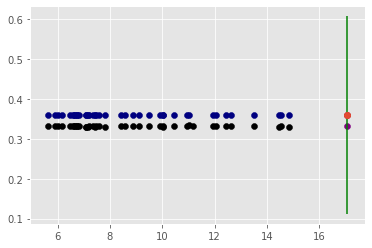

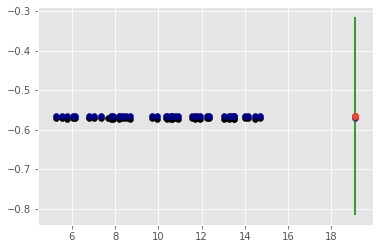

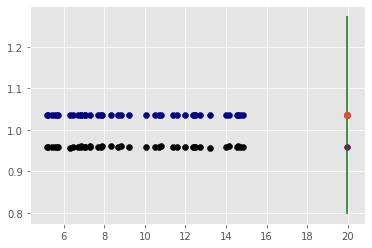

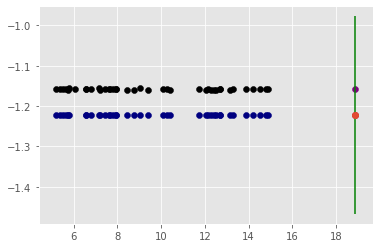

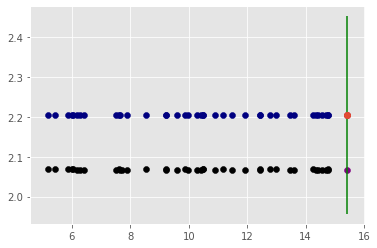

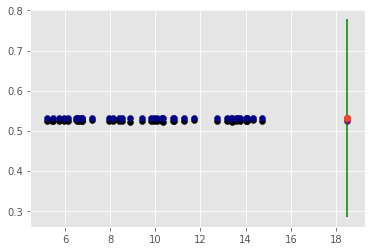

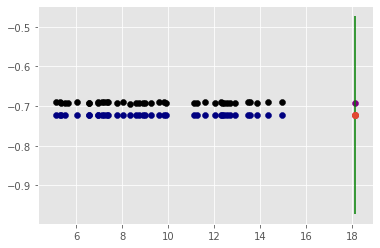

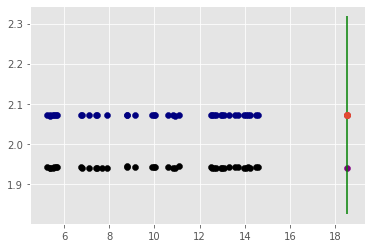

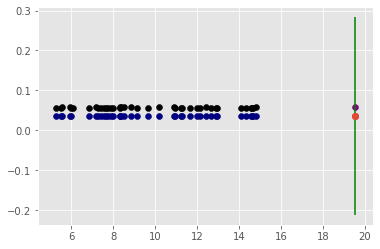

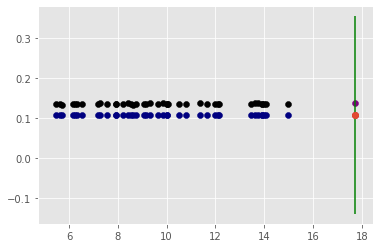

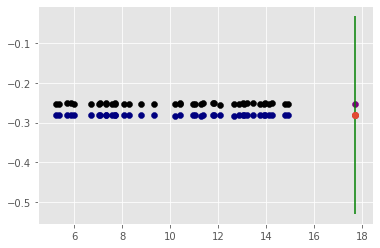

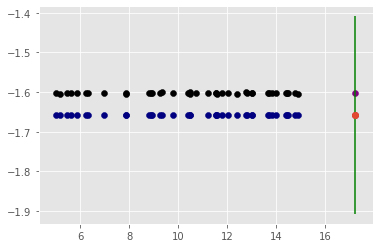

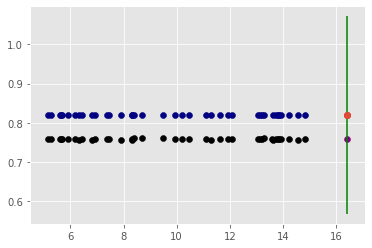

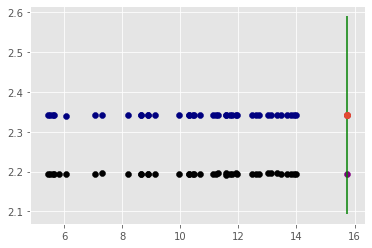

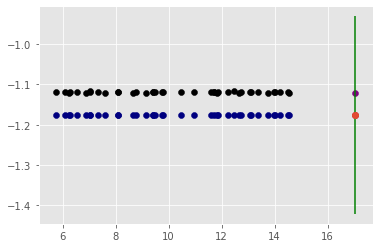

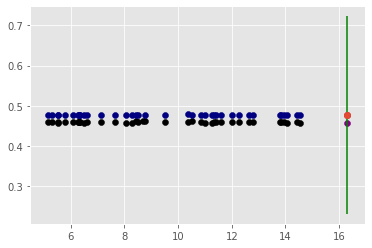

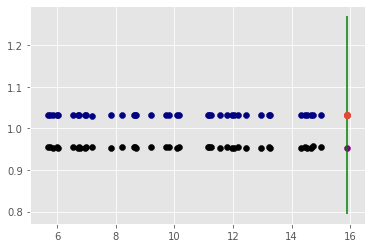

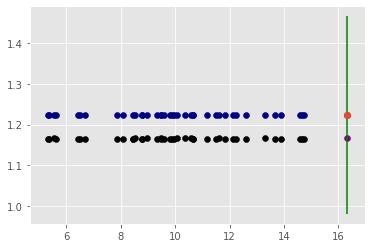

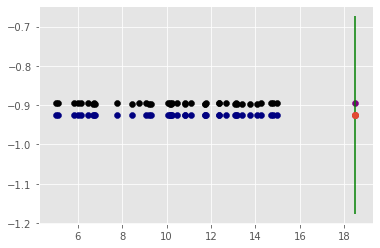

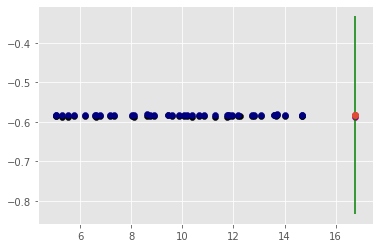

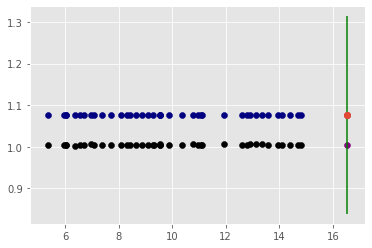

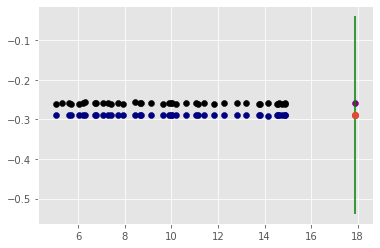

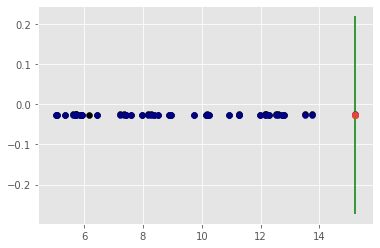

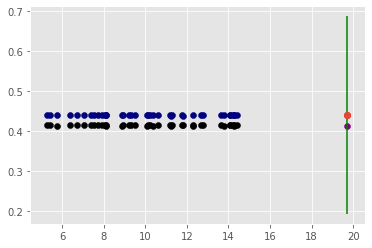

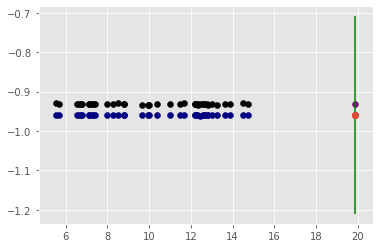

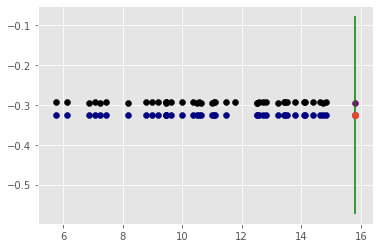

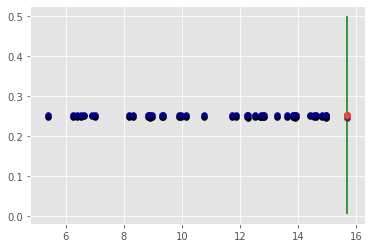

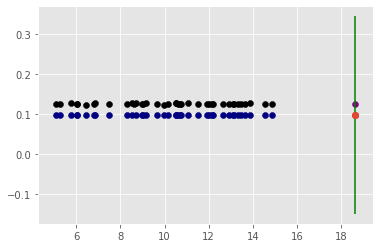

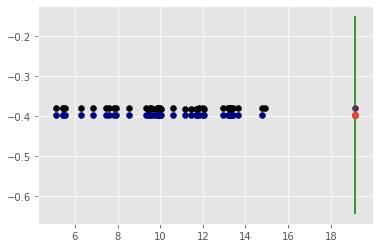

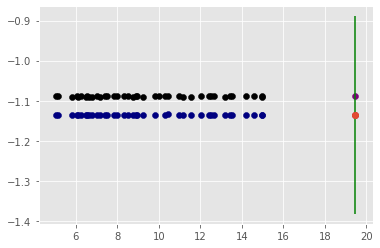

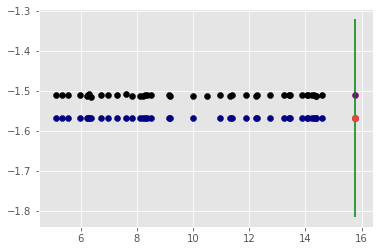

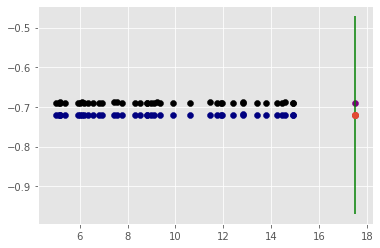

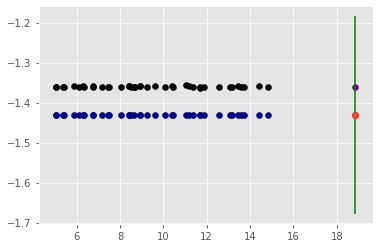

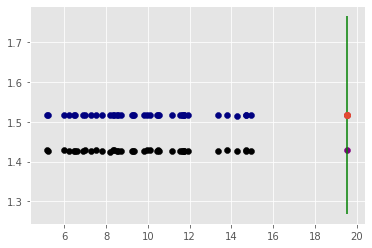

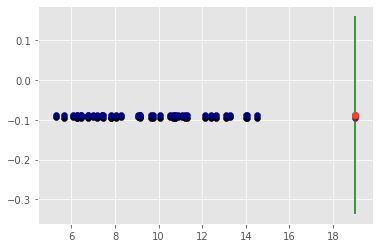

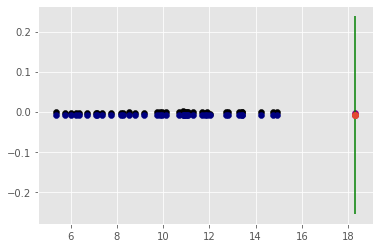

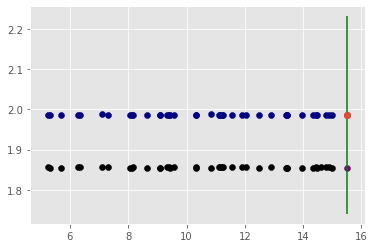

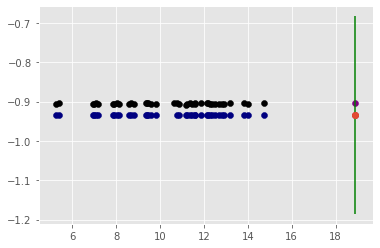

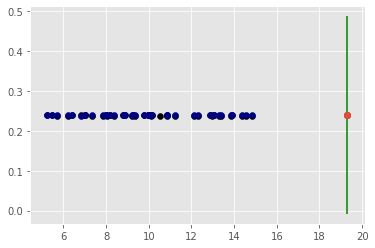

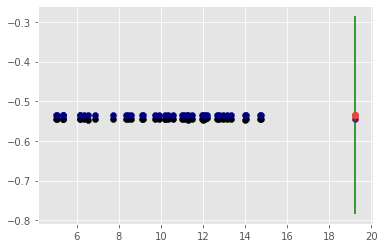

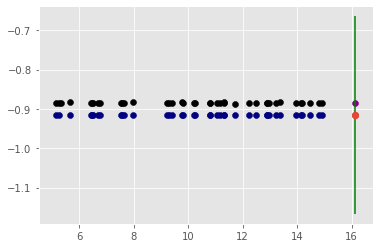

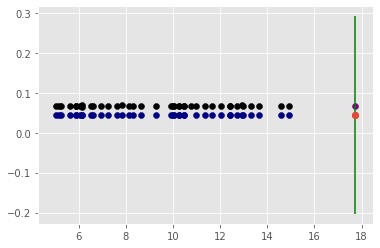

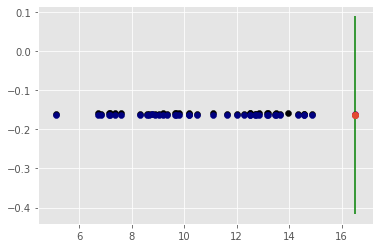

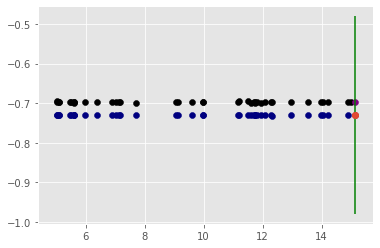

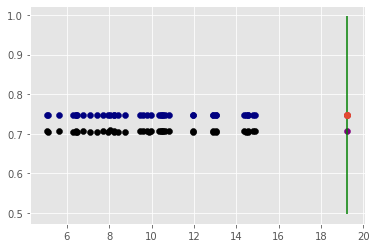

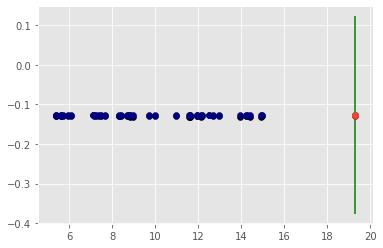

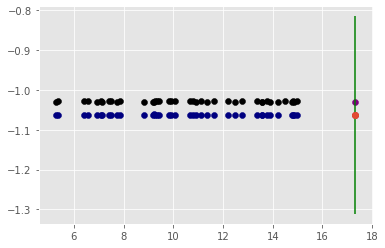

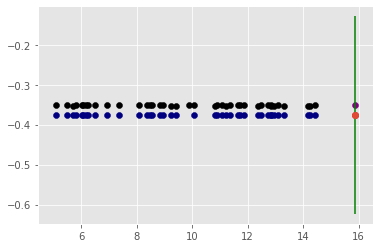

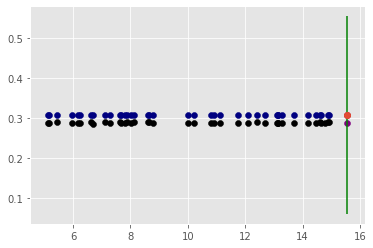

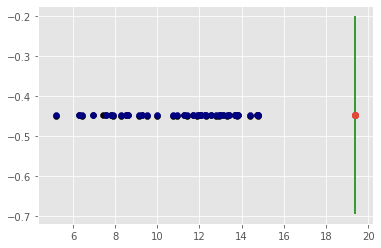

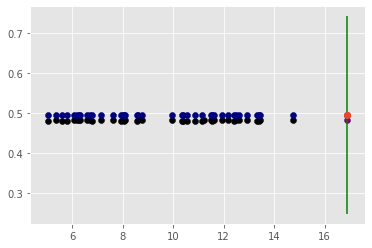

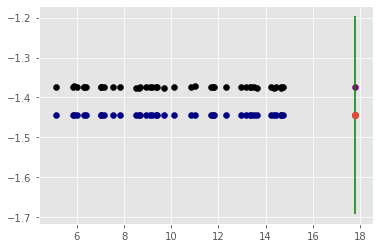

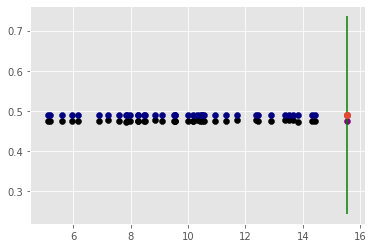

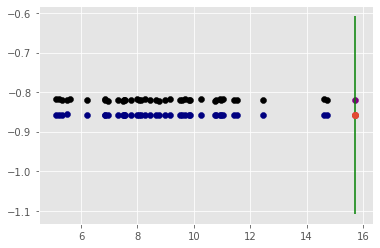

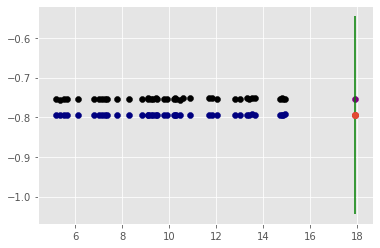

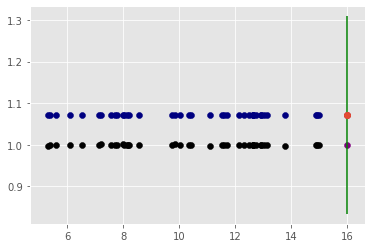

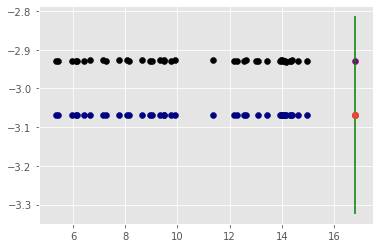

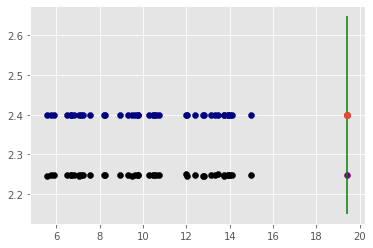

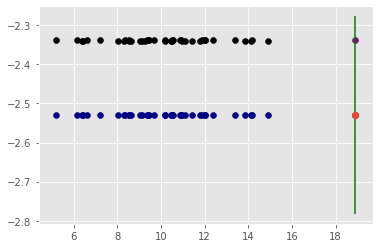

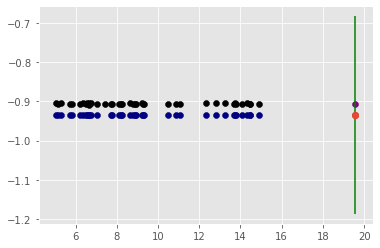

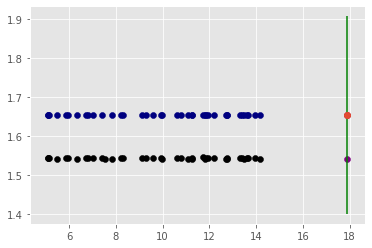

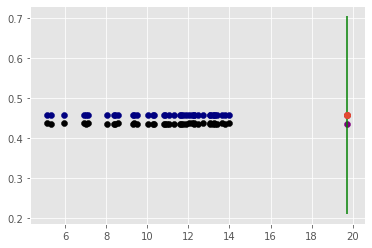

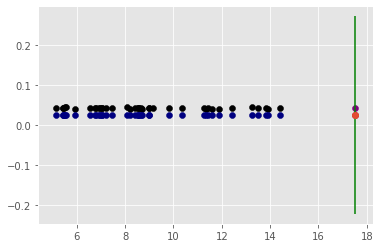

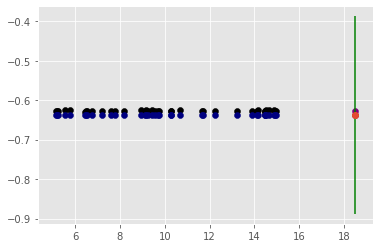

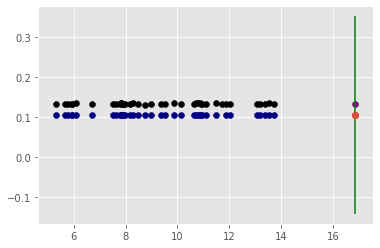

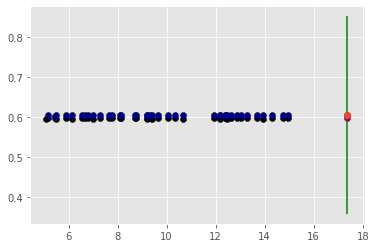

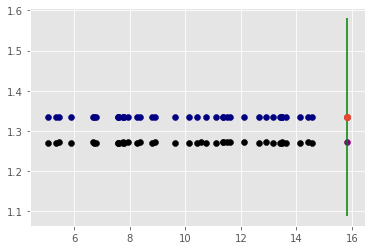

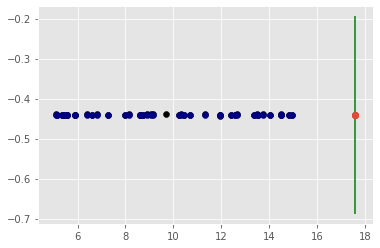

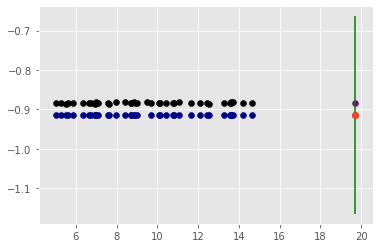

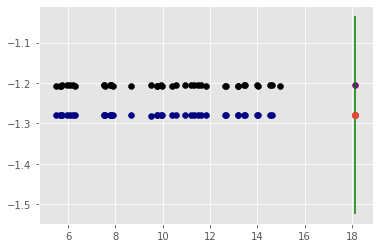

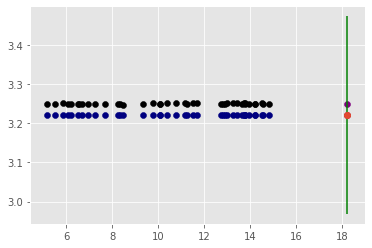

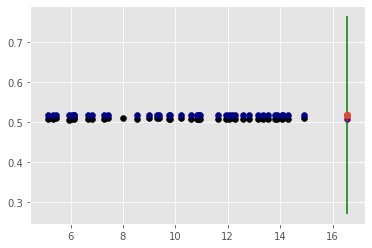

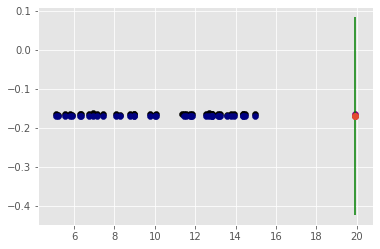

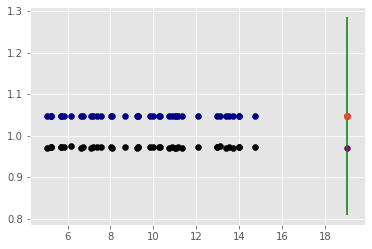

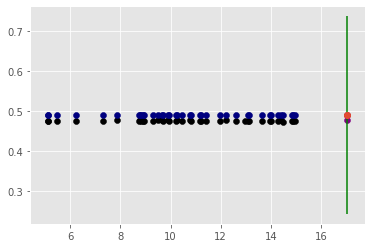

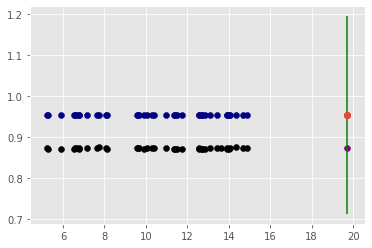

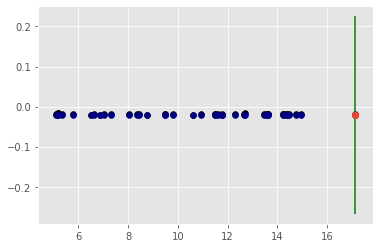

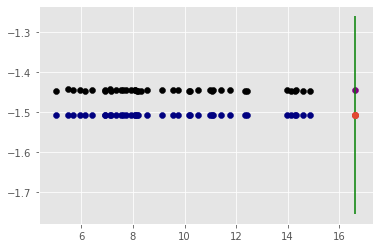

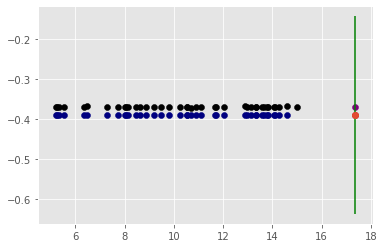

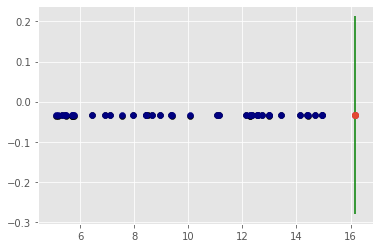

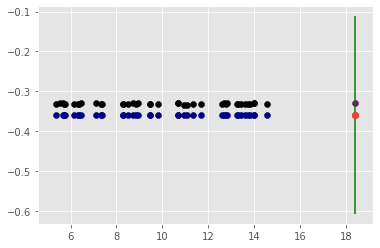

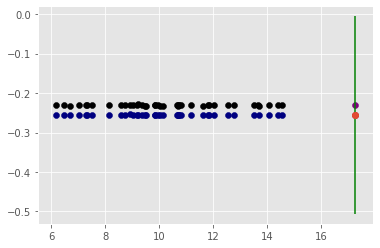

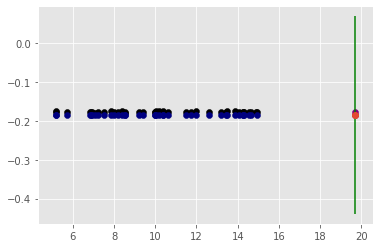

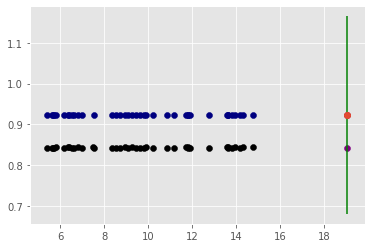

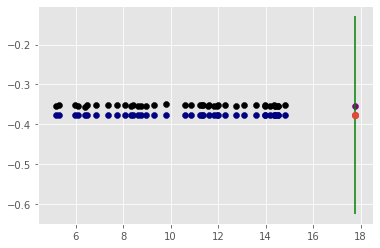

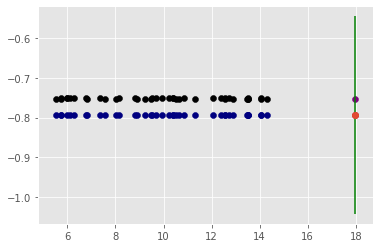

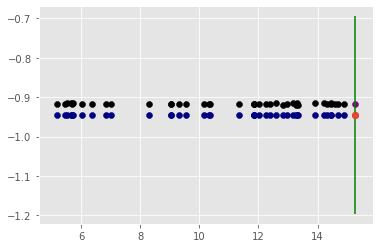

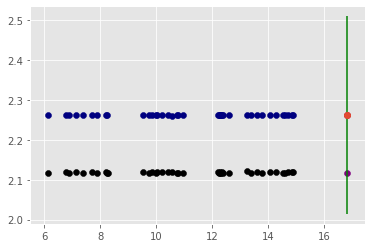

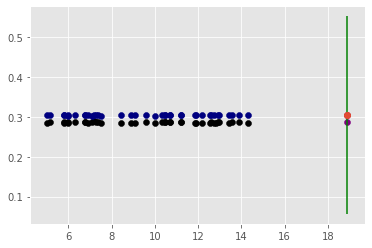

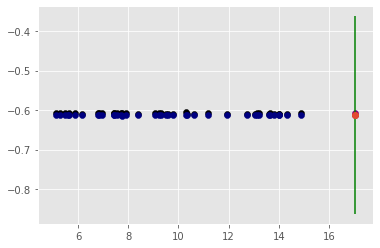

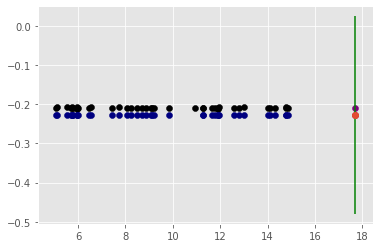

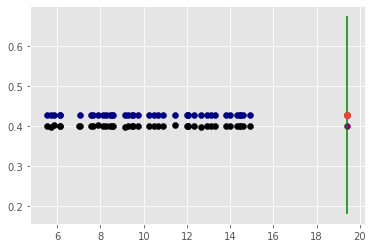

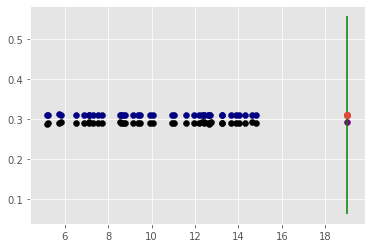

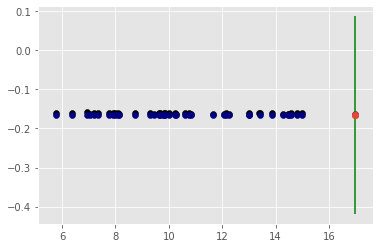

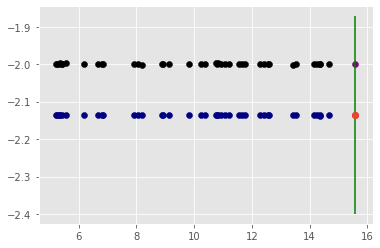

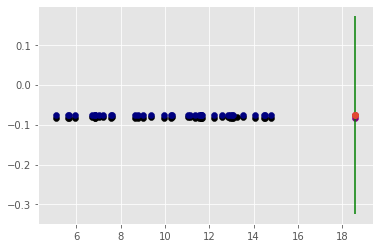

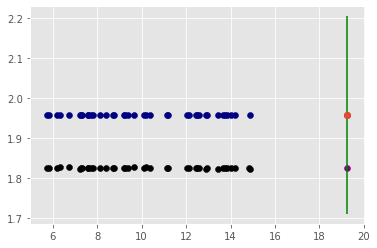

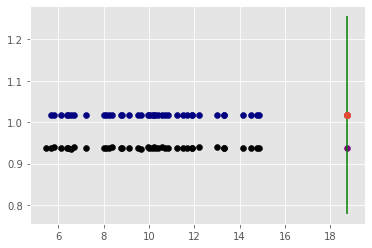

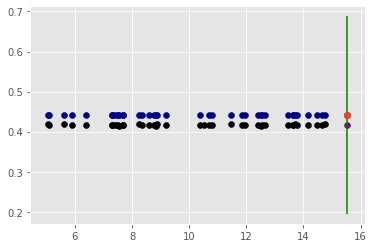

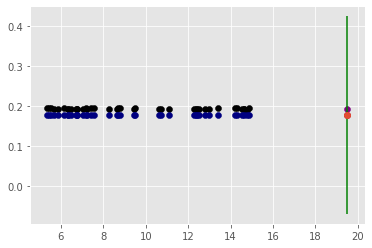

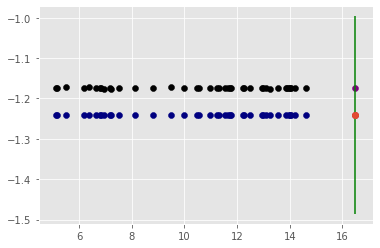

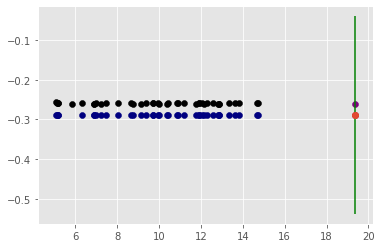

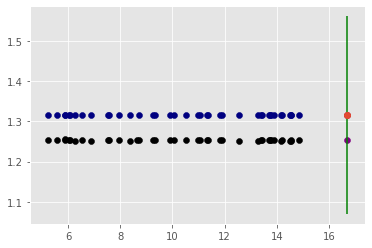

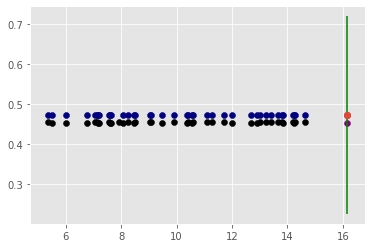

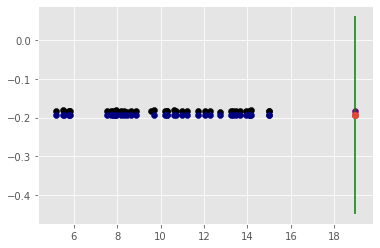

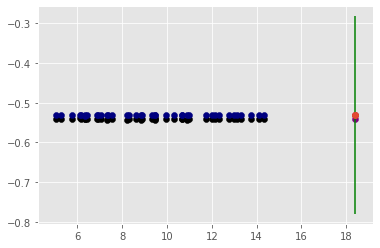

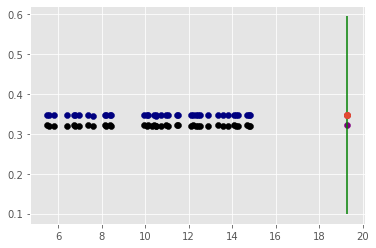

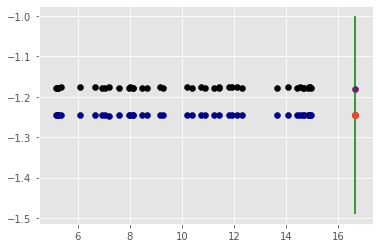

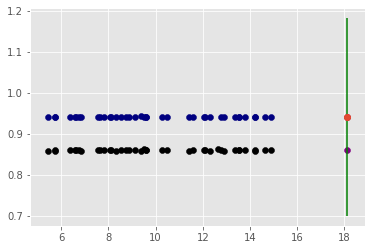

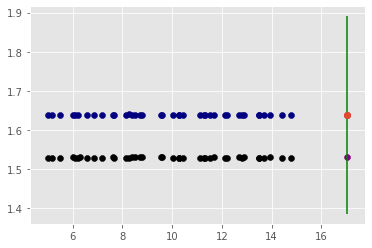

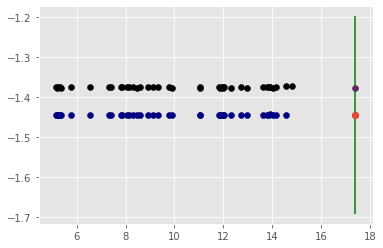

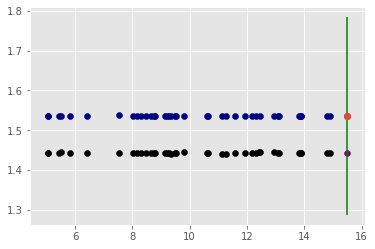

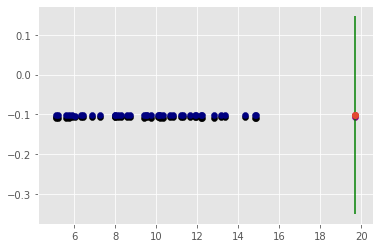

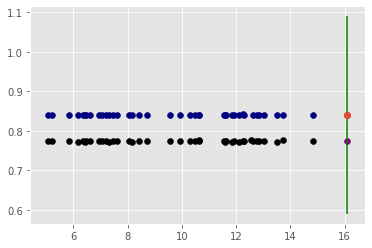

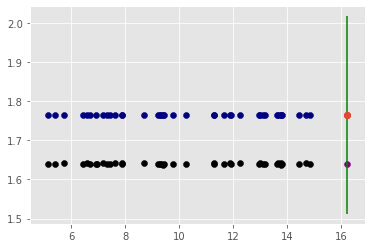

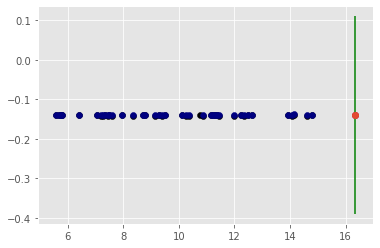

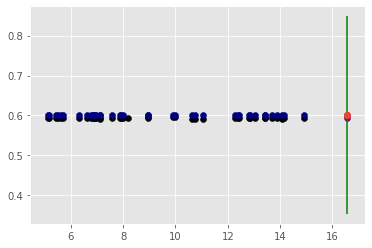

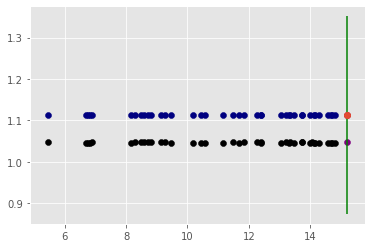

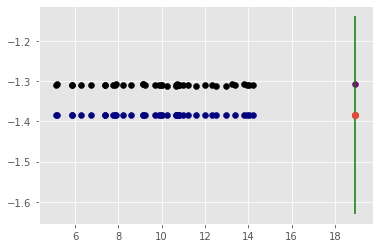

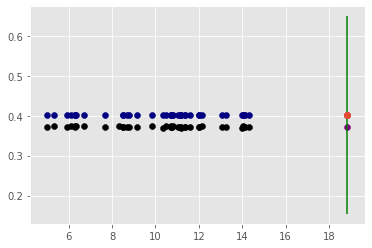

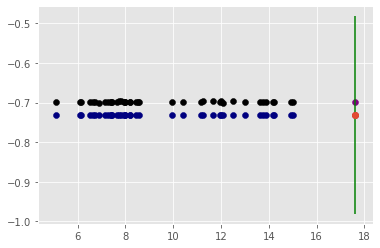

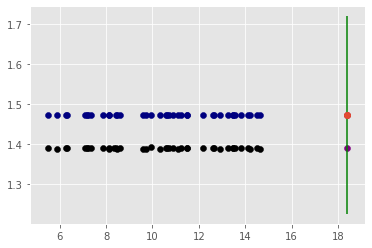

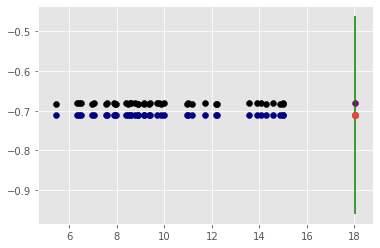

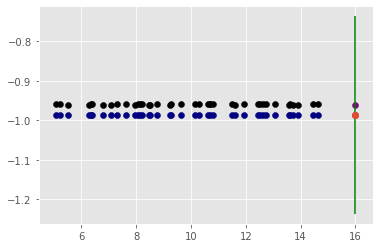

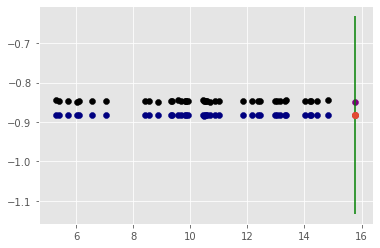

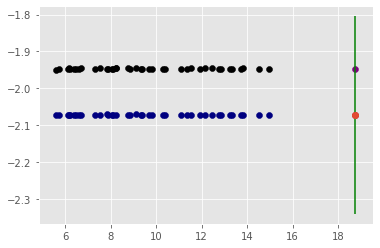

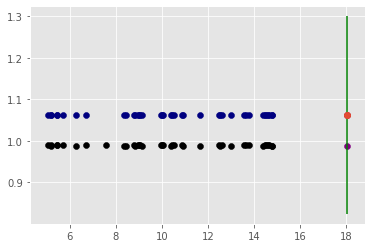

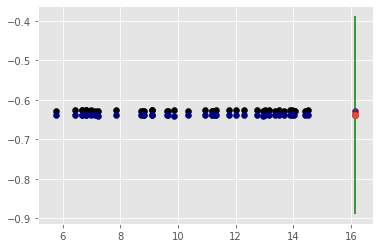

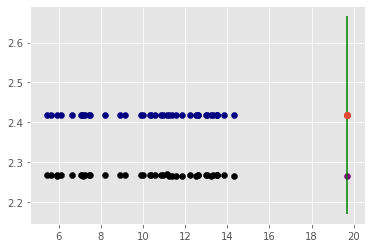

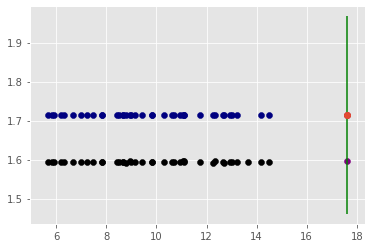

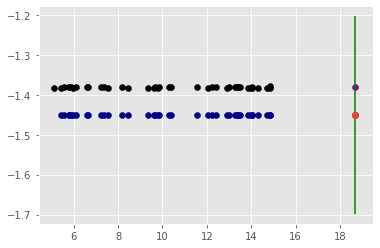

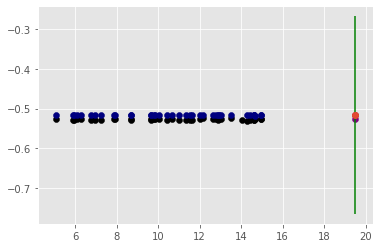

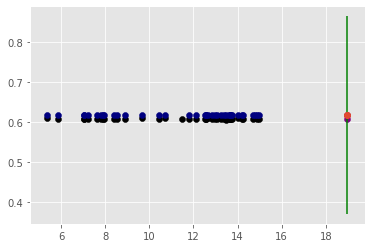

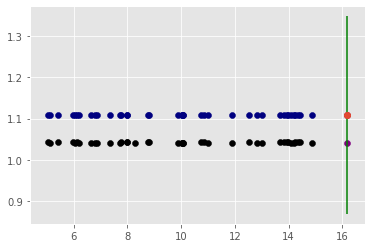

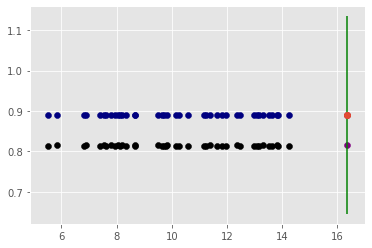

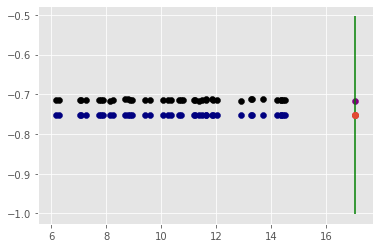

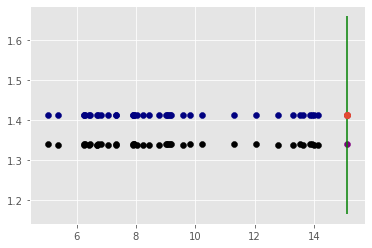

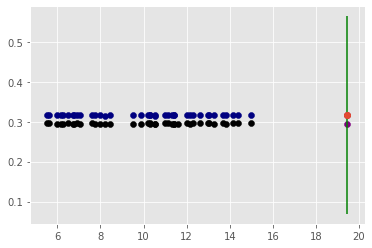

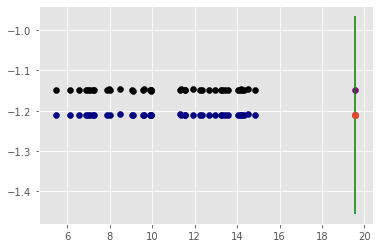

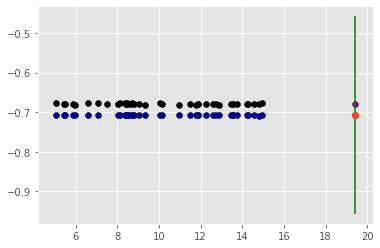

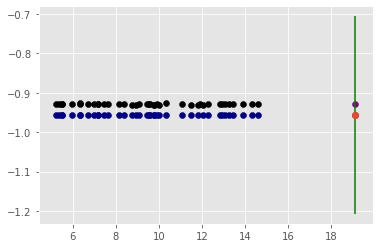

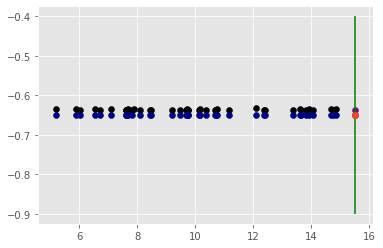

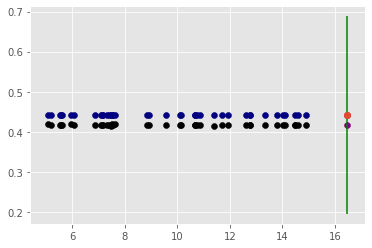

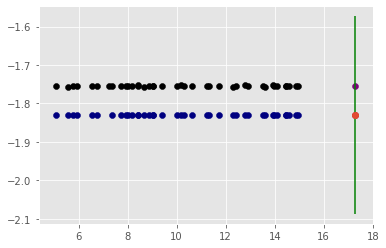

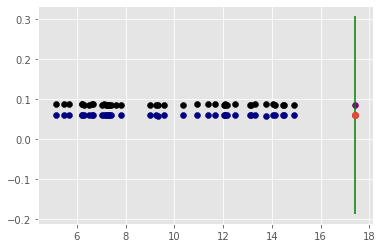

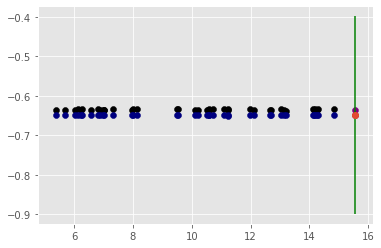

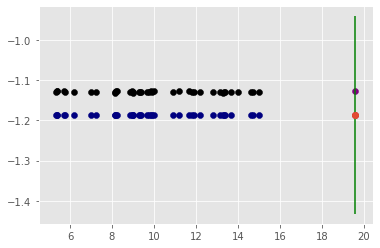

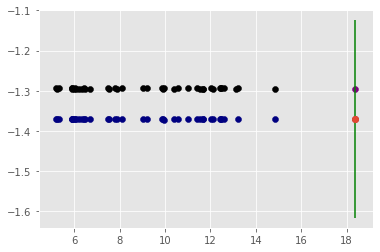

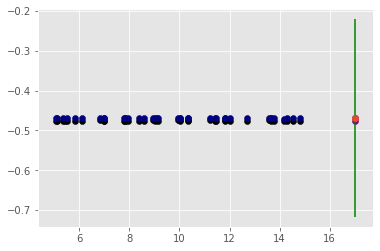

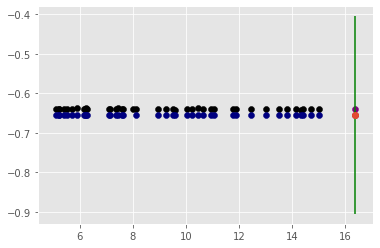

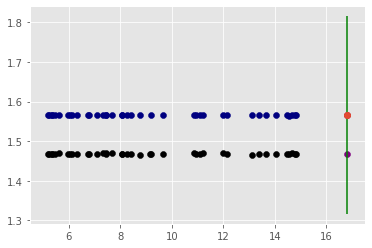

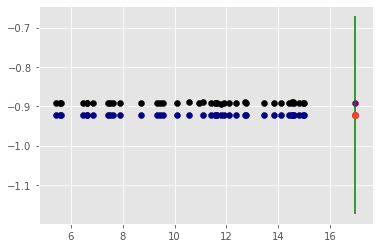

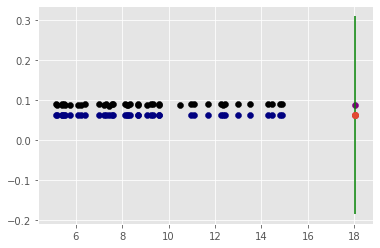

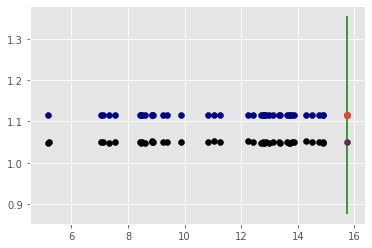

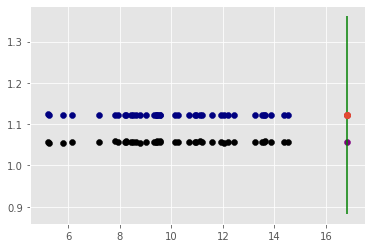

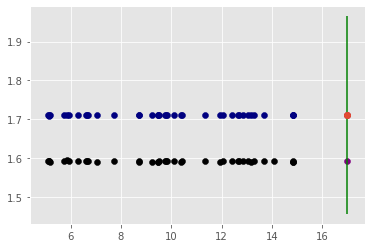

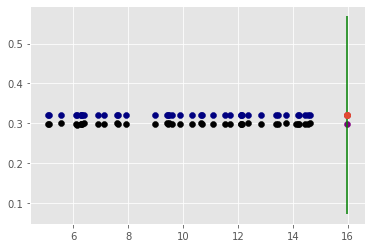

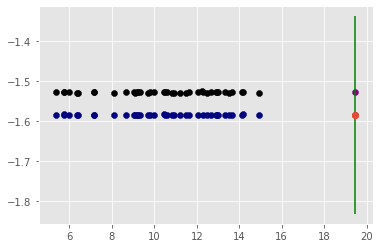

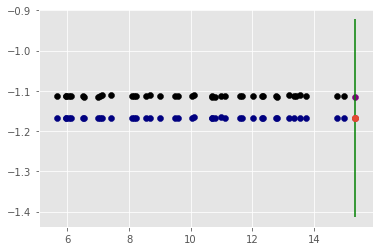

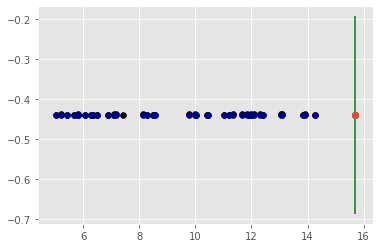

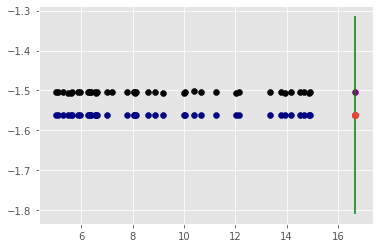

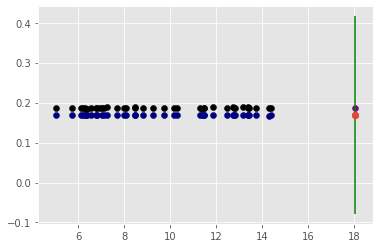

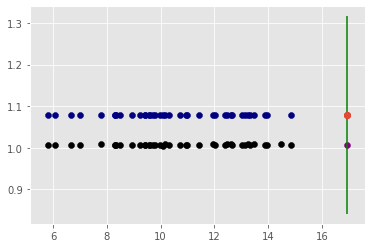

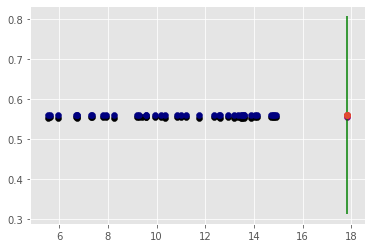

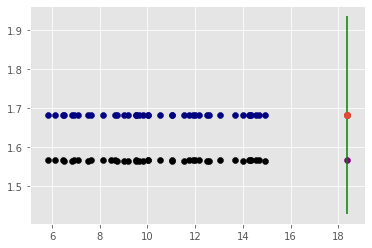

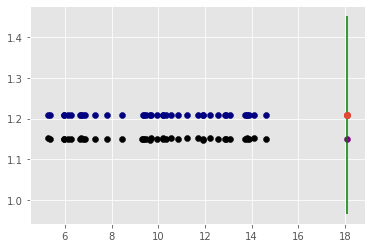

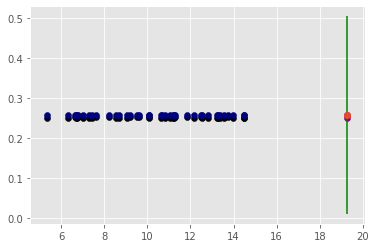

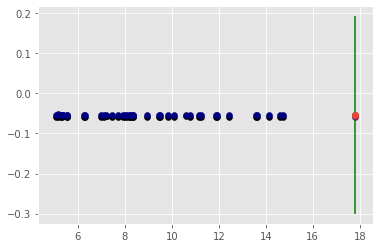

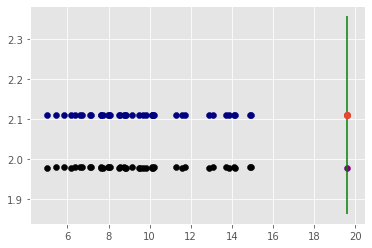

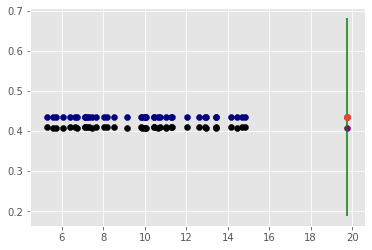

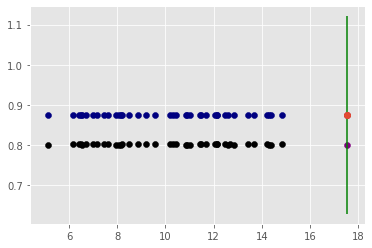

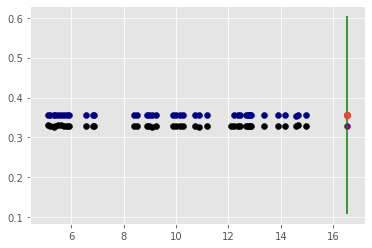

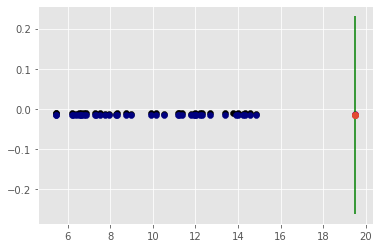

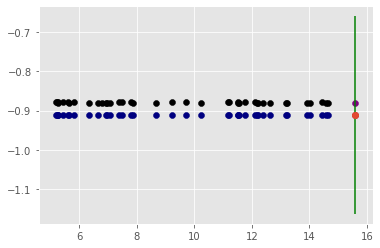

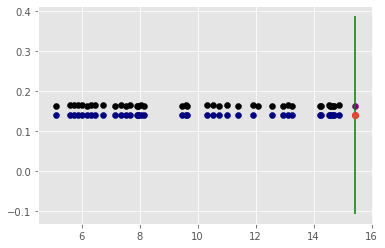

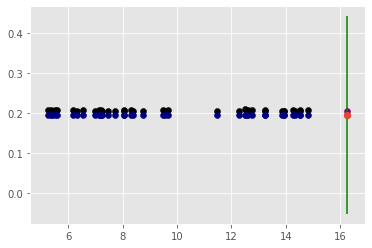

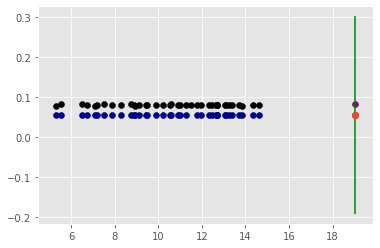

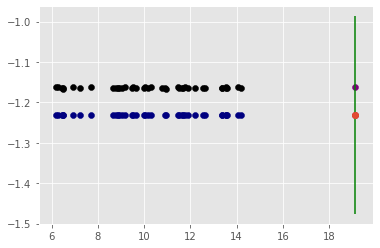

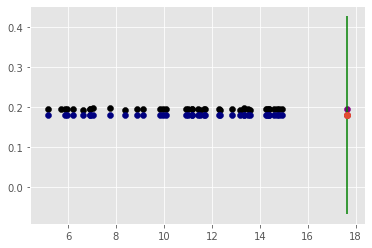

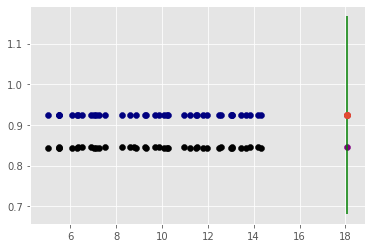

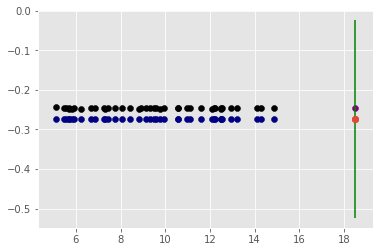

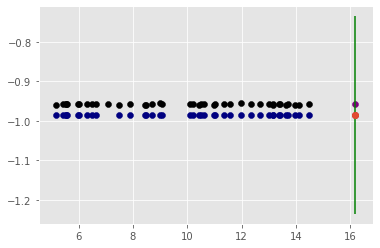

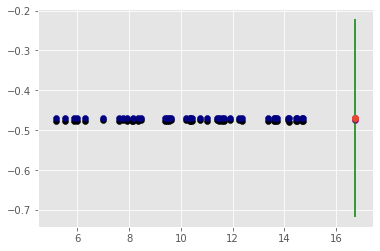

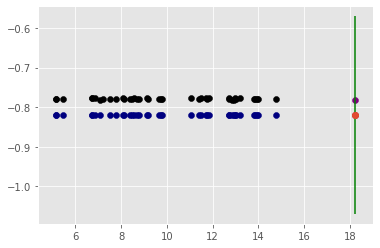

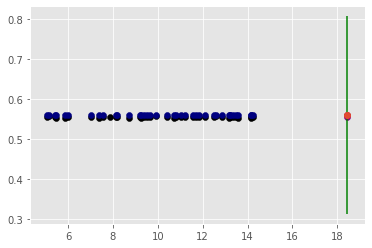

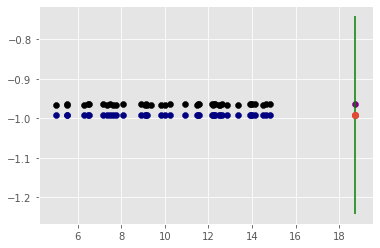

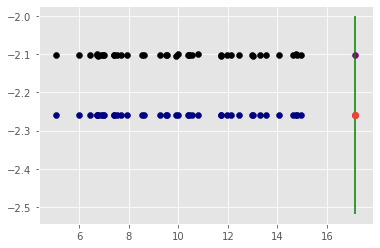

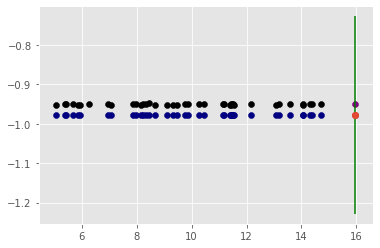

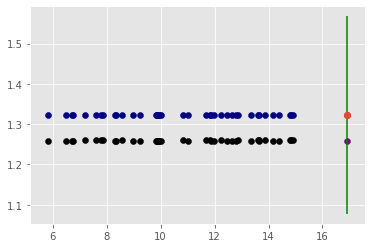

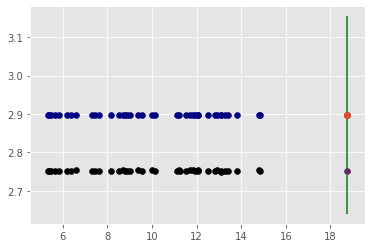

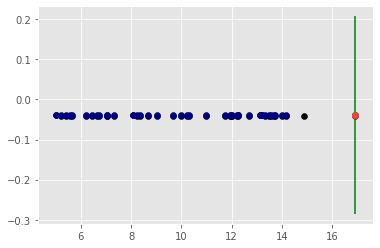

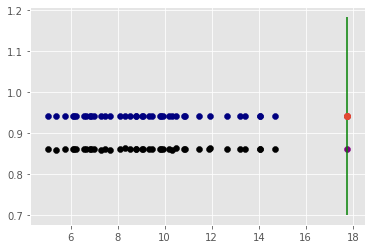

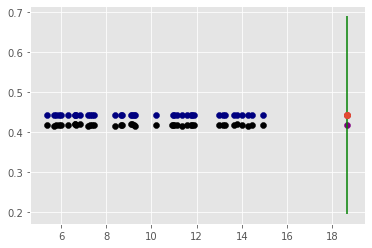

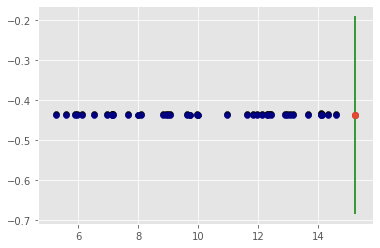

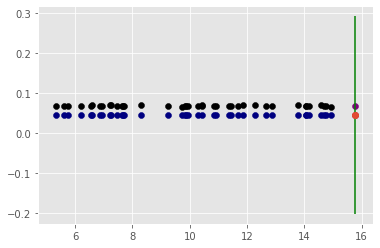

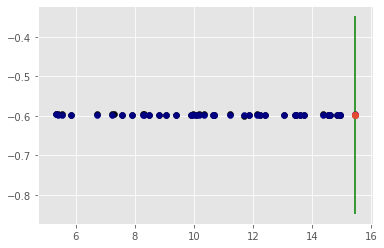

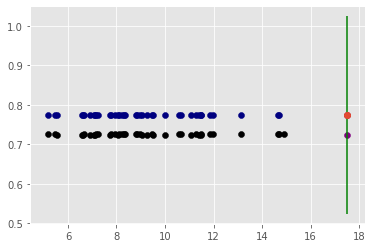

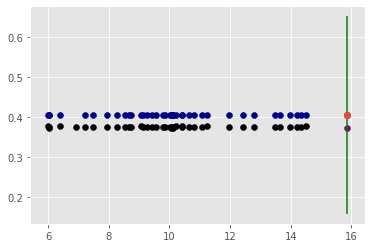

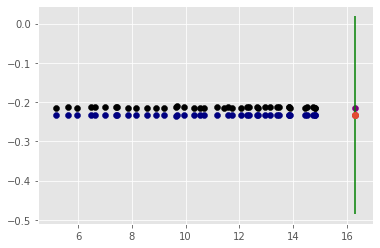

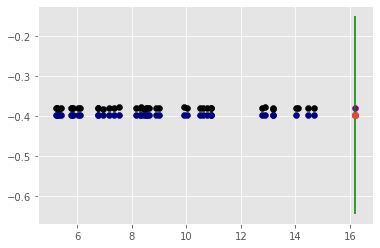

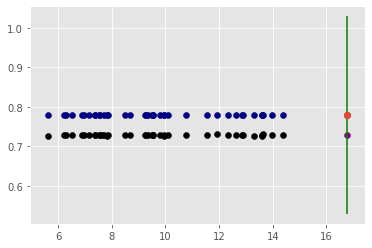

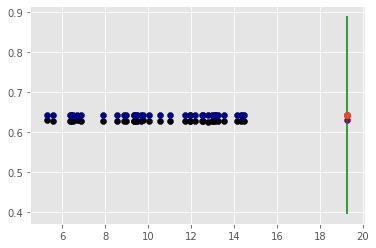

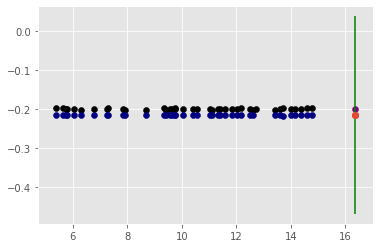

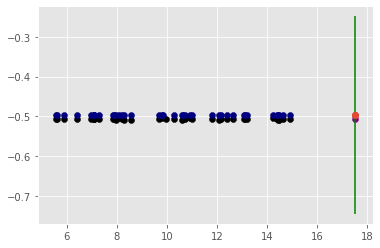

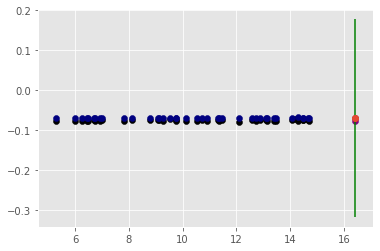

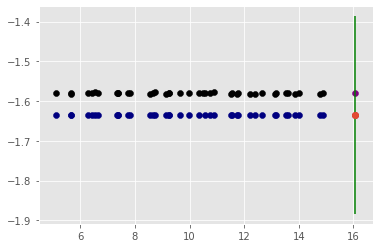

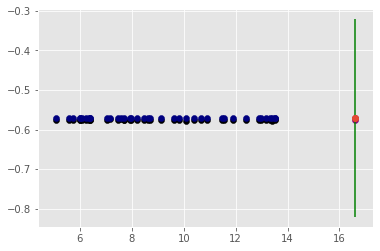

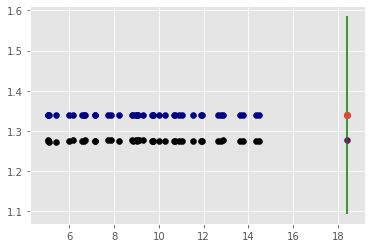

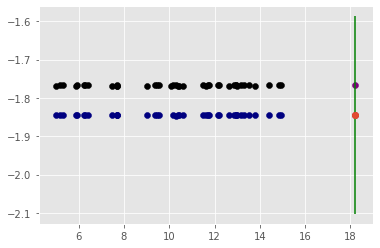

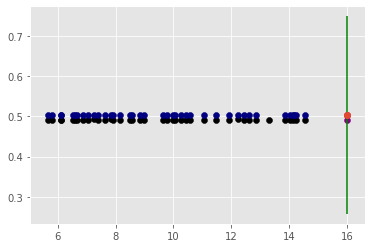

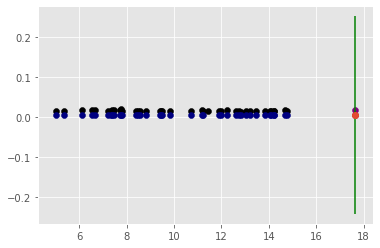

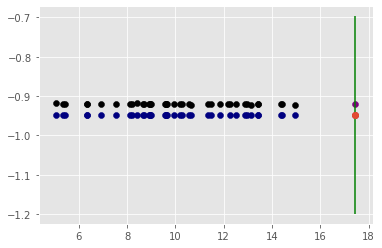

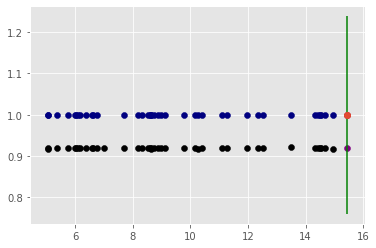

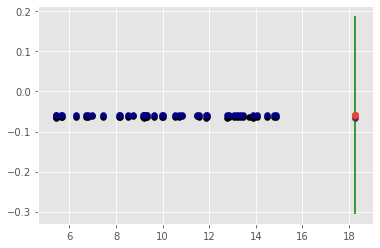

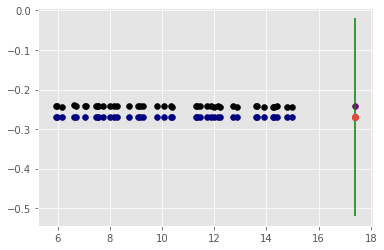

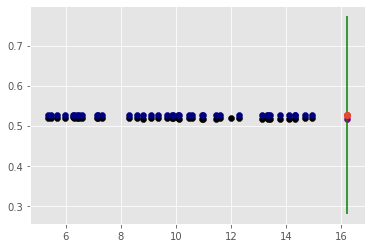

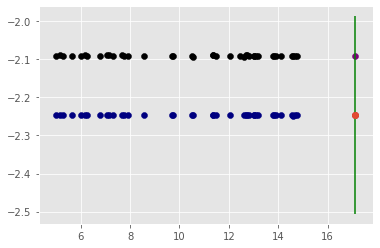

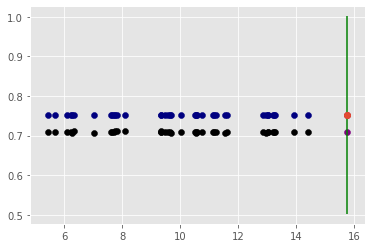

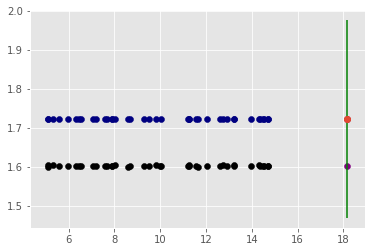

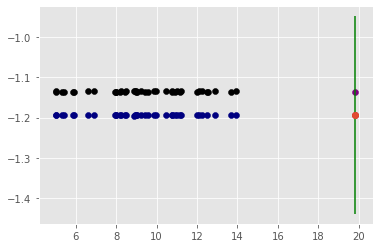

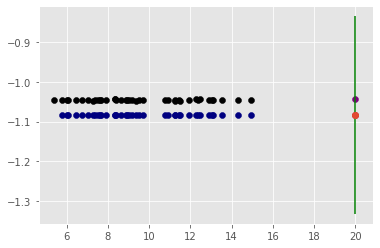

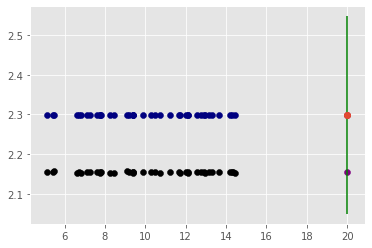

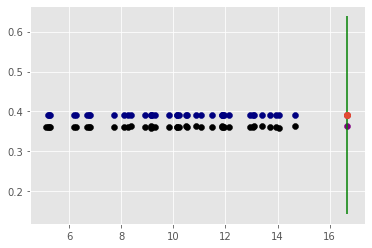

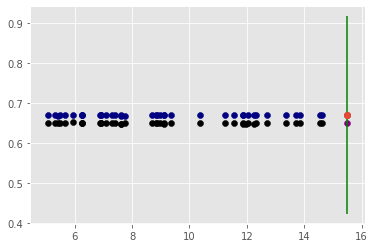

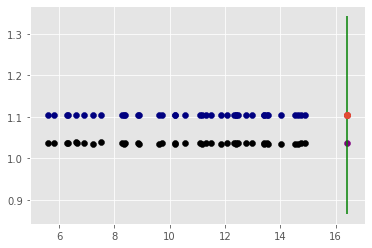

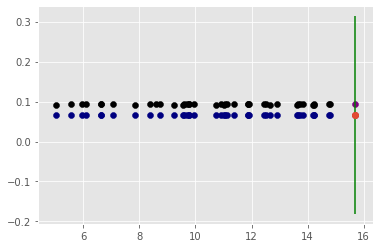

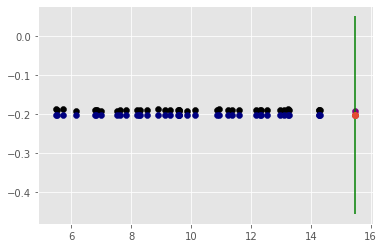

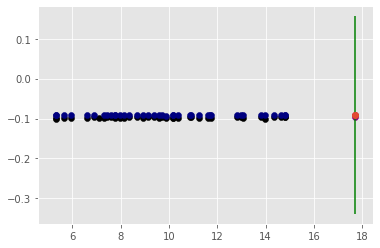

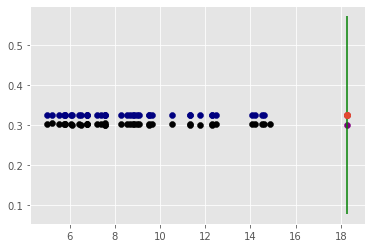

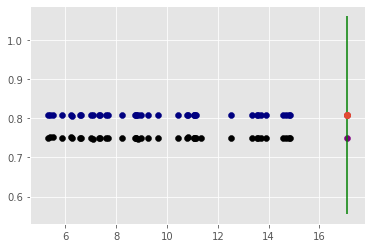

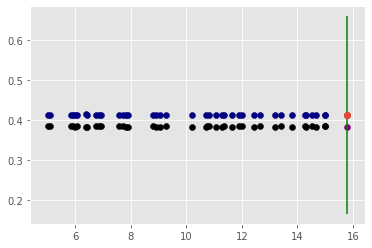

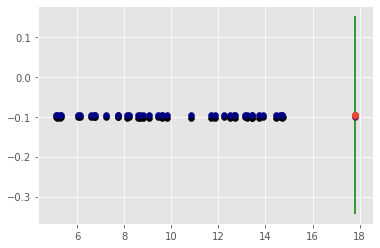

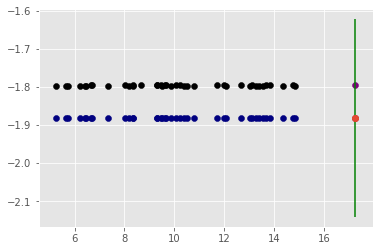

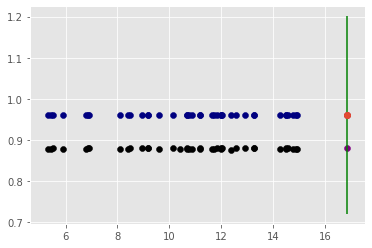

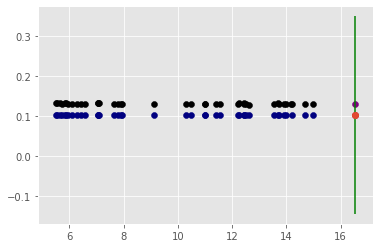

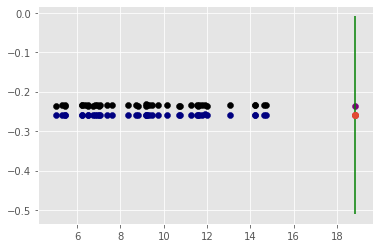

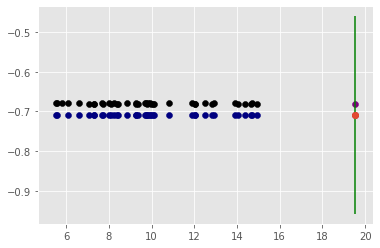

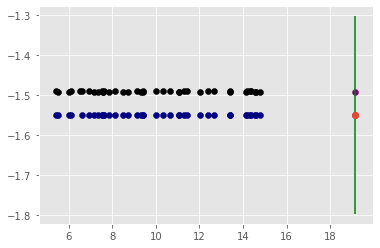

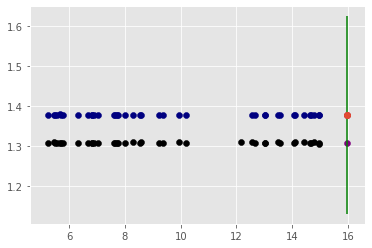

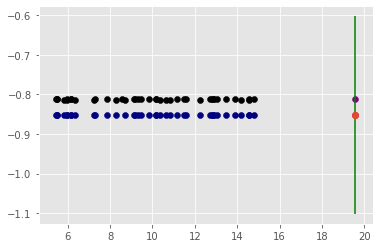

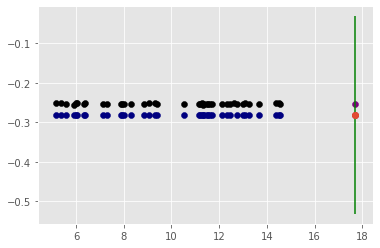

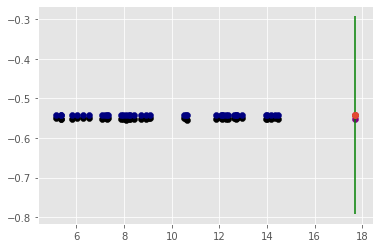

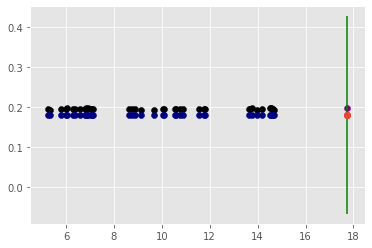

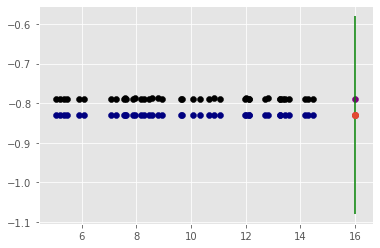

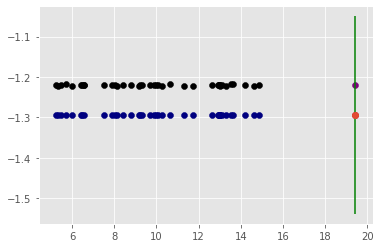

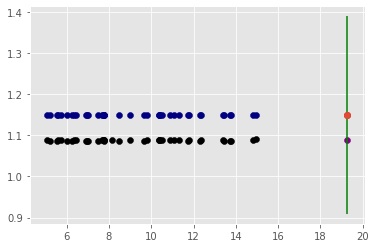

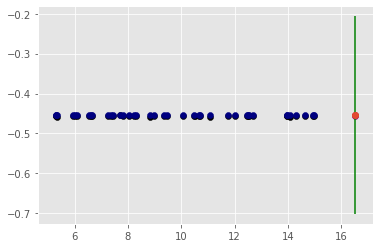

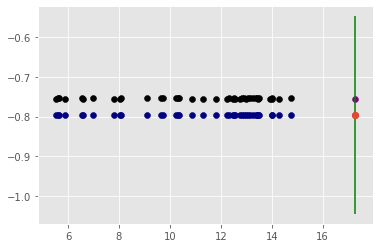

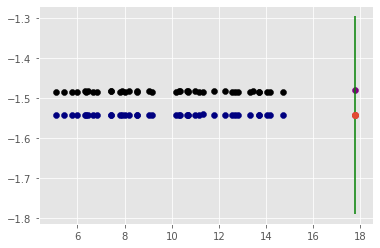

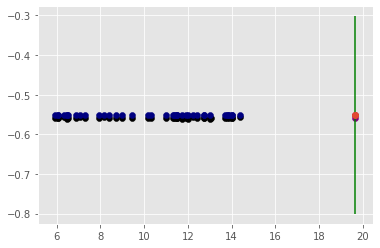

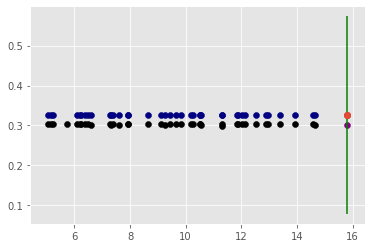

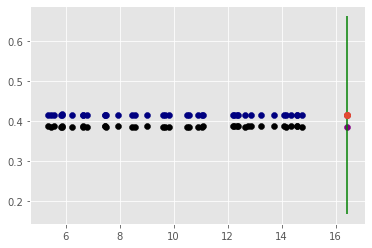

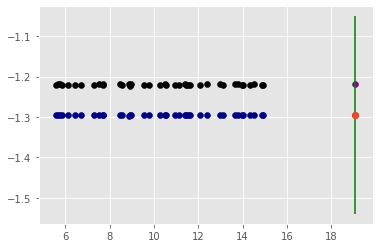

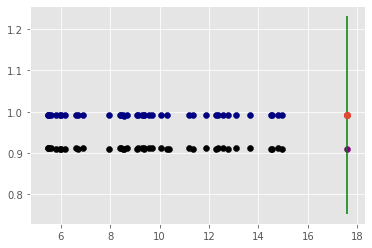

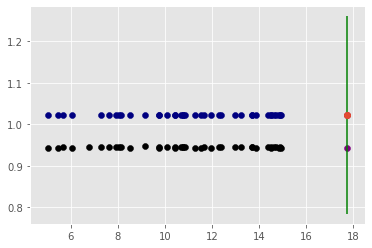

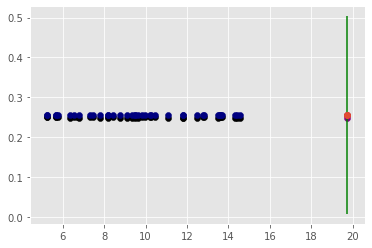

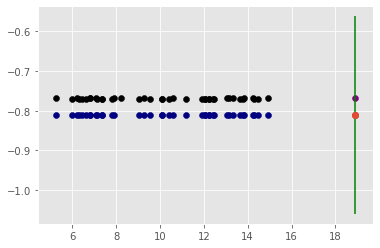

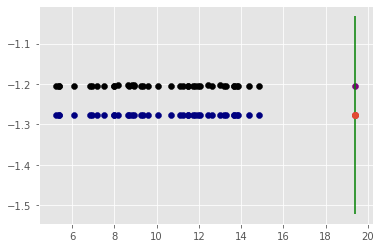

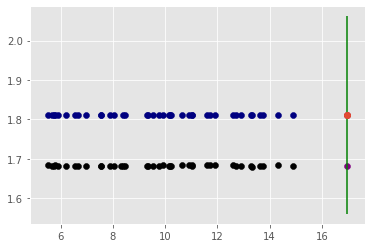

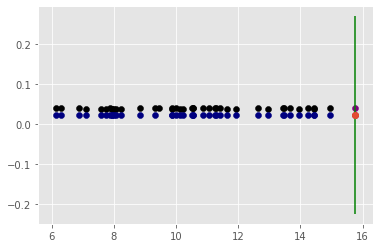

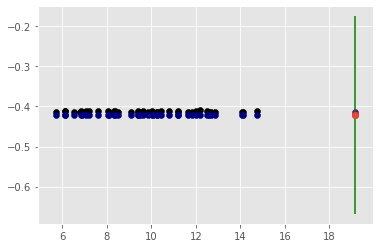

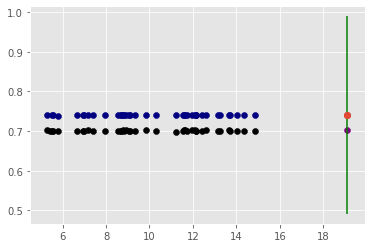

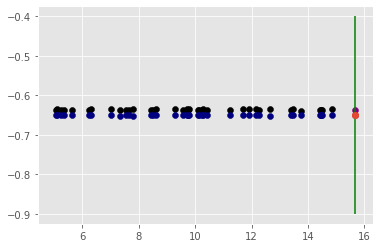

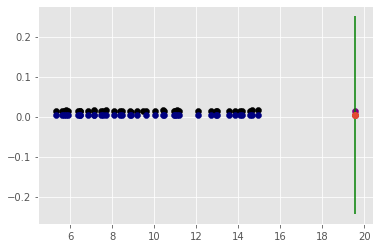

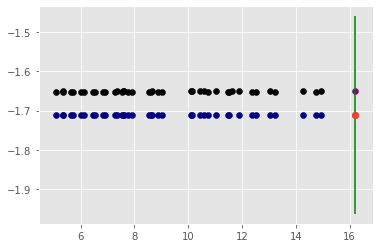

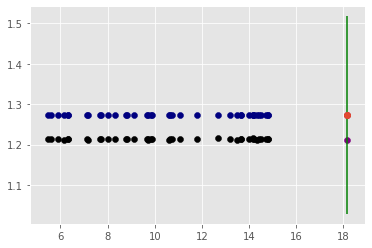

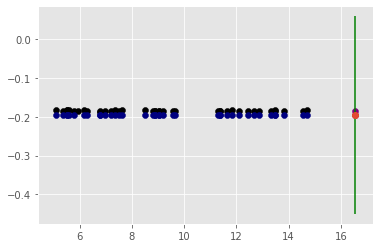

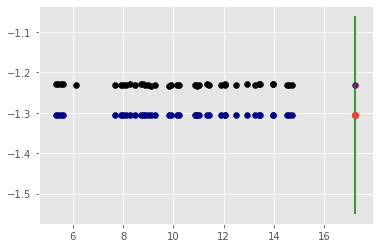

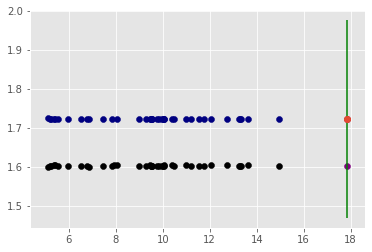

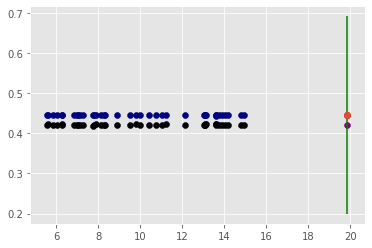

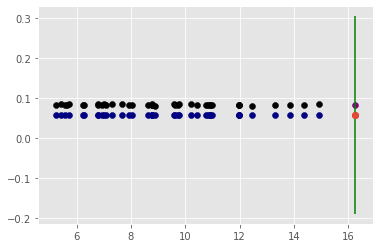

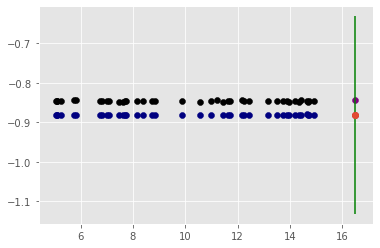

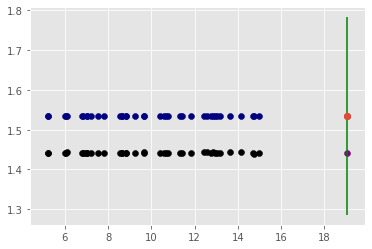

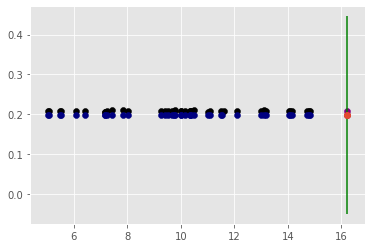

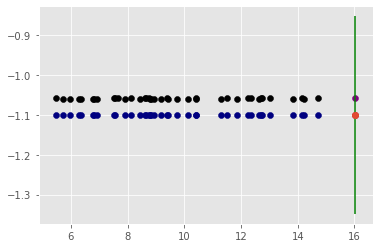

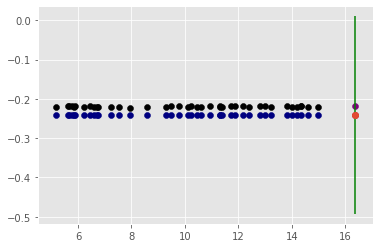

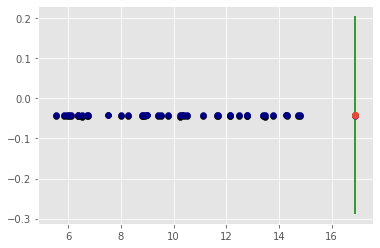

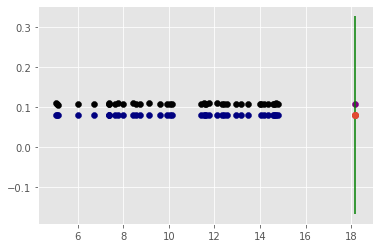

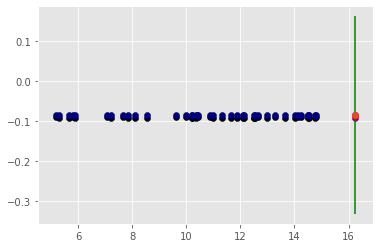

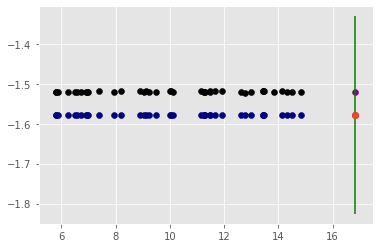

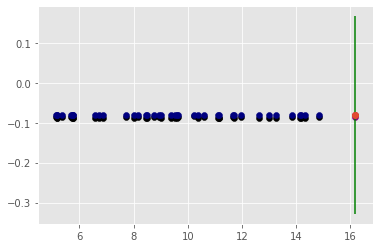

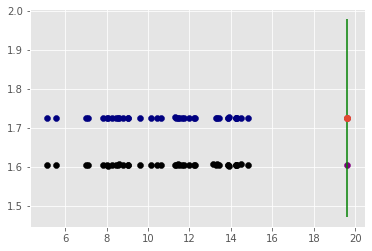

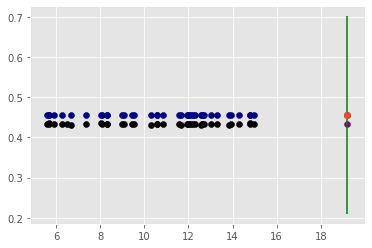

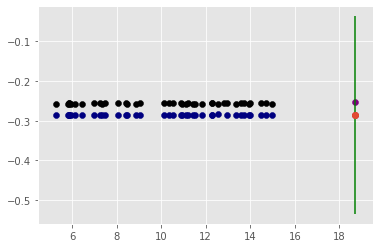

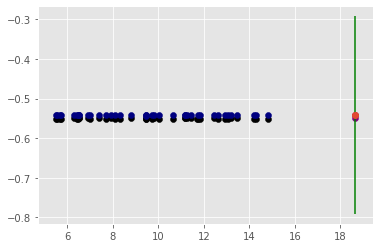

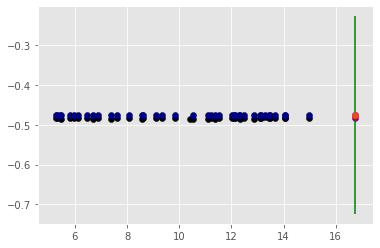

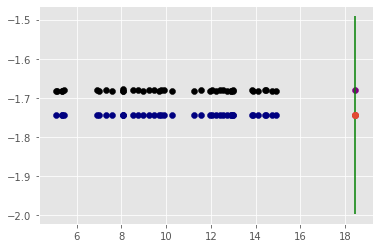

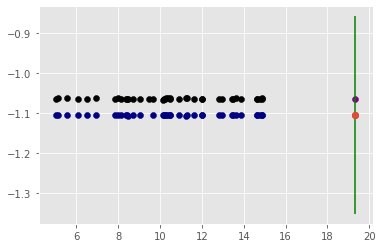

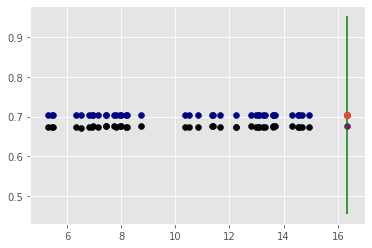

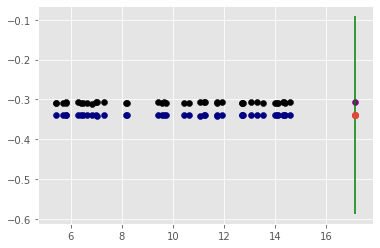

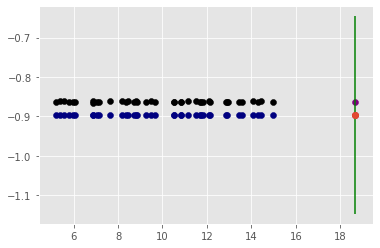

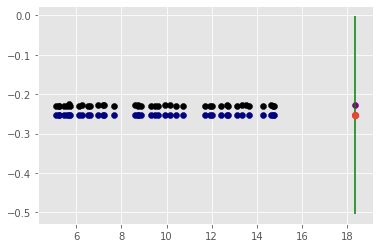

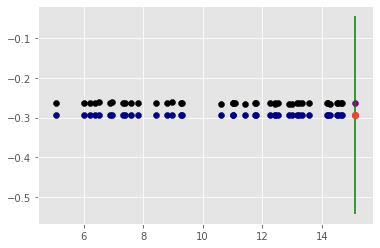

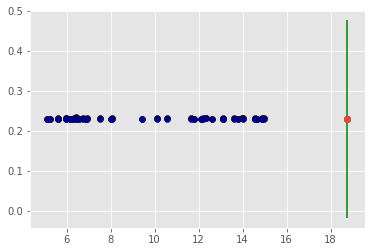

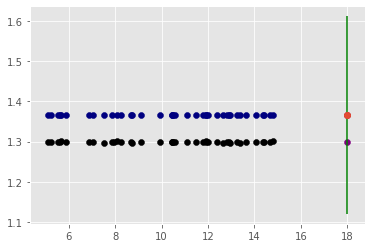

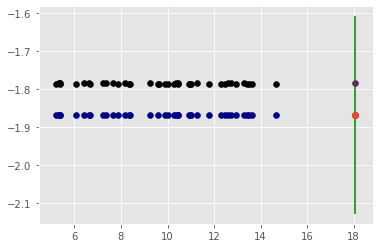

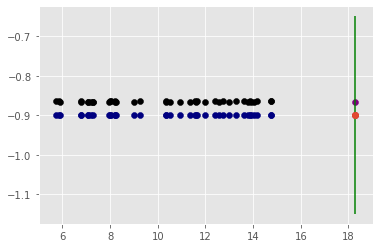

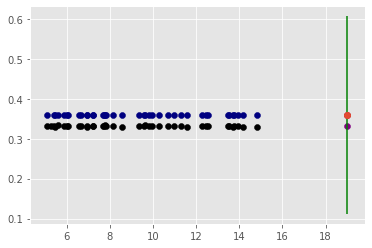

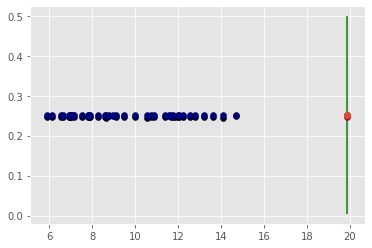

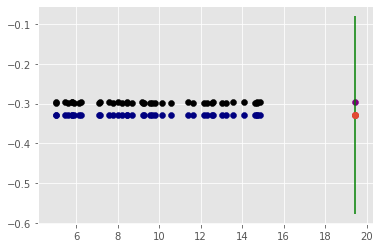

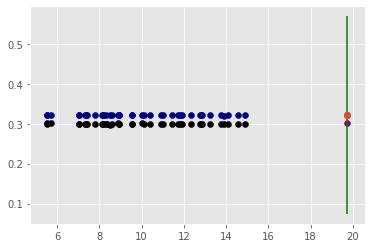

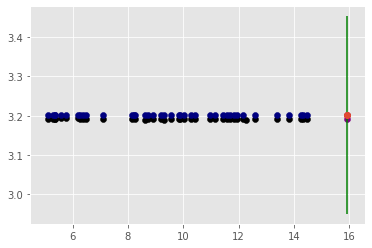

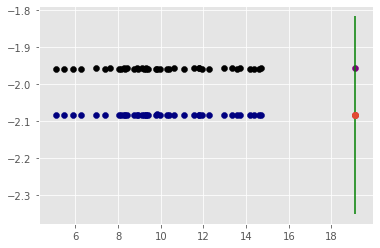

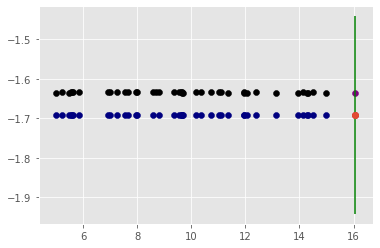

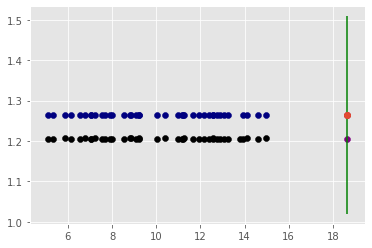

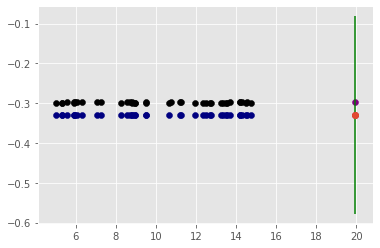

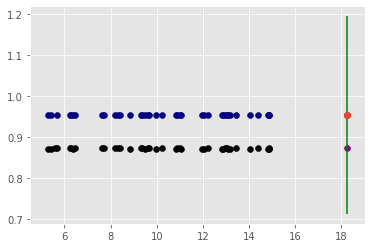

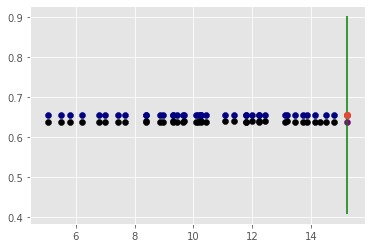

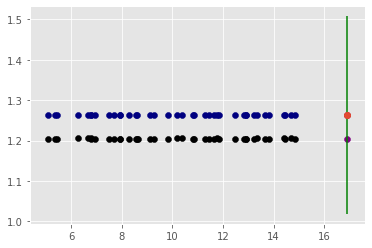

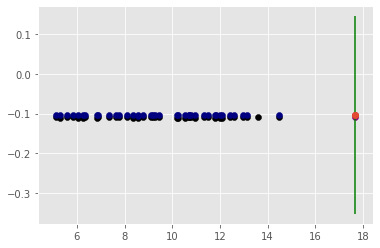

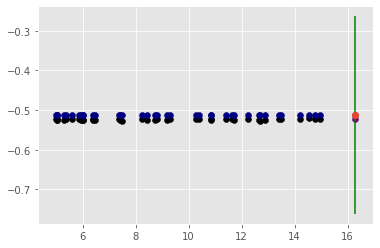

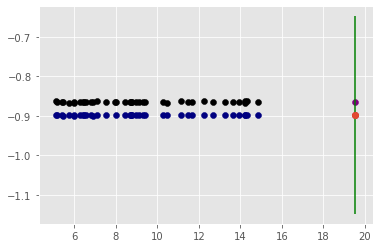

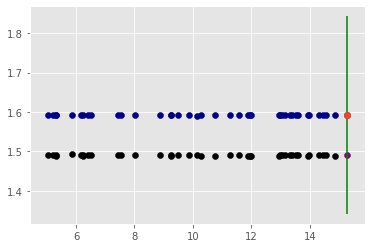

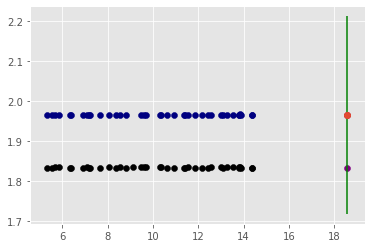

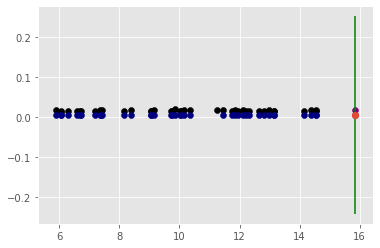

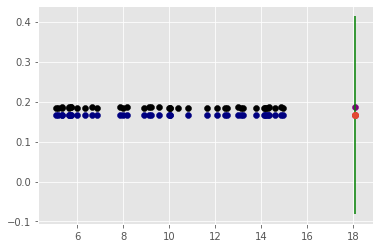

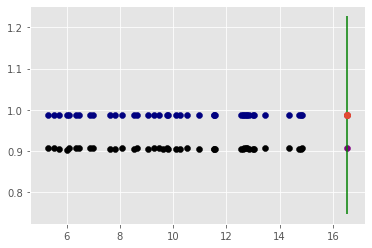

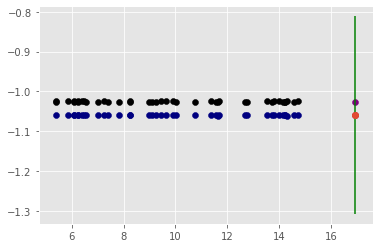

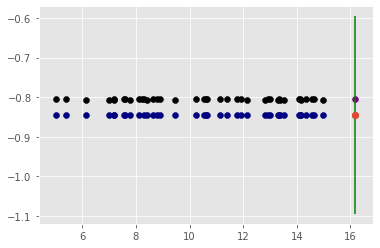

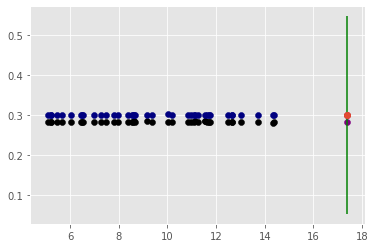

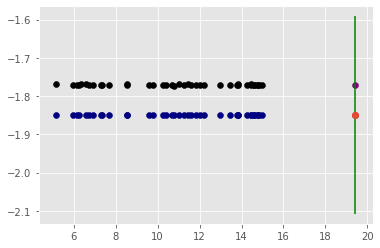

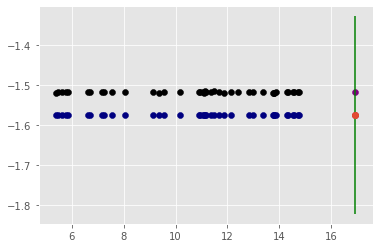

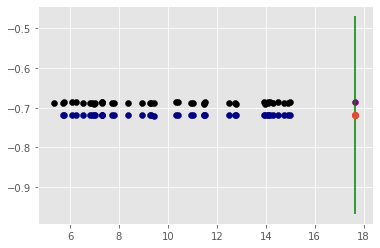

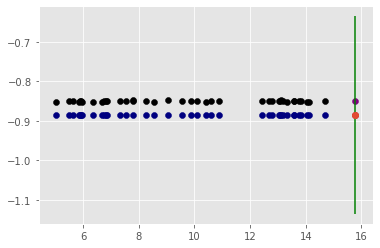

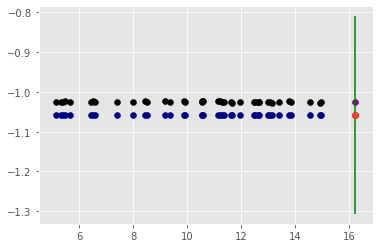

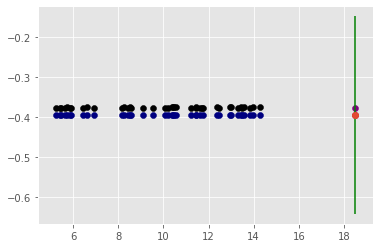

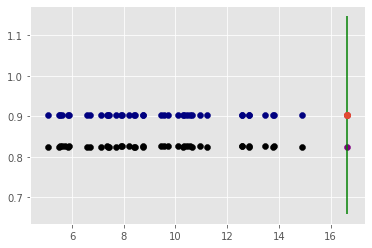

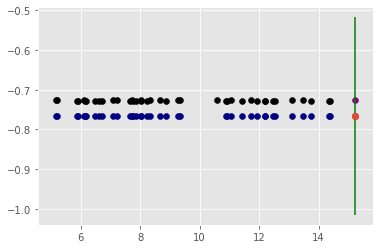

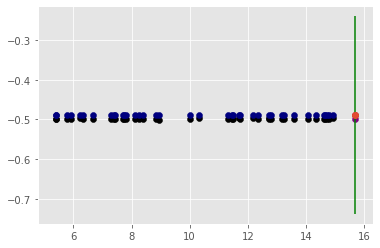

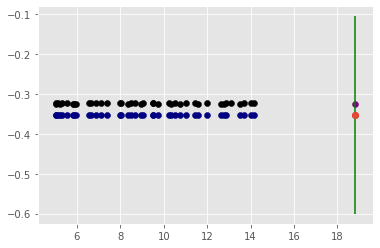

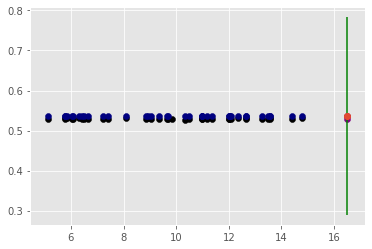

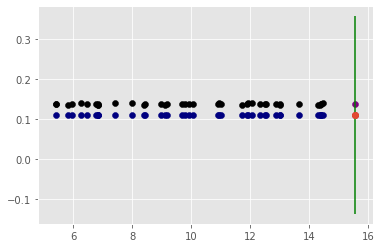

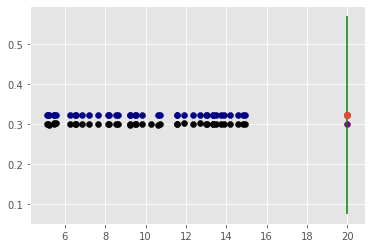

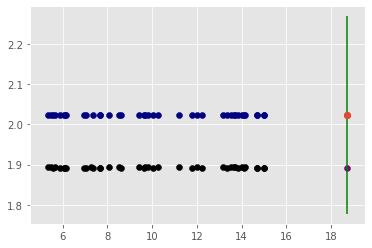

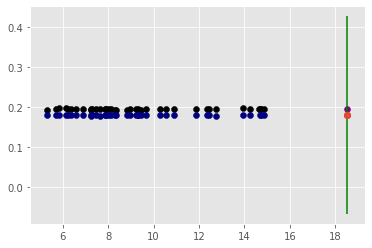

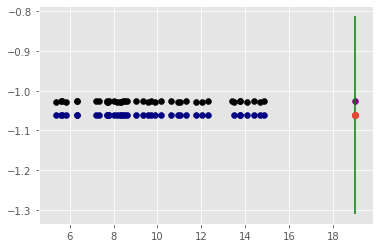

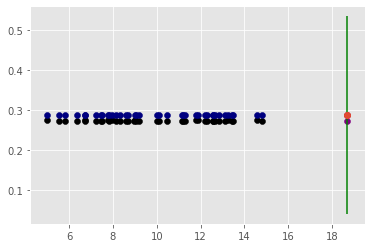

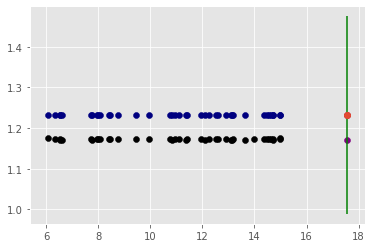

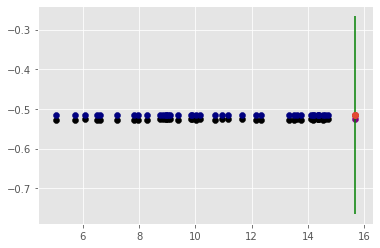

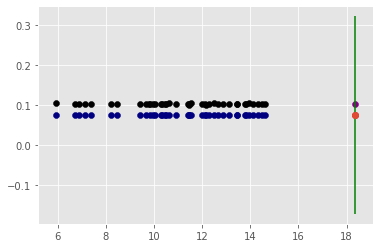

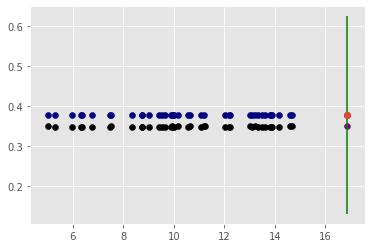

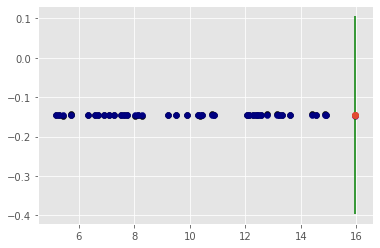

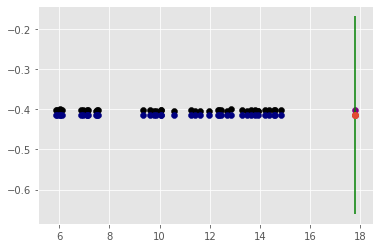

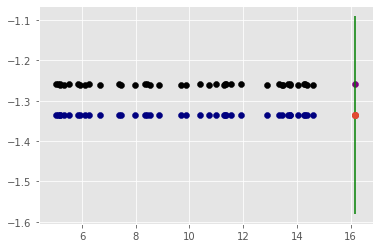

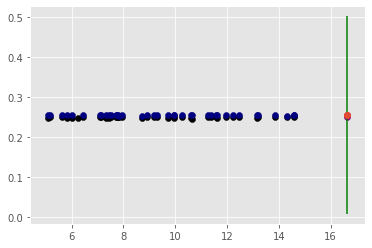

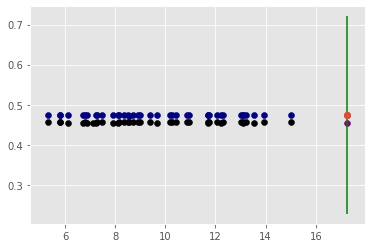

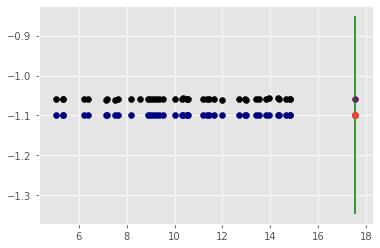

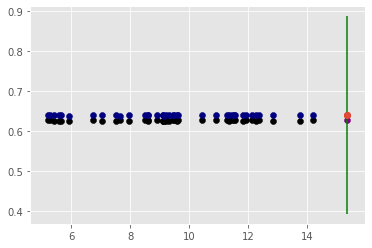

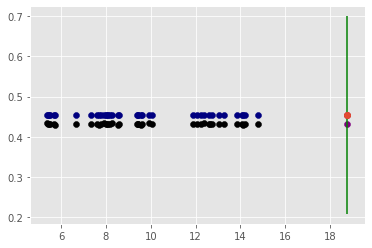

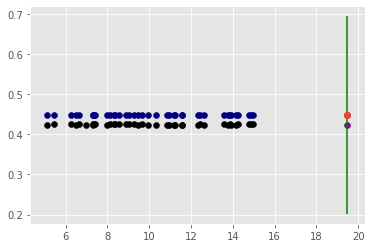

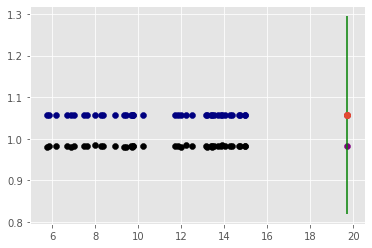

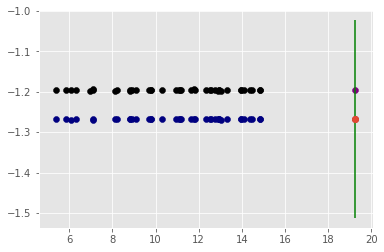

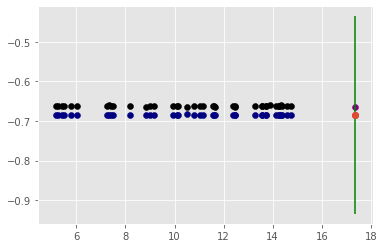

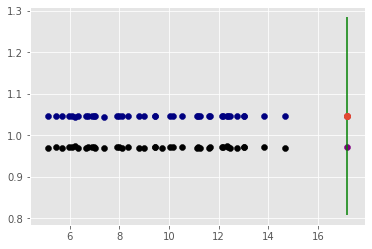

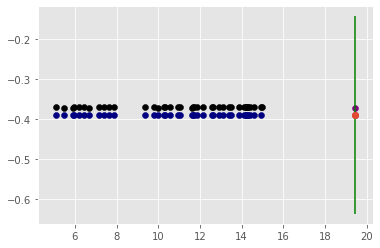

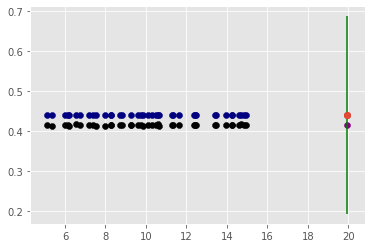

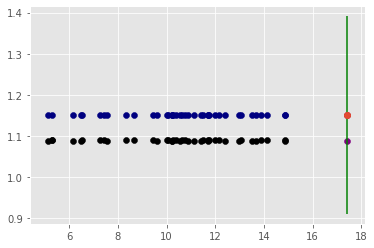

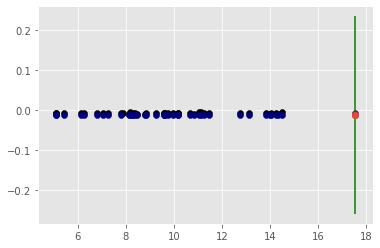

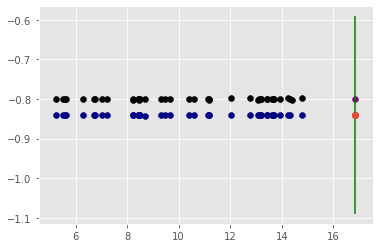

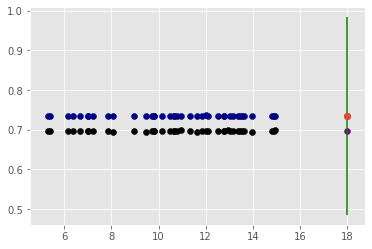

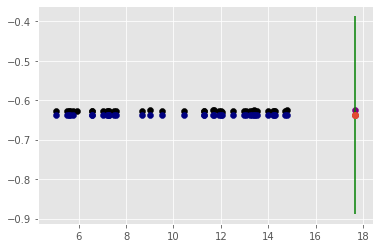

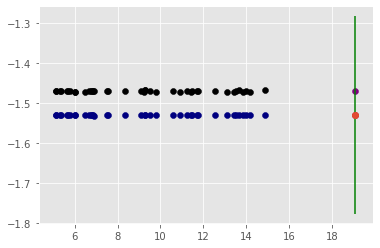

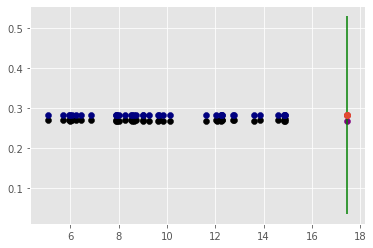

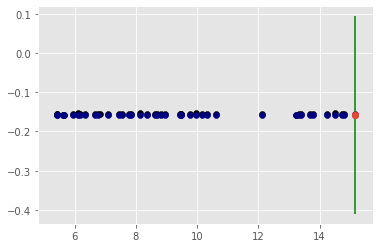

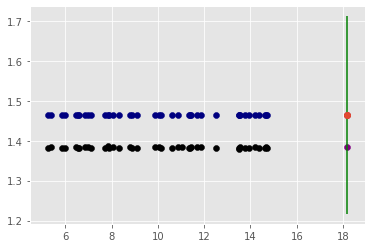

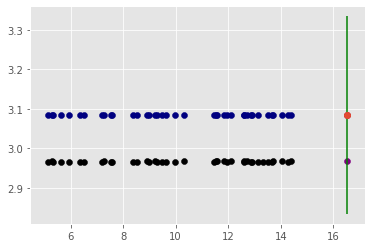

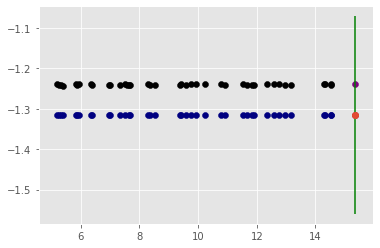

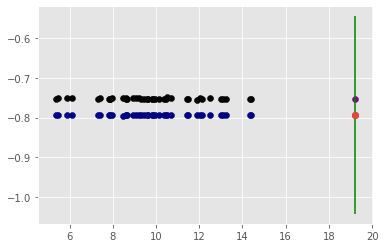

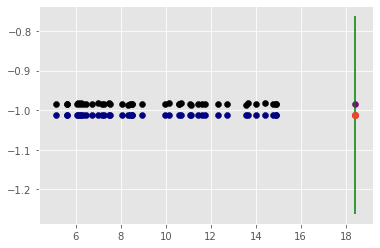

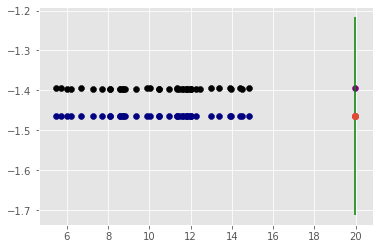

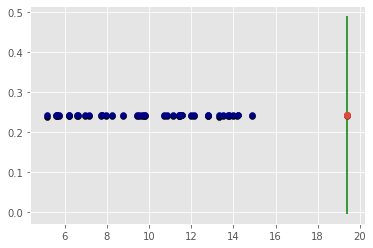

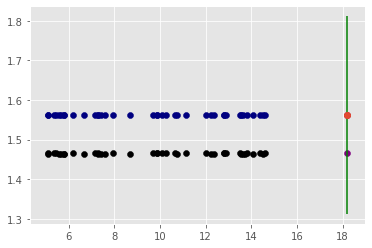

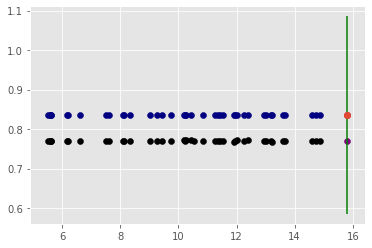

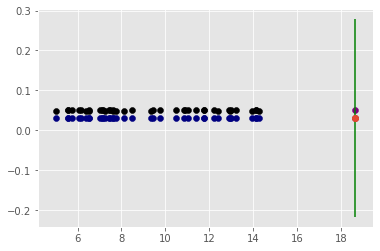

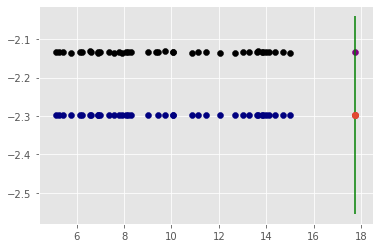

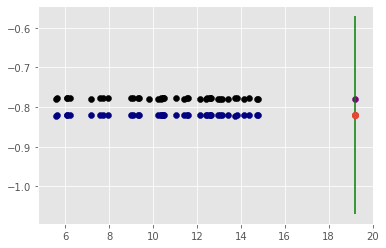

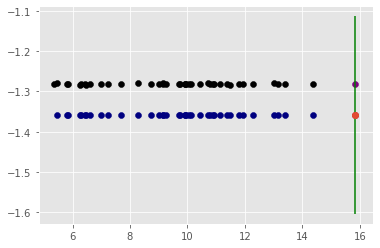

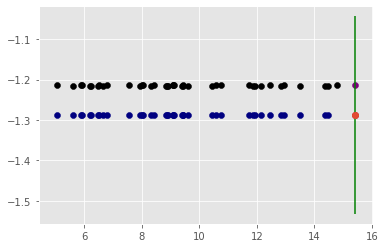

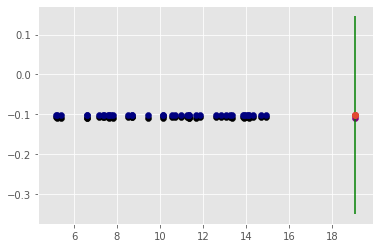

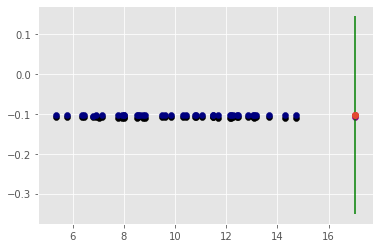

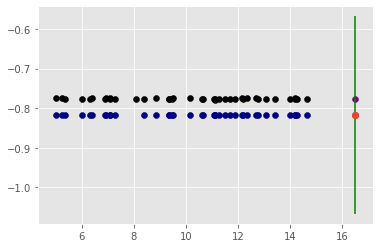

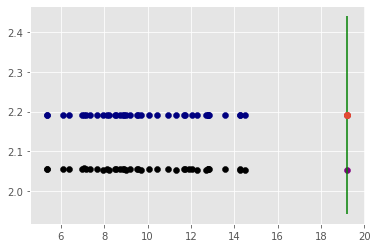

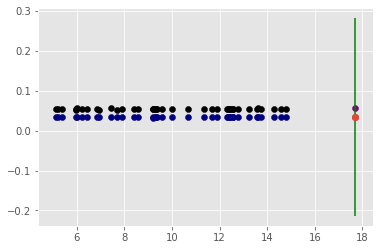

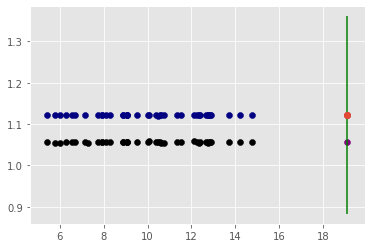

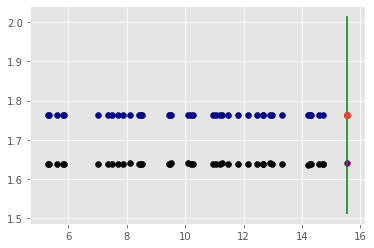

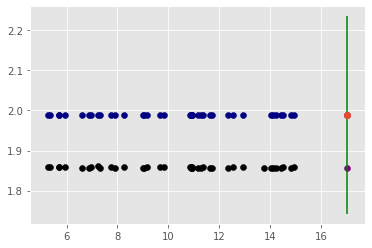

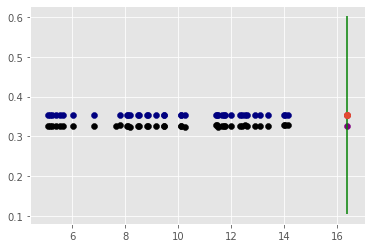

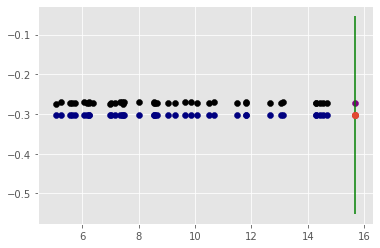

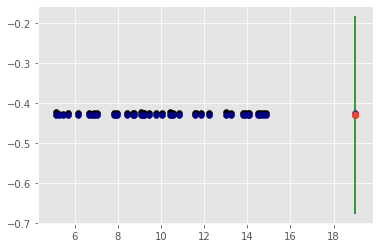

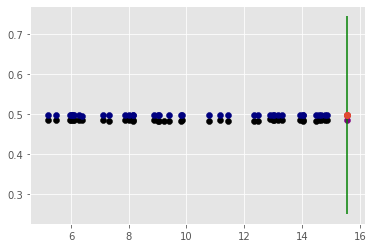

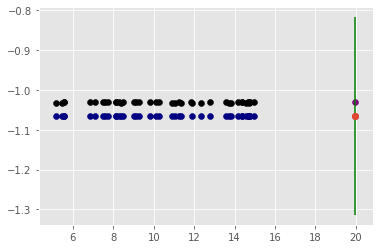

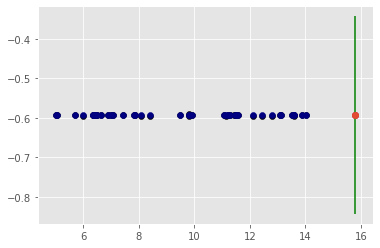

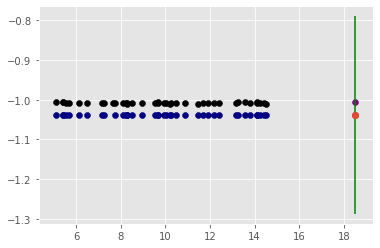

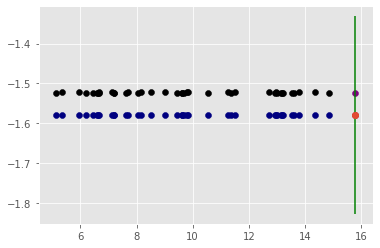

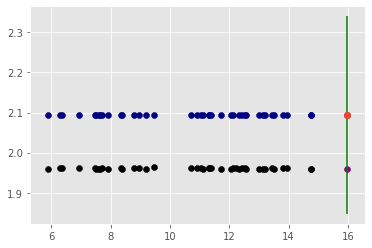

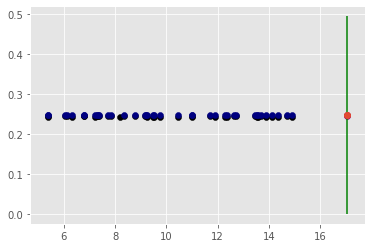

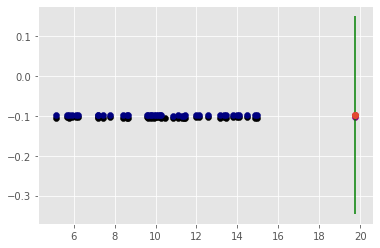

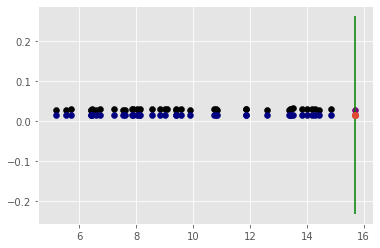

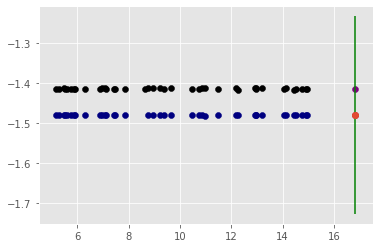

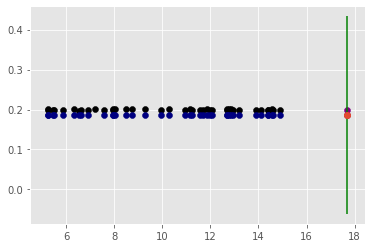

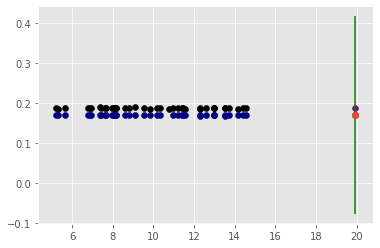

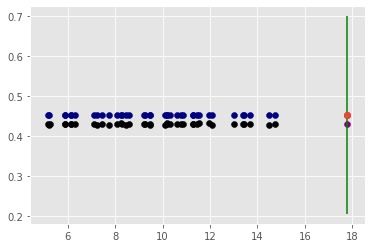

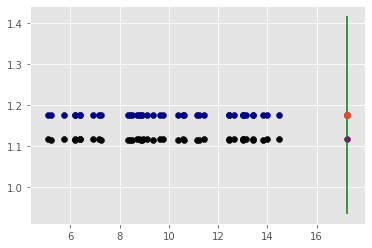

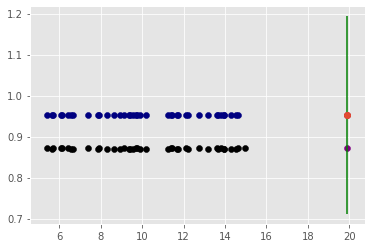

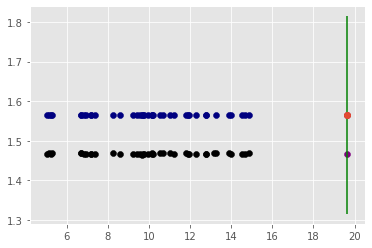

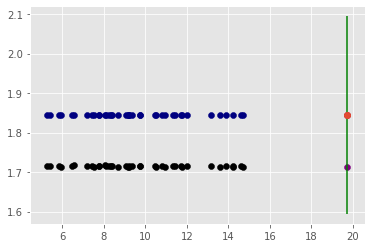

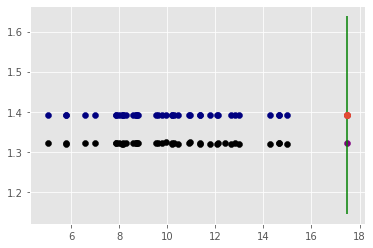

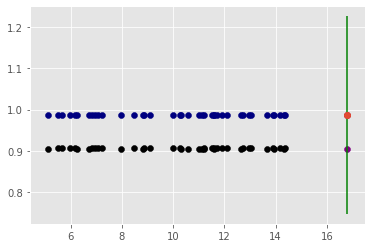

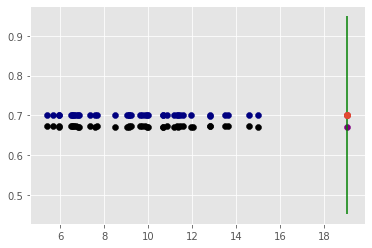

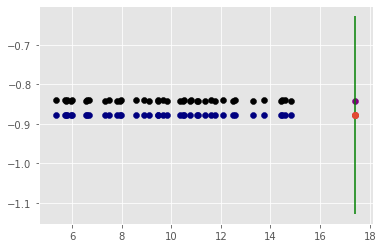

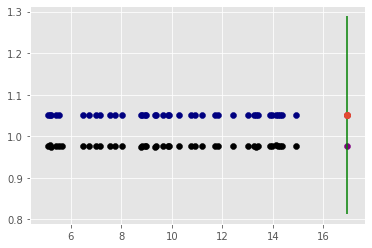

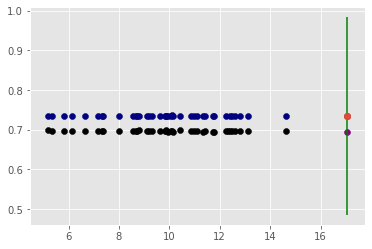

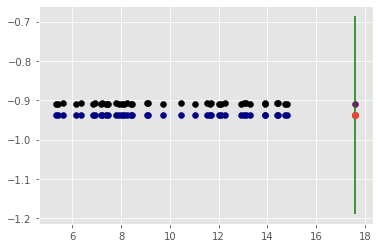

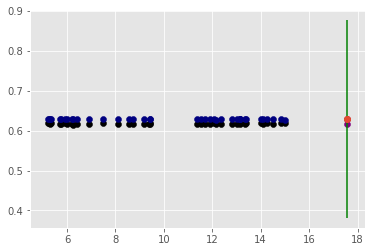

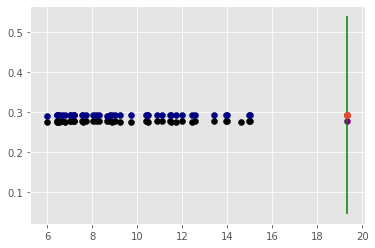

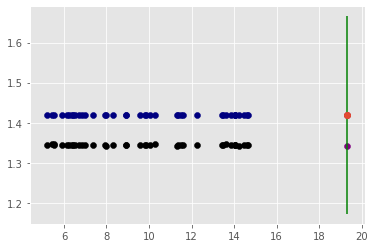

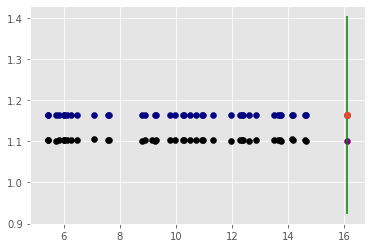

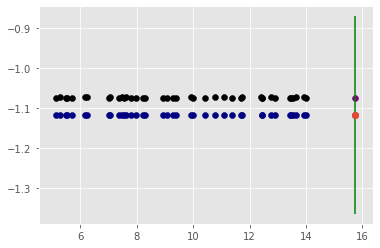

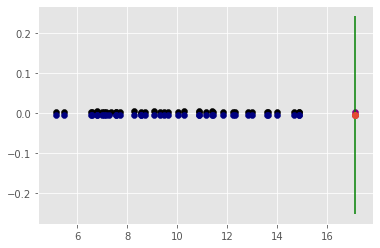

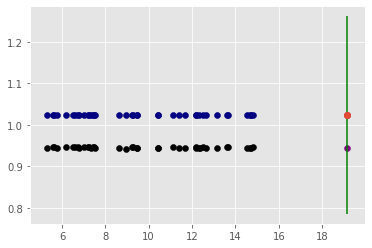

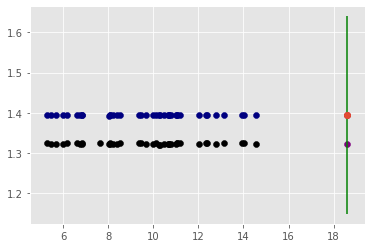

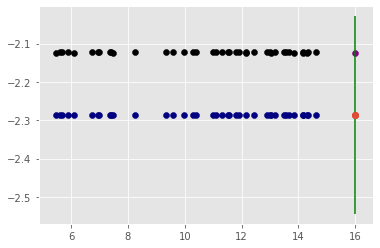

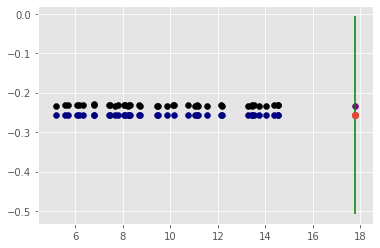

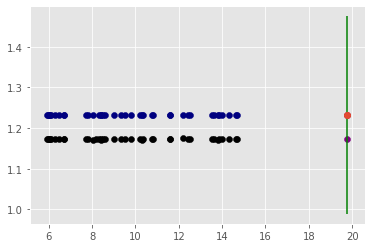

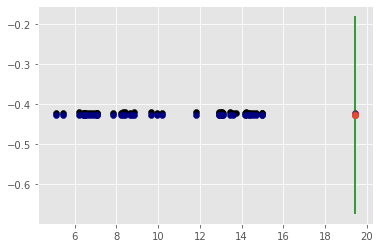

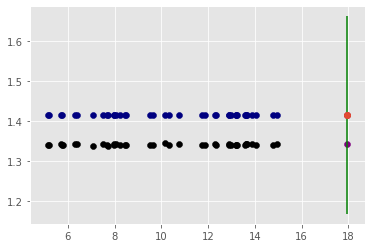

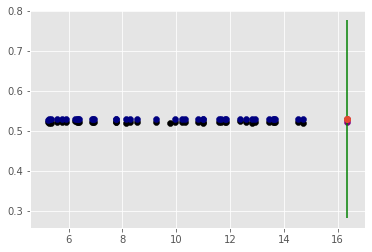

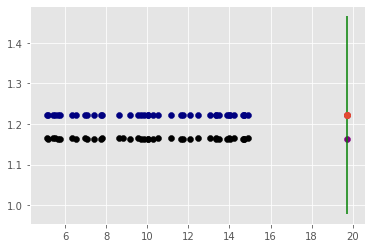

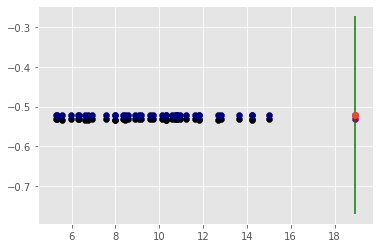

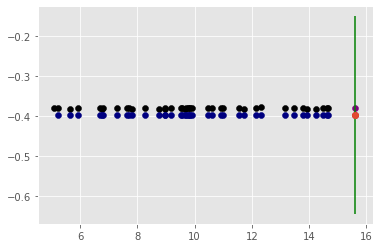

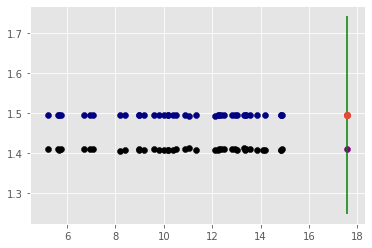

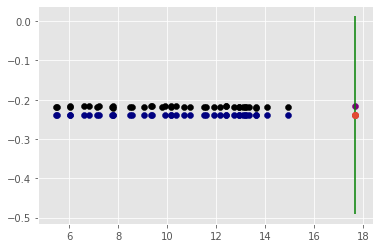

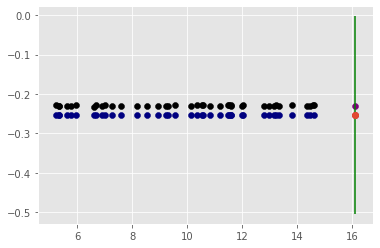

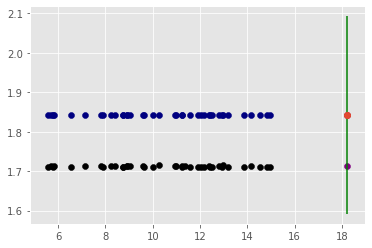

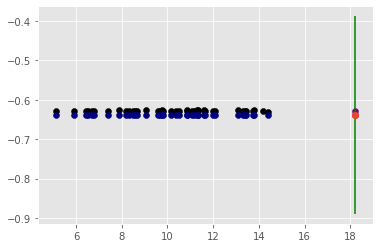

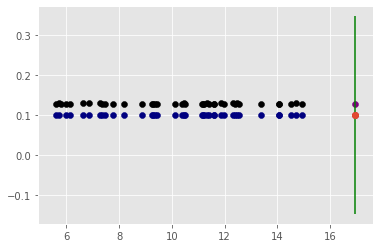

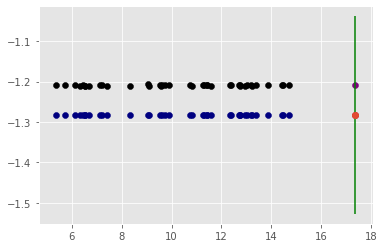

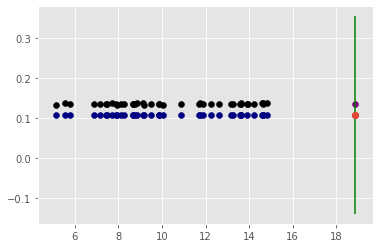

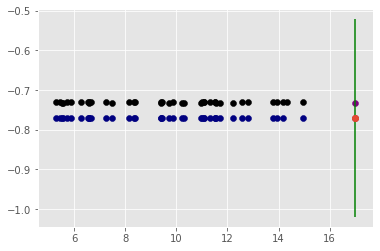

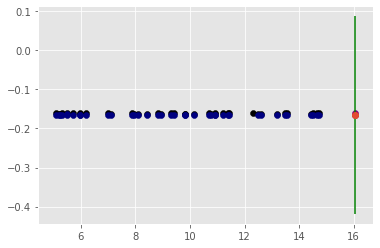

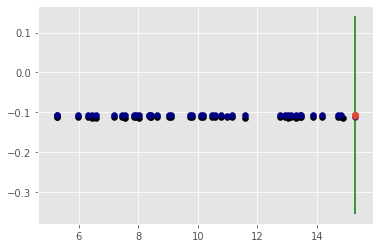

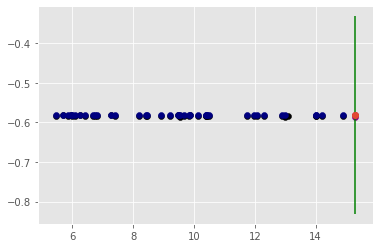

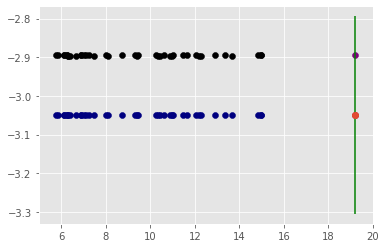

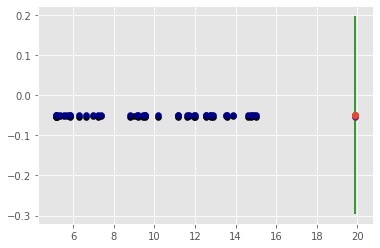

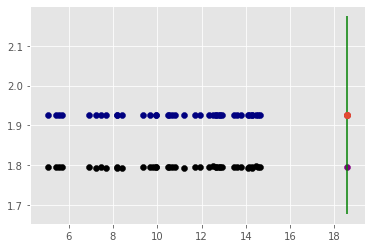

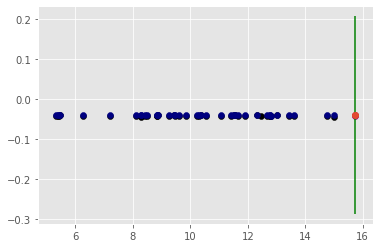

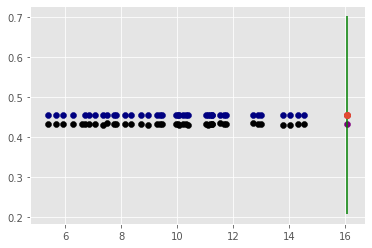

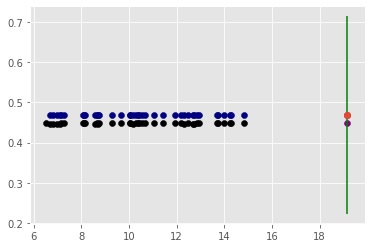

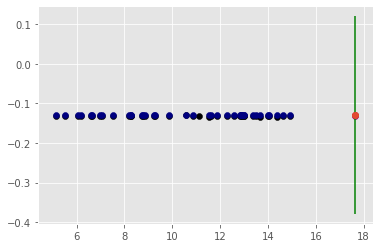

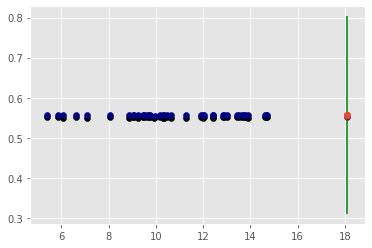

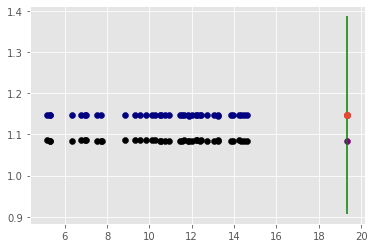

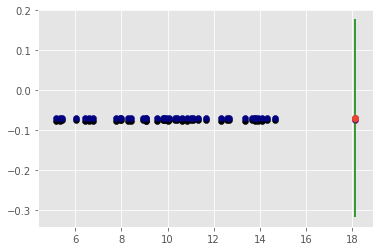

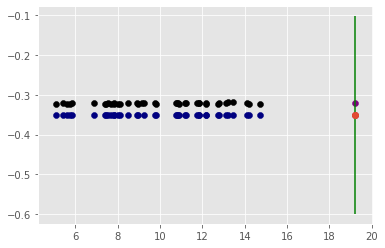

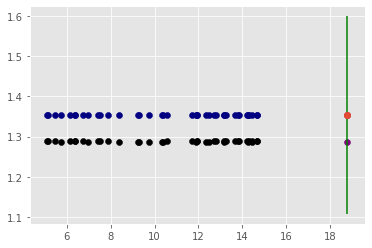

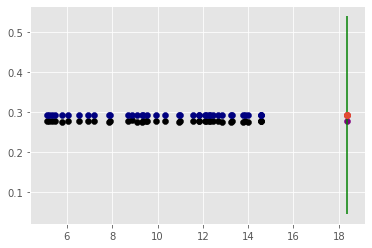

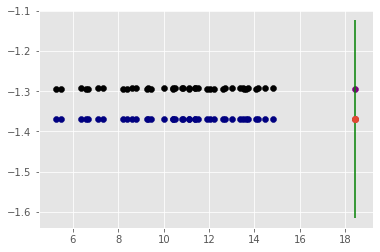

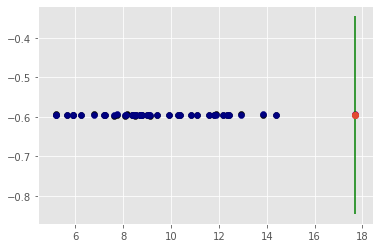

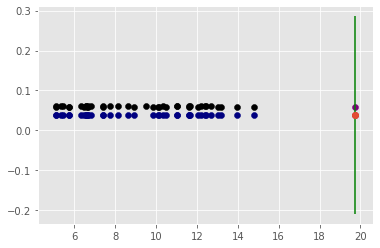

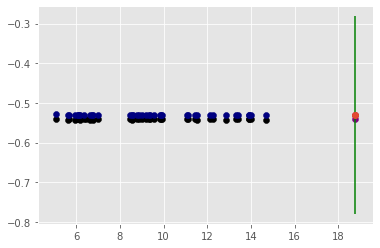

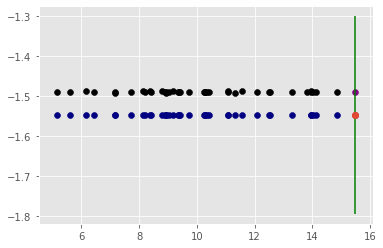

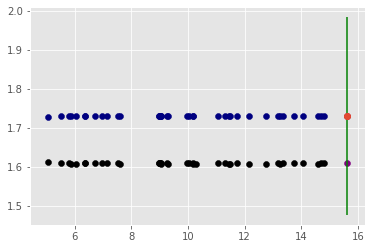

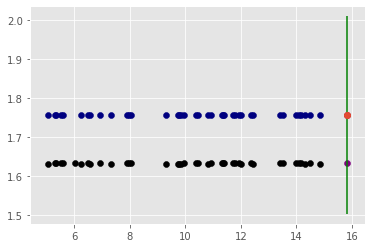

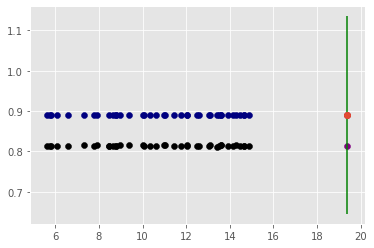

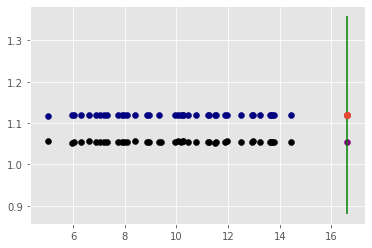

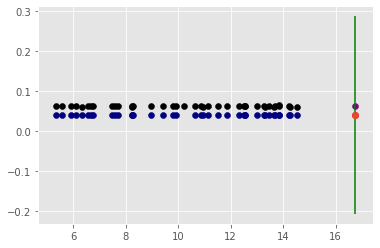

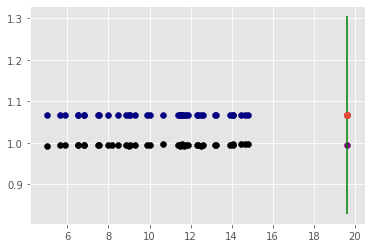

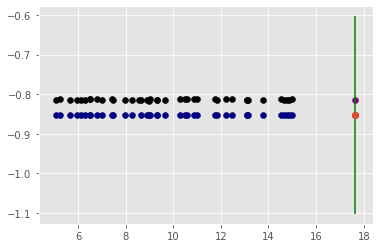

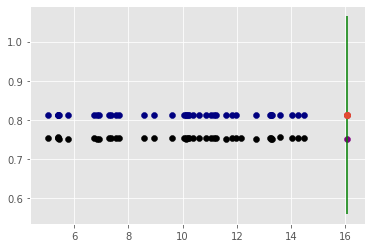

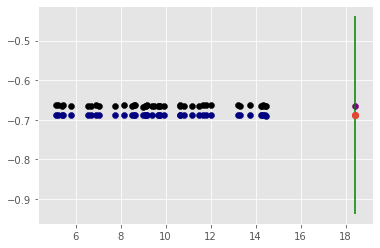

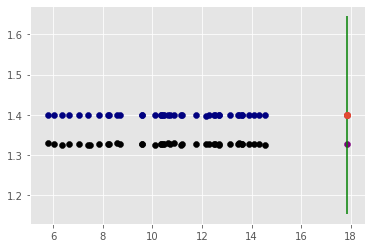

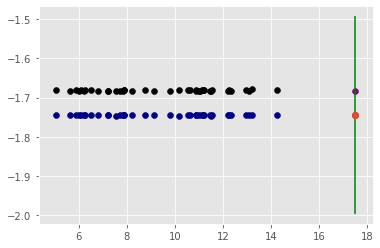

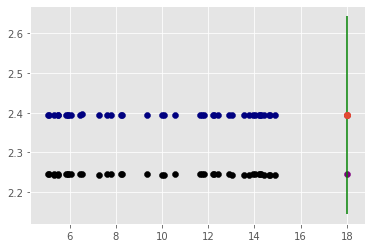

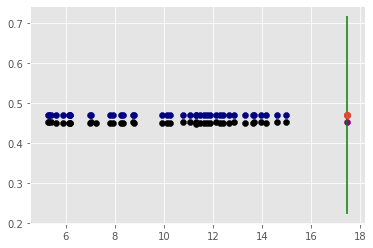

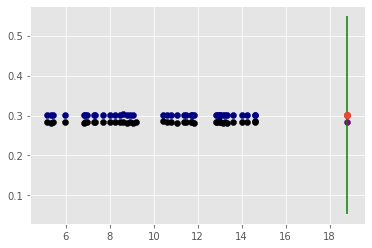

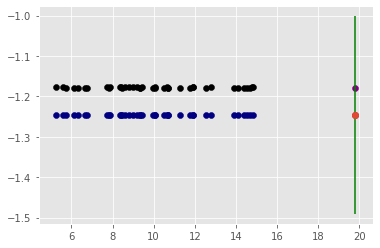

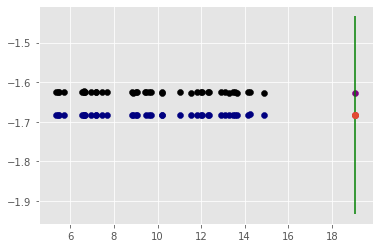

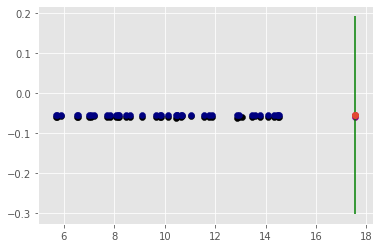

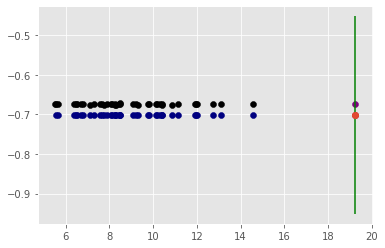

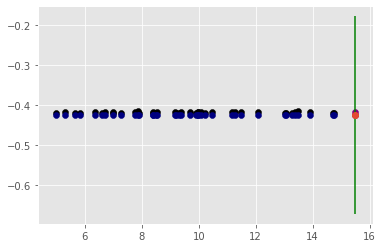

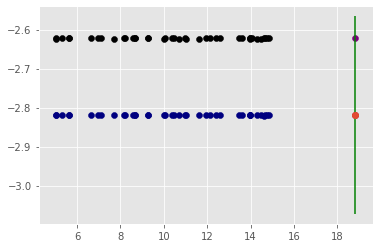

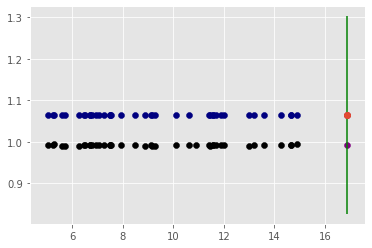

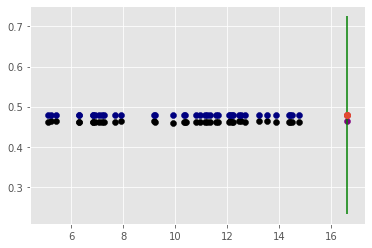

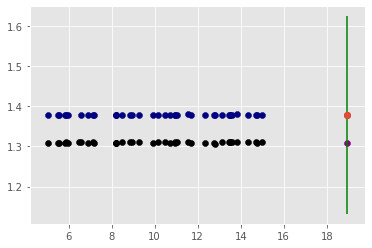

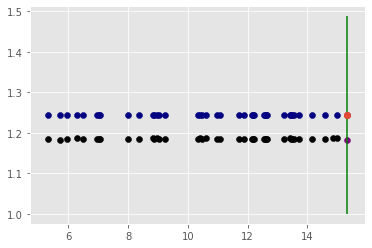

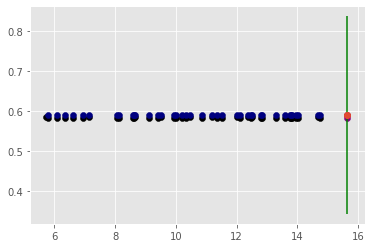

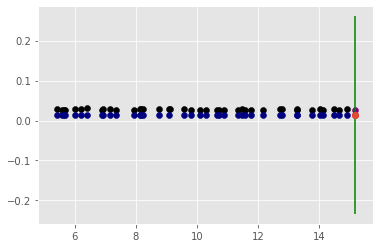

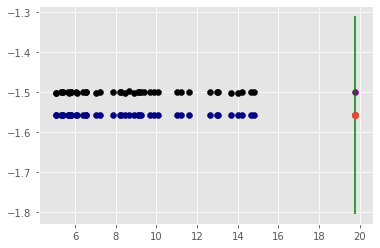

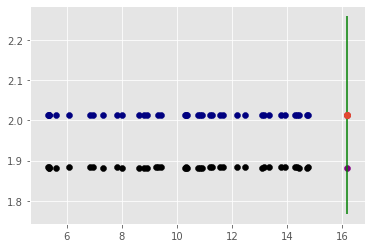

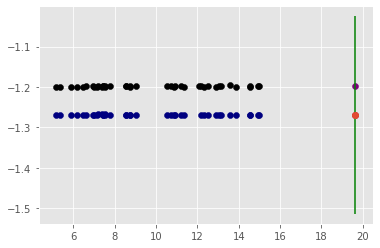

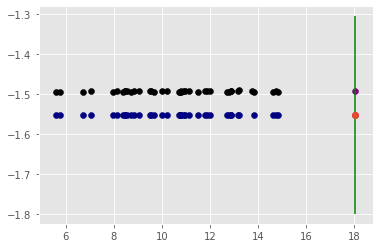

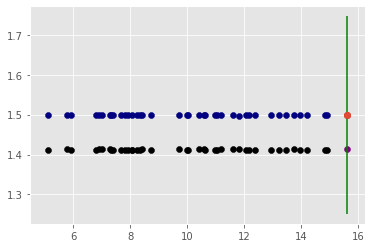

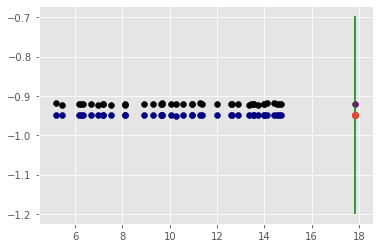

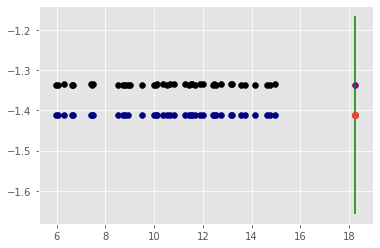

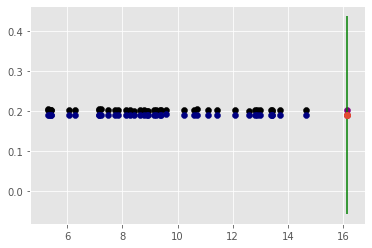

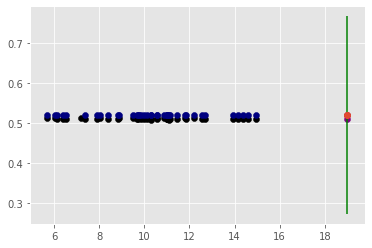

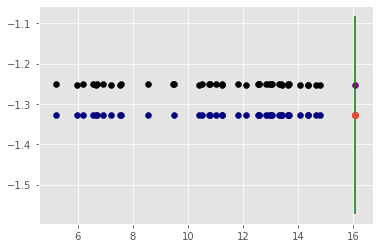

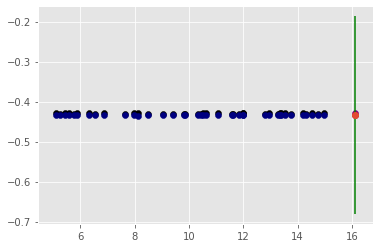

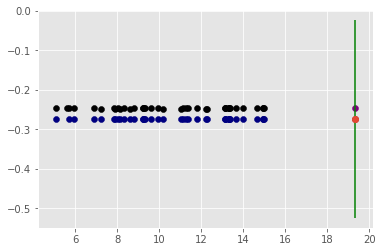

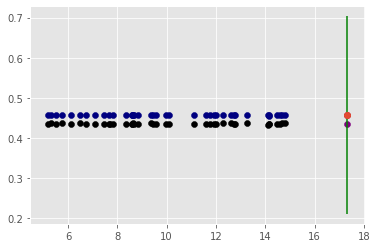

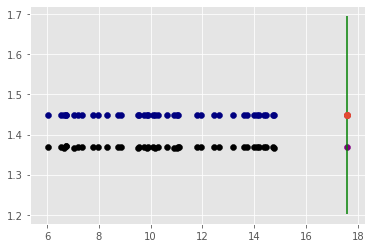

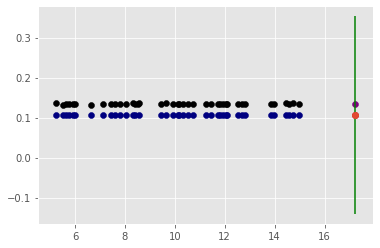

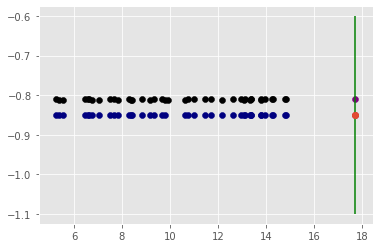

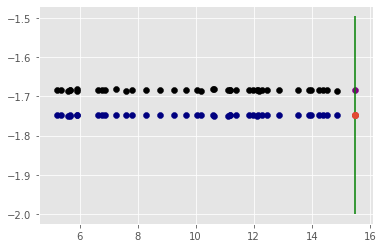

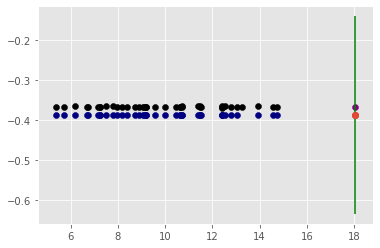

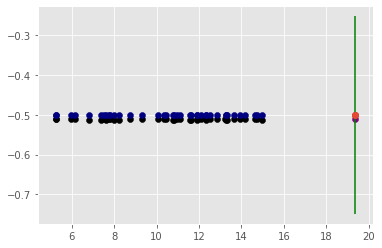

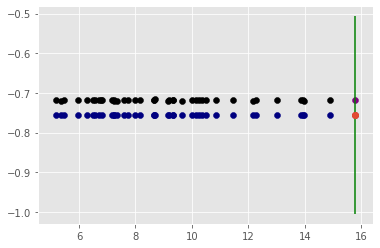

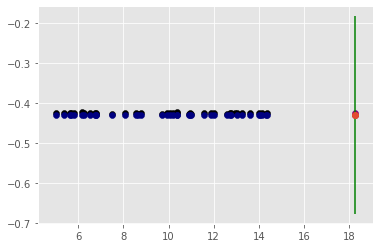

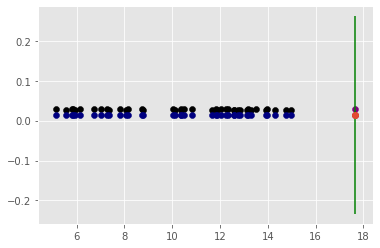

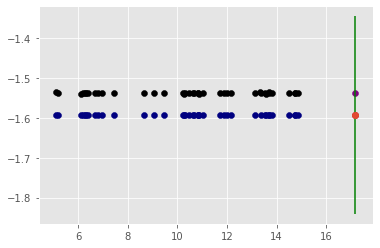

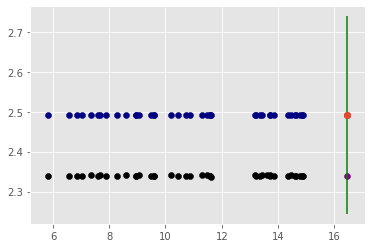

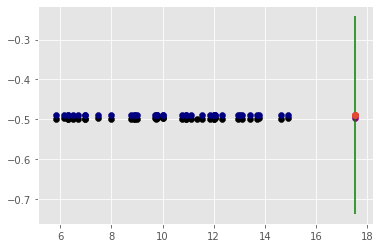

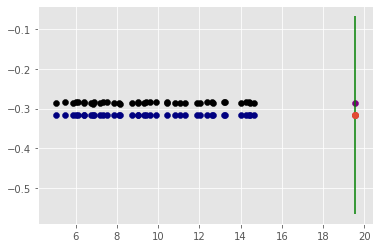

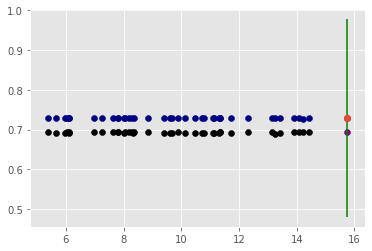

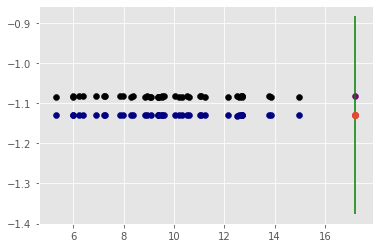

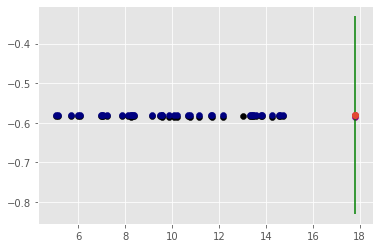

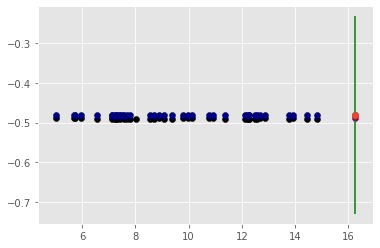

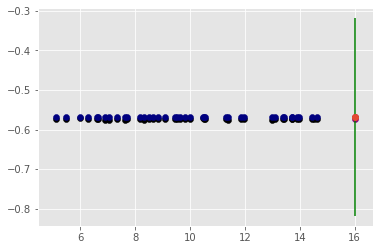

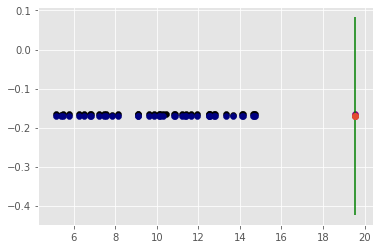

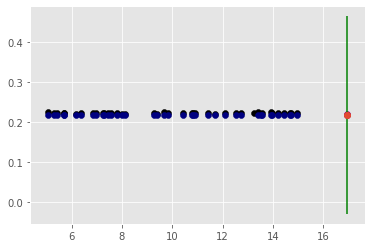

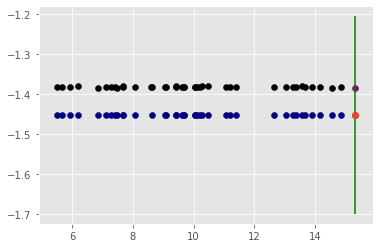

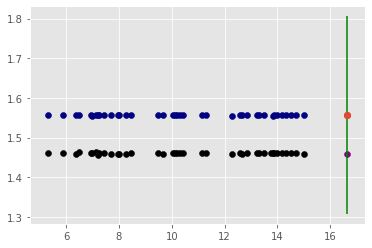

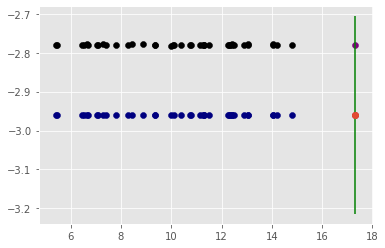

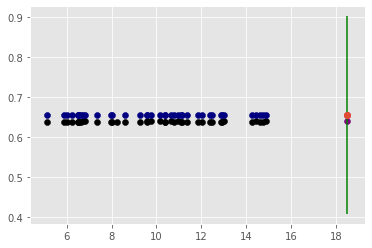

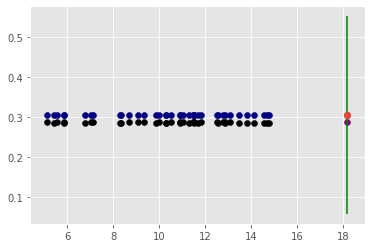

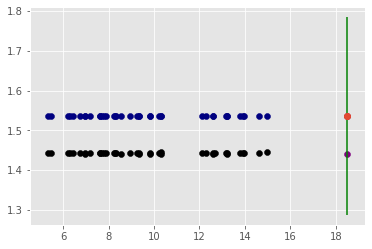

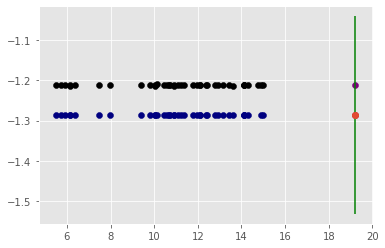

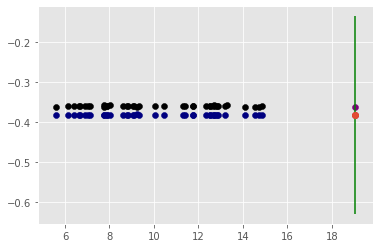

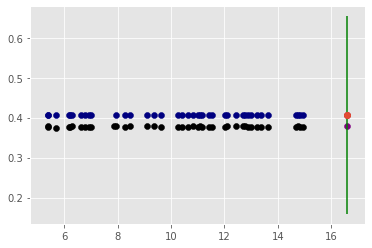

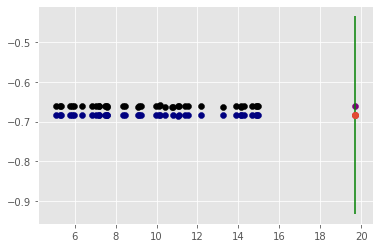

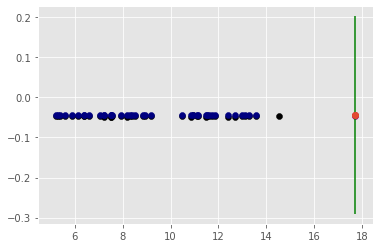

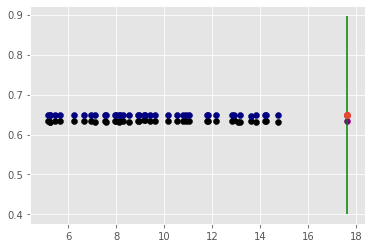

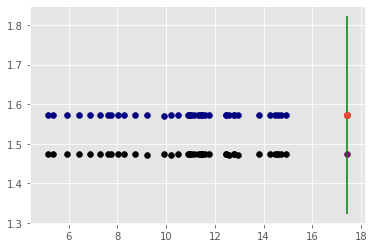

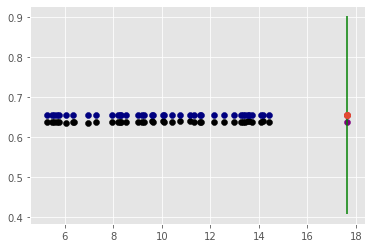

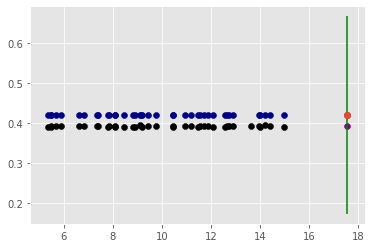

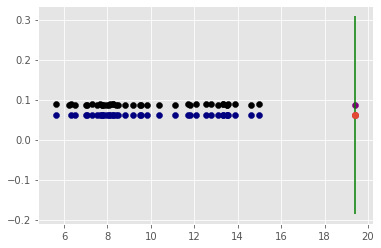

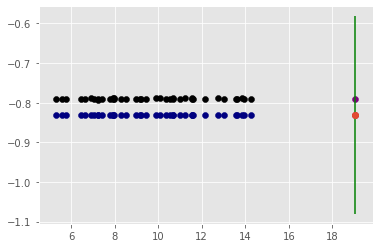

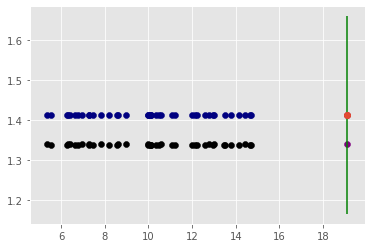

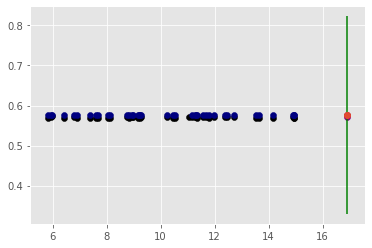

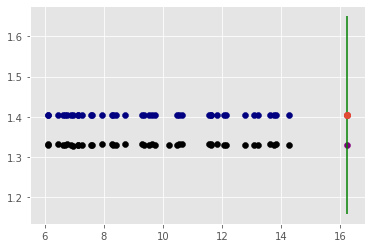

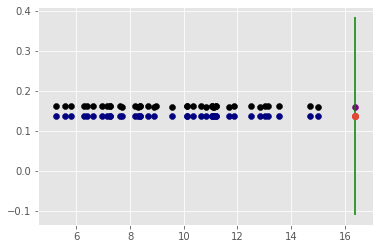

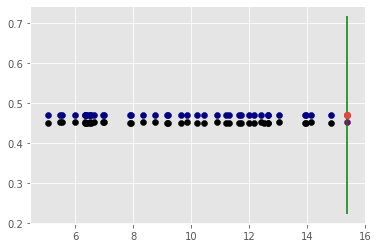

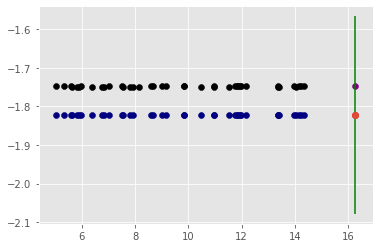

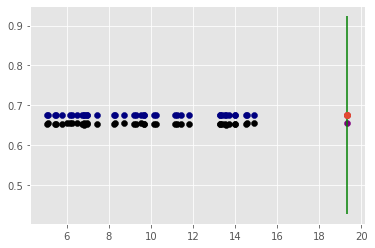

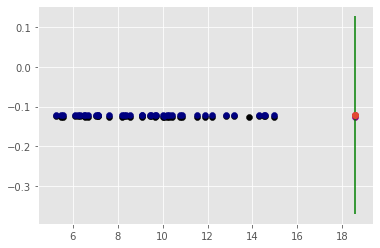

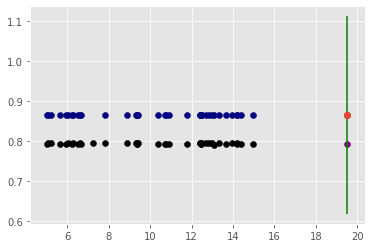

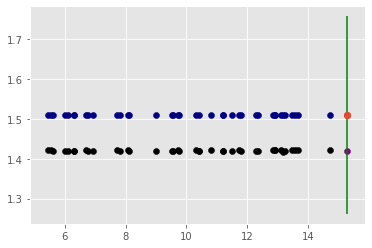

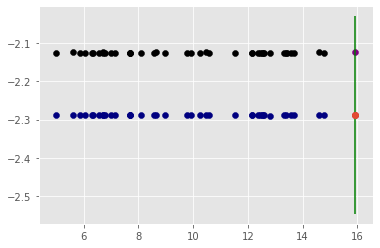

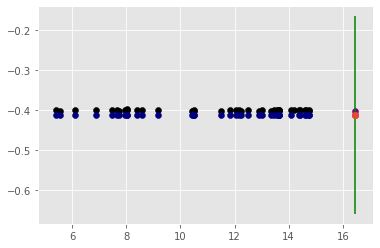

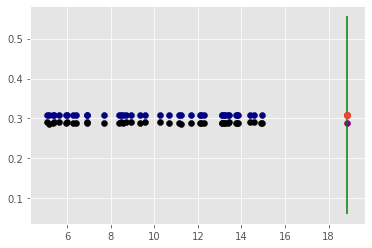

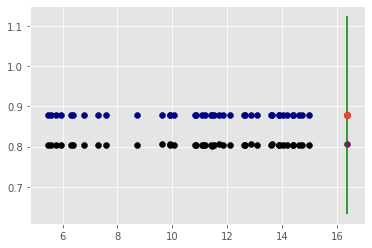

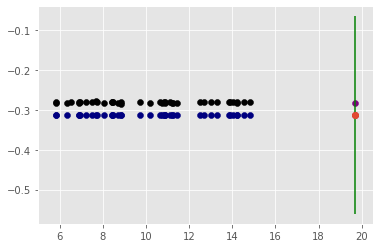

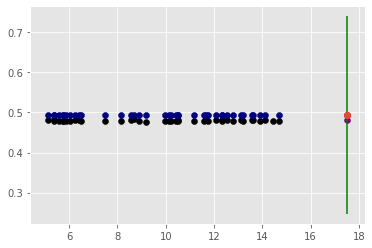

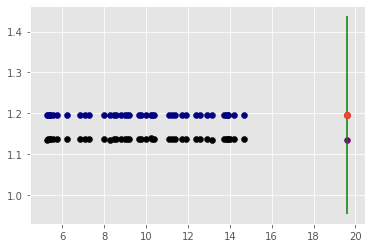

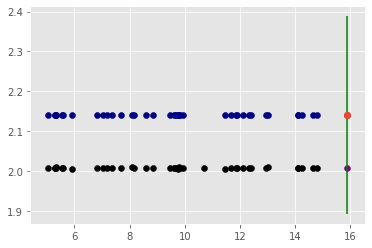

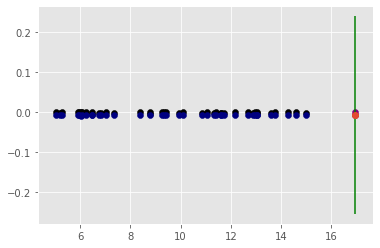

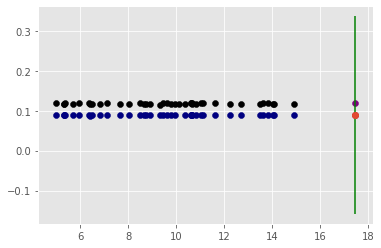

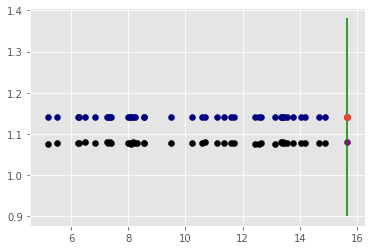

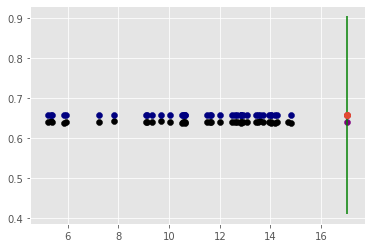

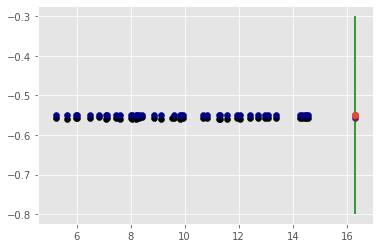

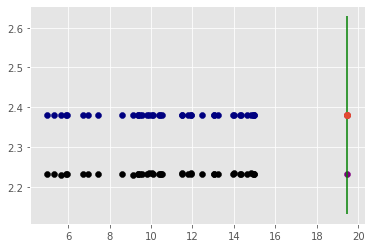

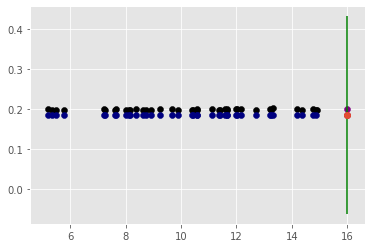

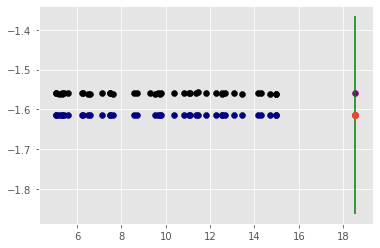

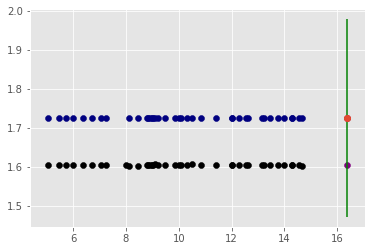

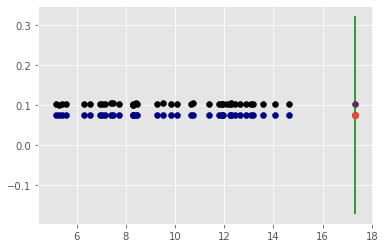

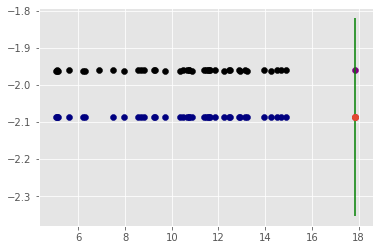

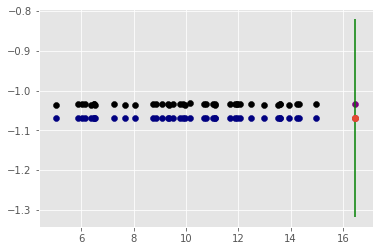

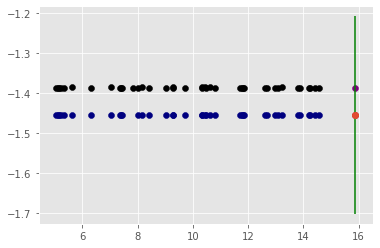

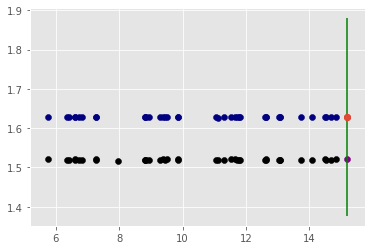

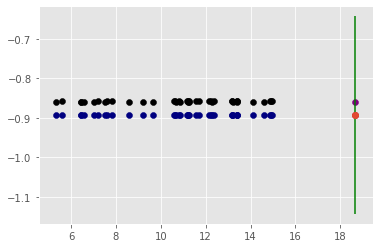

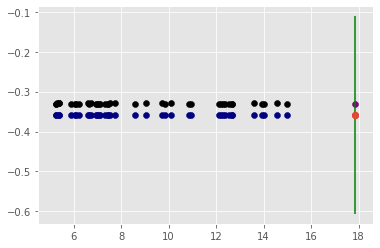

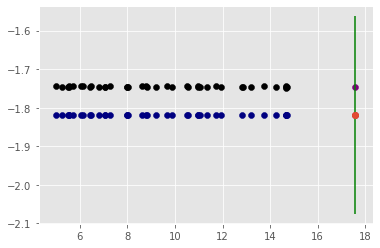

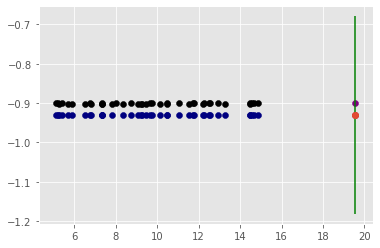

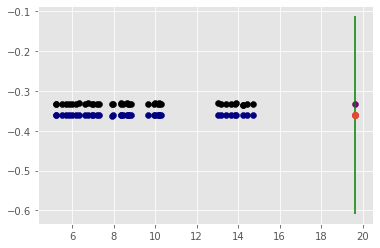

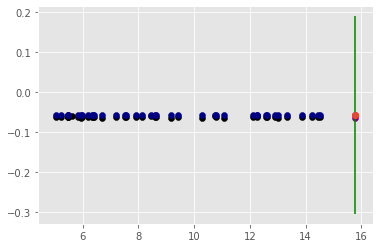

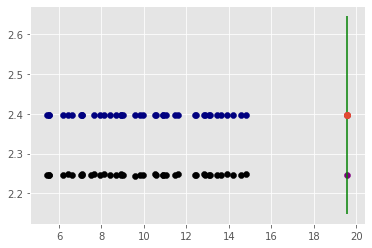

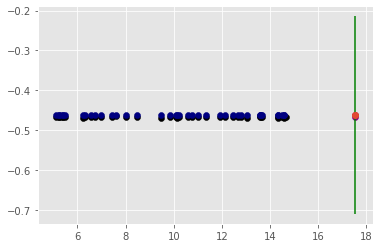

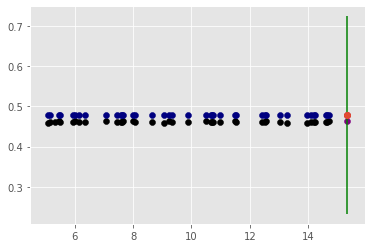

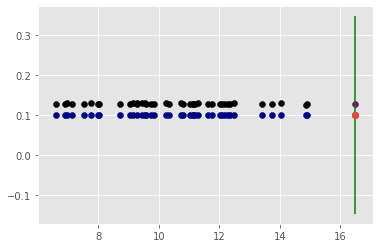

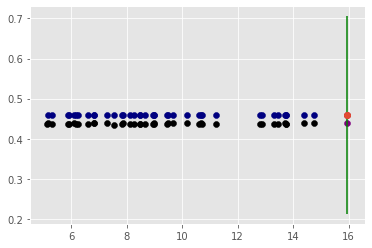

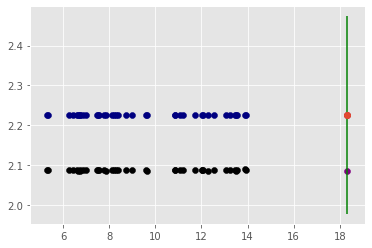

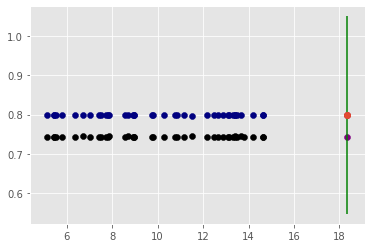

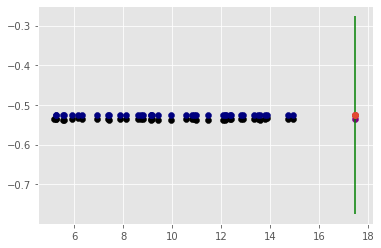

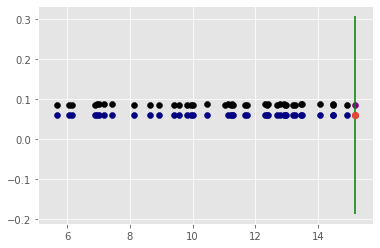

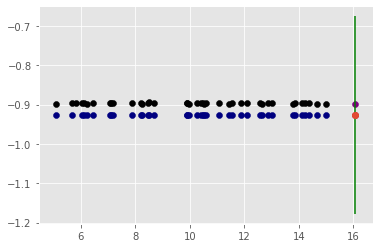

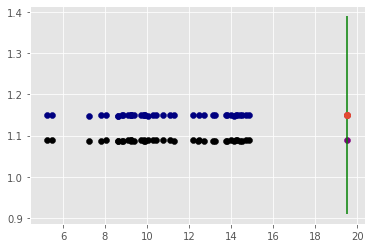

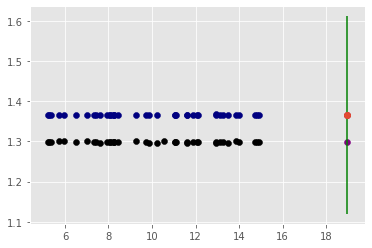

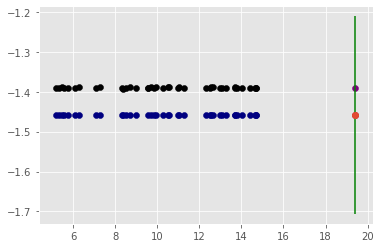

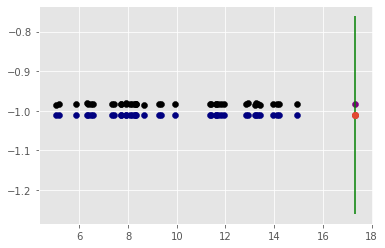

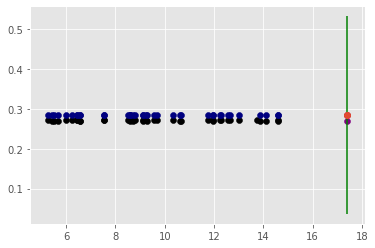

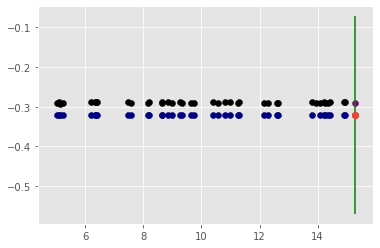

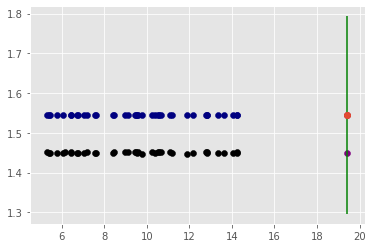

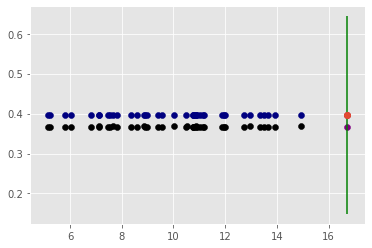

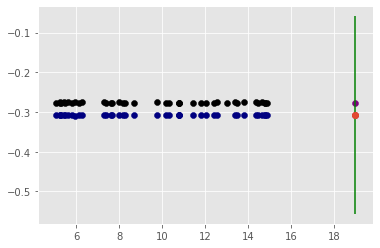

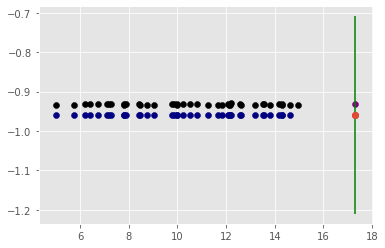

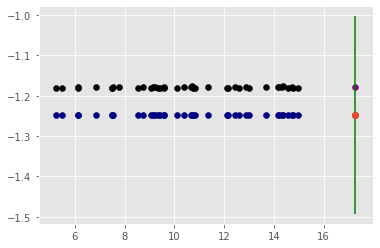

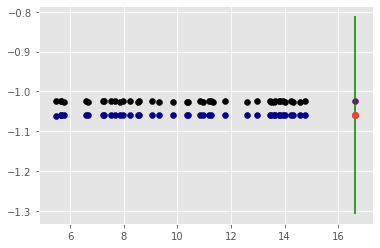

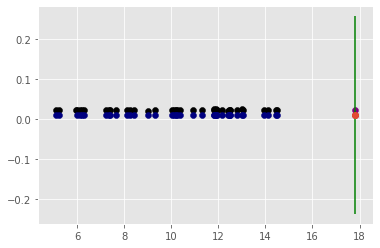

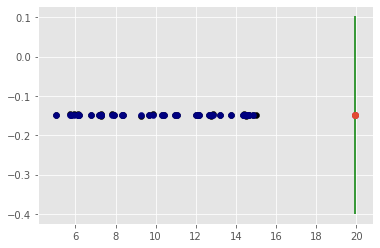

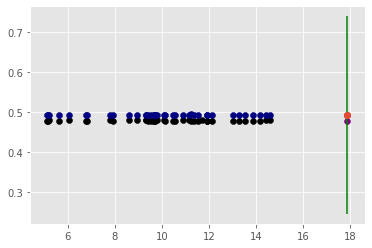

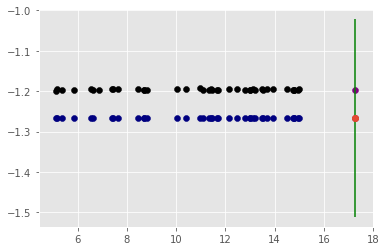

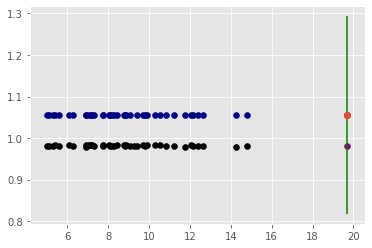

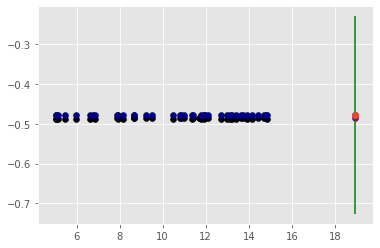

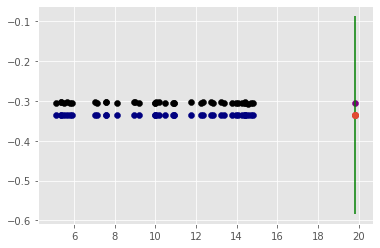

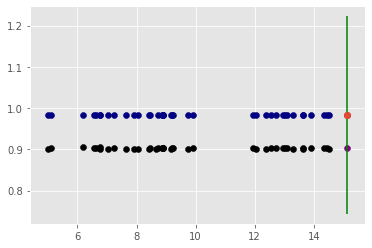

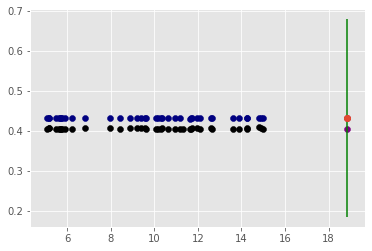

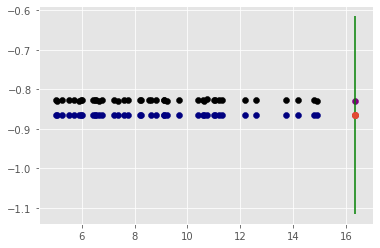

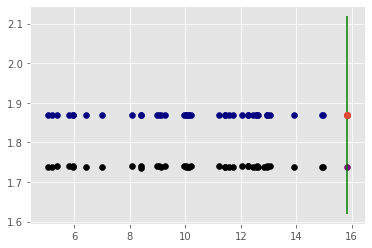

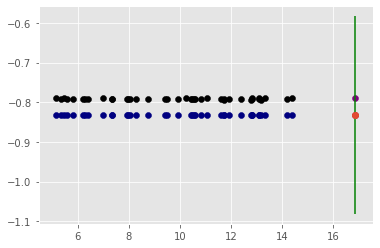

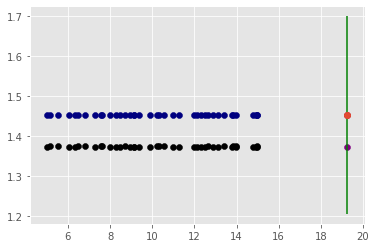

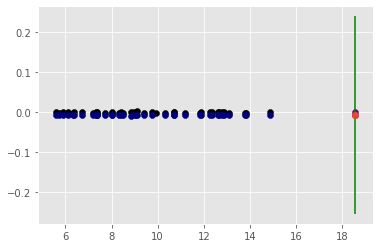

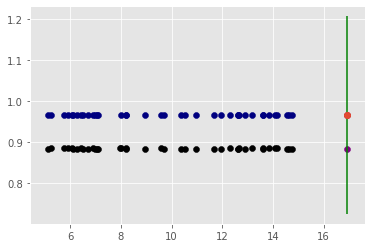

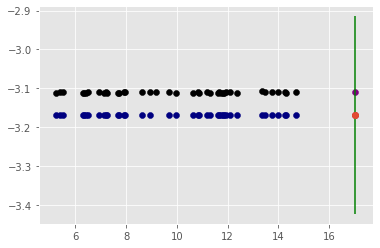

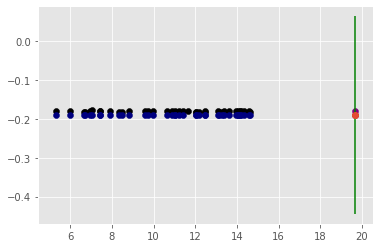

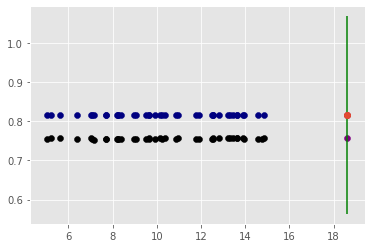

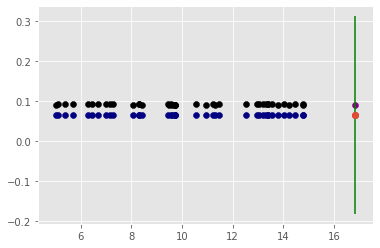

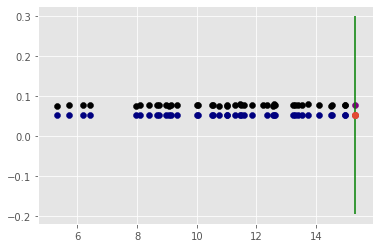

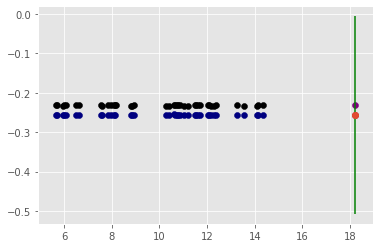

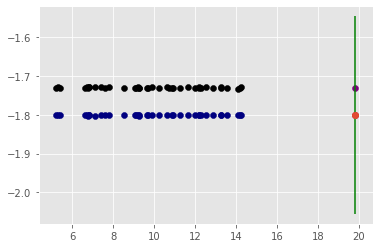

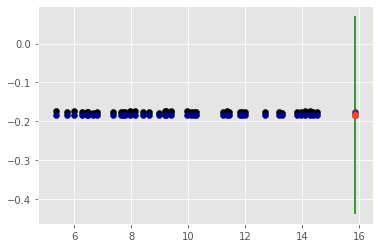

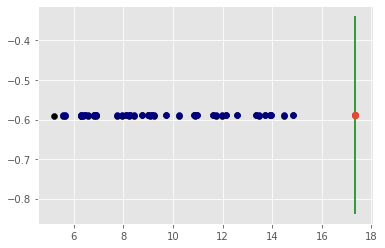

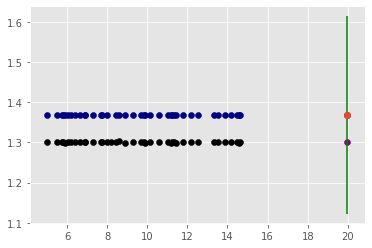

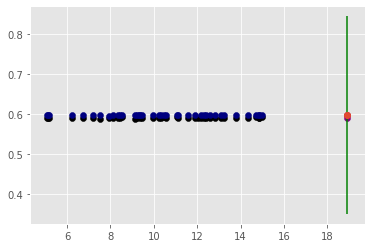

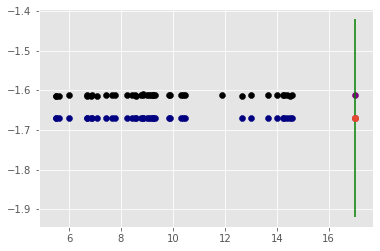

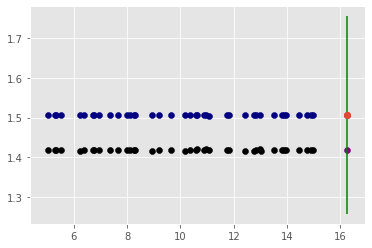

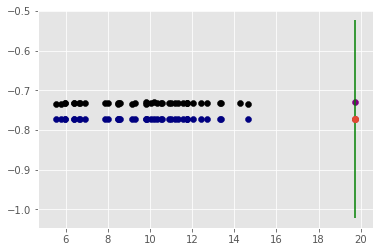

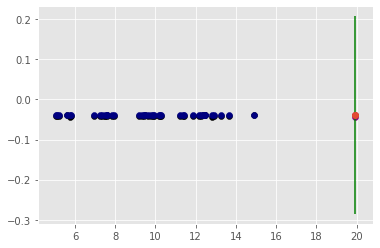

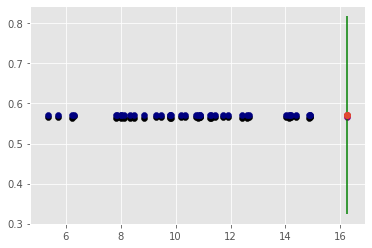

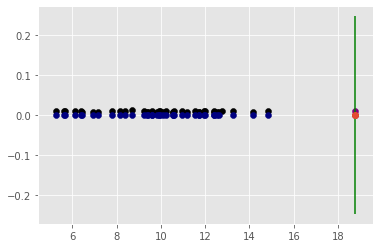

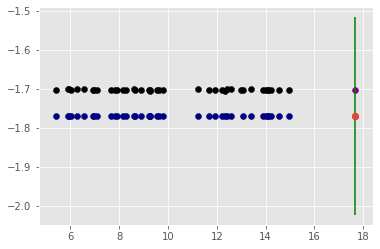

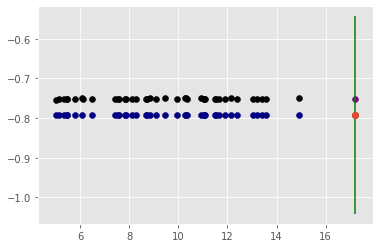

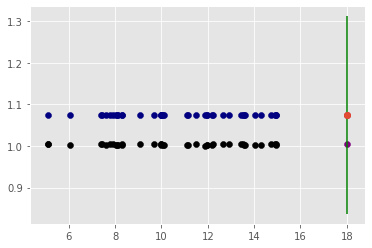

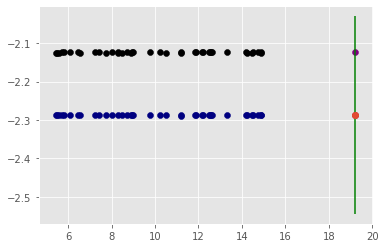

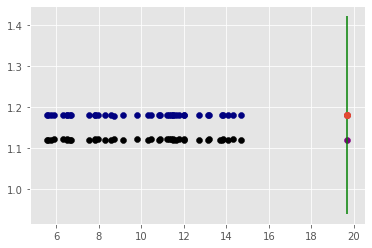

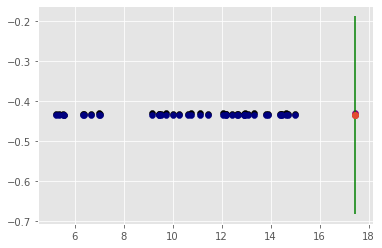

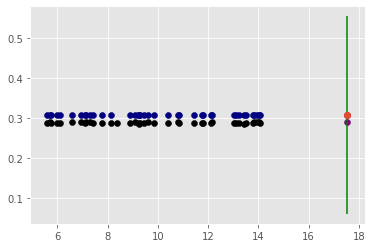

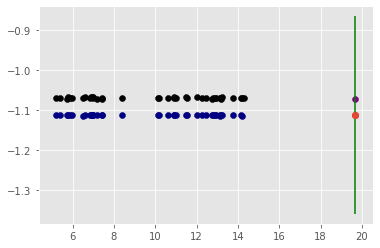

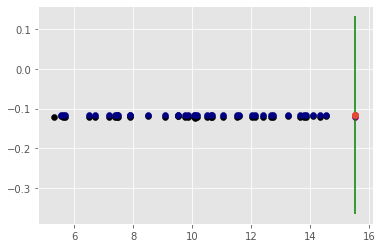

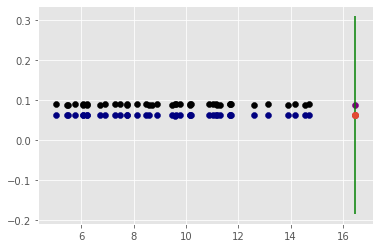

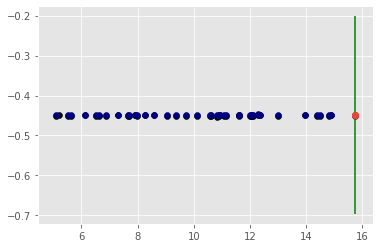

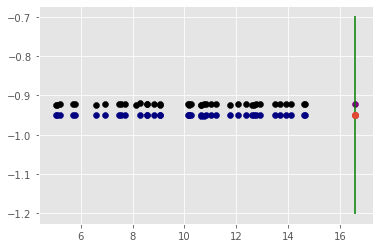

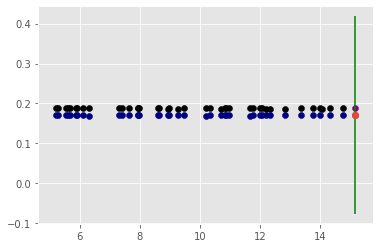

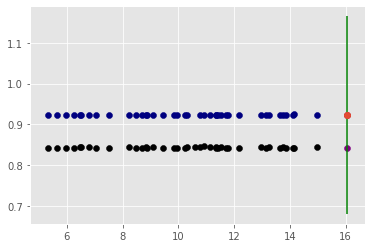

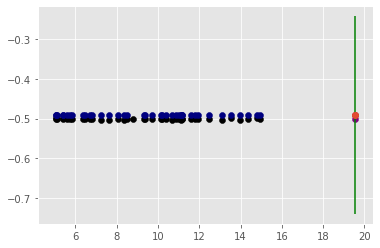

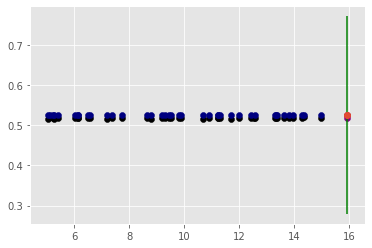

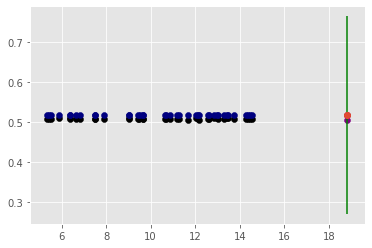

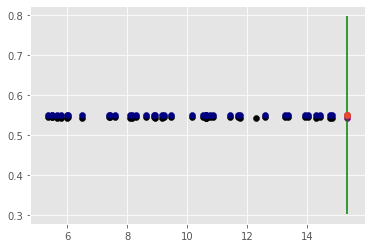

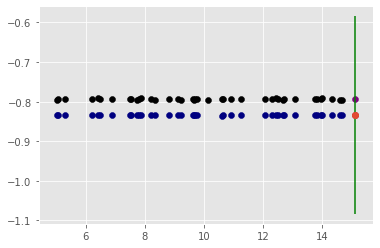

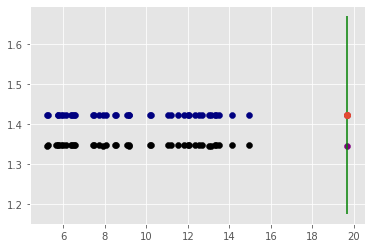

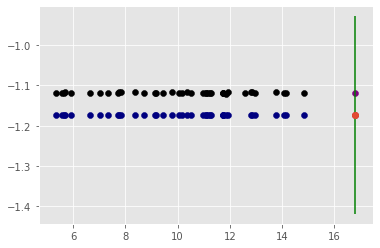

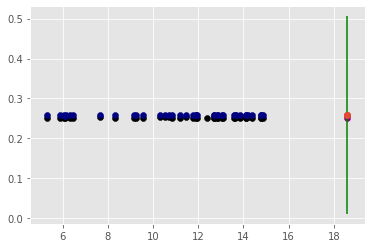

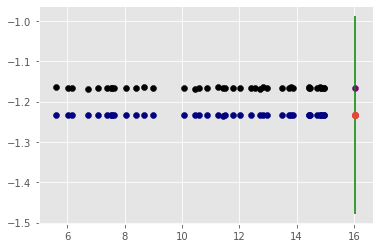

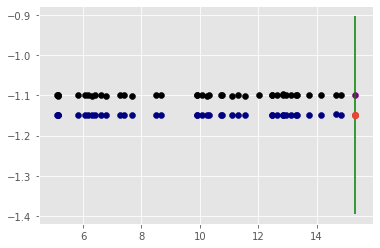

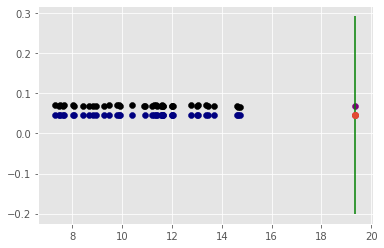

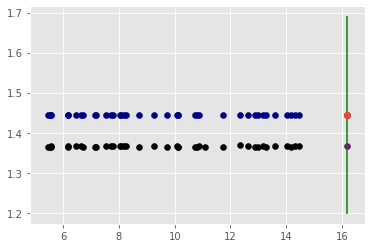

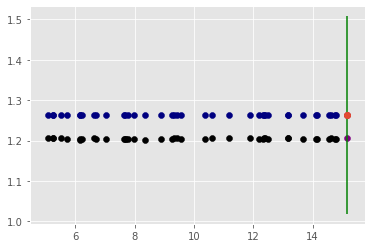

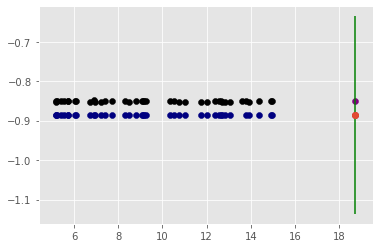

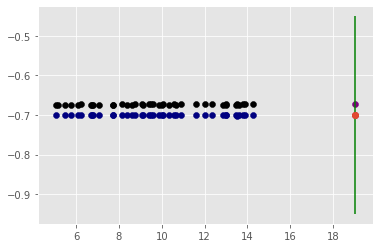

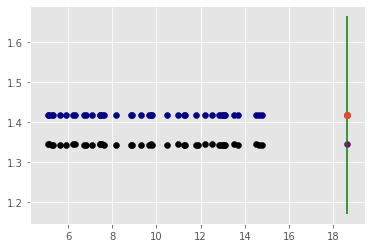

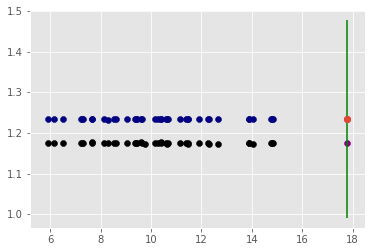

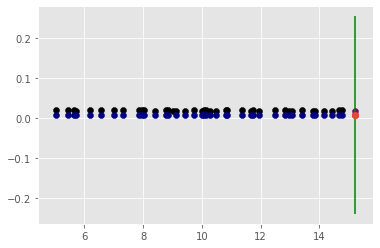

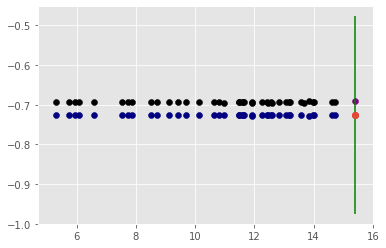

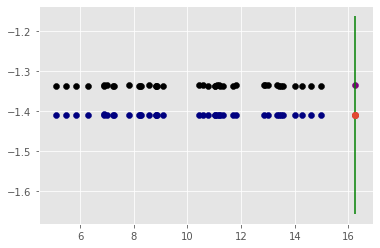

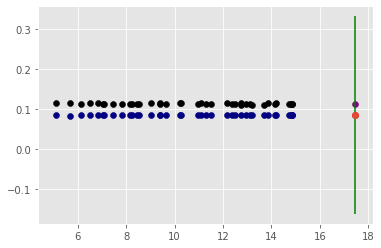

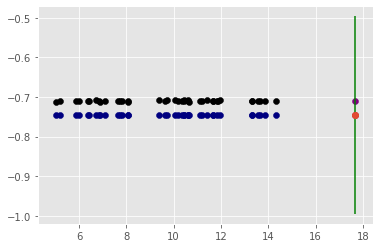

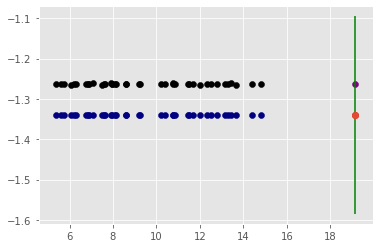

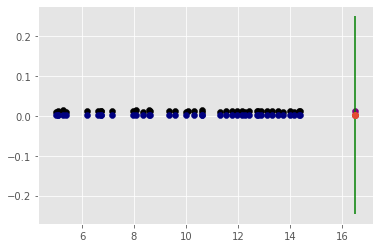

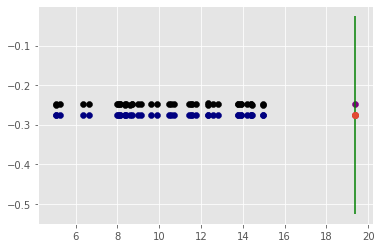

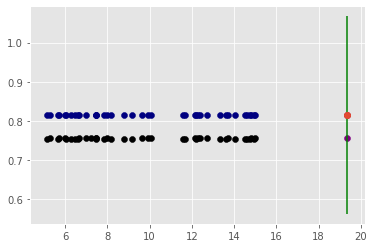

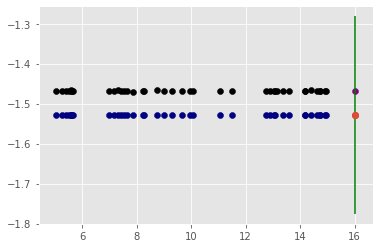

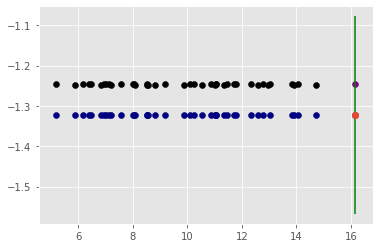

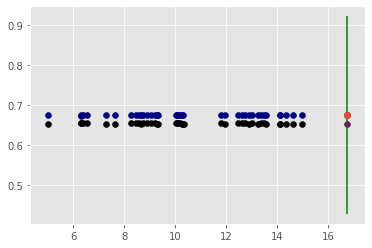

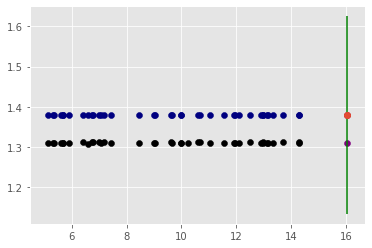

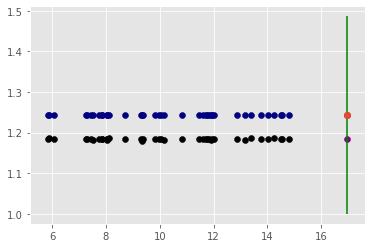

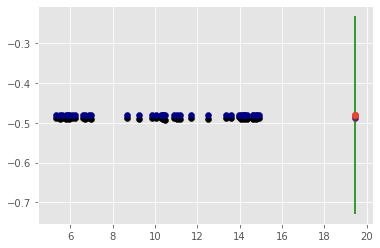

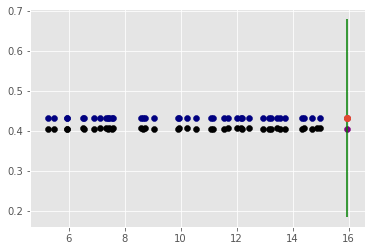

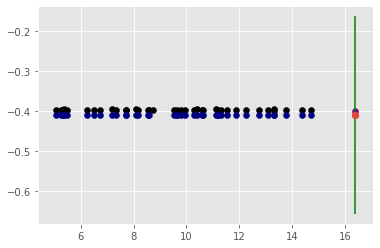

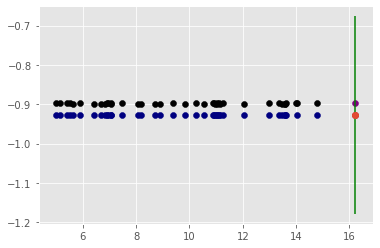

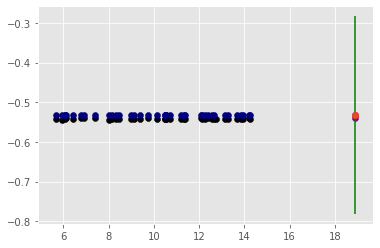

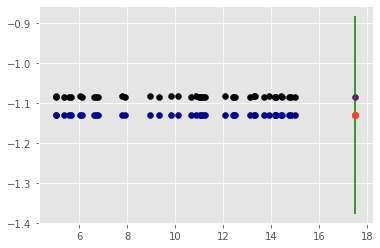

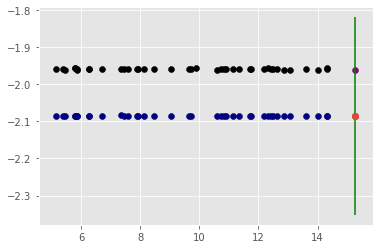

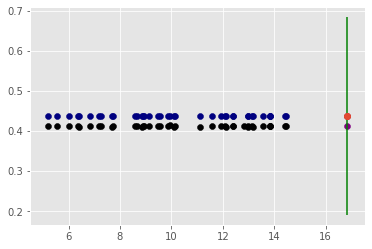

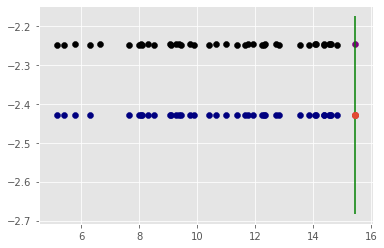

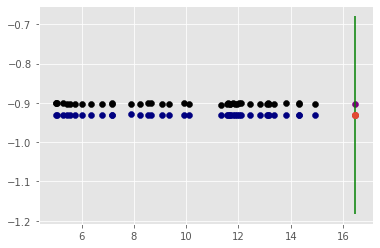

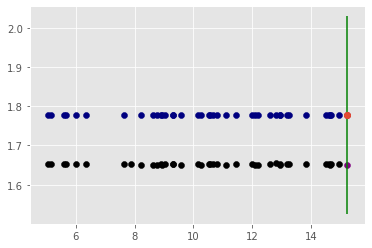

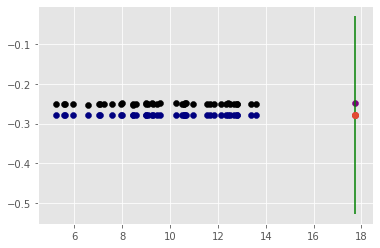

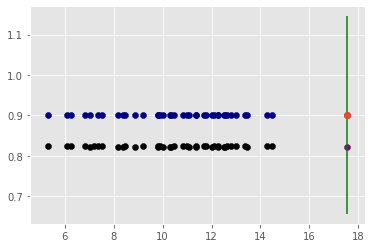

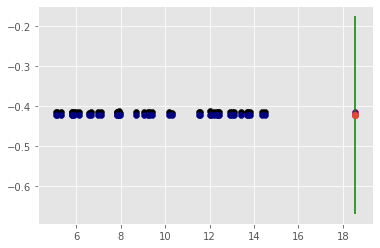

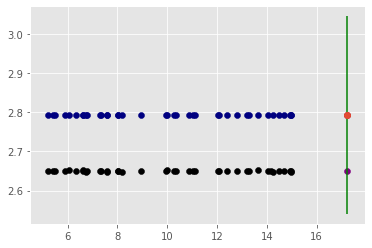

In [79]:
mse_metric = 0; r_sq_metric = 0; kuee_metric = 0;
μ = []; σ = []
m = int(x.shape[0] / 10)
y_mean = np.mean(y[:m, :40])
y_te = y[:m, 40]
for j in range(0, m):
    x_tr = x[j, :41].reshape(1, -1)
    y_tr = y[j, :40].reshape(1, -1)
    μ_te, log_σ_te = infer.inference(decoder, x_tr, y_tr)
    μ.append(μ_te[-1]); σ.append(log_σ_te[-1])
    kuee_metric += metrics.KUEE(y_te[j], μ_te[-1], np.exp(log_σ_te[-1]))
    
    plt.scatter(x_tr[:, :-1], y_tr, c = 'black')
    plt.scatter(x_tr[:, 1:], μ_te, c='navy')
    plt.scatter(x_tr[:, -1], y_te[j], c='purple')
    plt.scatter(x_tr[:, -1], μ_te[-1], c='red')
    plt.errorbar(x = x_tr[:, -1], y = (μ_te[-1]), yerr = 2 * np.exp(log_σ_te[-1]), fmt='o', ecolor='g', capthick=2)
    plt.show()
    
mse_metric = metrics.mse(y_te, μ) 
r_sq_metric = metrics.r_squared(y_te, μ, y_mean)  
mse_metric *= (1 / m)
kuee_metric *= (1 / m)

In [81]:
np.exp(σ)

array([0.12477769, 0.12743594, 0.12370509, 0.12384789, 0.12372848,
       0.12376296, 0.12434649, 0.12208057, 0.1239335 , 0.12958516,
       0.12349452, 0.12526495, 0.12470623, 0.1223371 , 0.124714  ,
       0.12741412, 0.12375392, 0.1246324 , 0.125179  , 0.12470828,
       0.12345585, 0.12332576, 0.12187957, 0.12372143, 0.11897231,
       0.1263917 , 0.11950754, 0.12105998, 0.1247896 , 0.1240009 ,
       0.12385234, 0.1230463 , 0.12504798, 0.12512717, 0.12366138,
       0.12369014, 0.12612473, 0.12414897, 0.12382482, 0.12282549,
       0.12705723, 0.12363117, 0.12332365, 0.12382693, 0.12622445,
       0.12498227, 0.13400201, 0.12532166, 0.12377212, 0.12342877,
       0.12375829, 0.12317523, 0.12374898, 0.11931612, 0.12747784,
       0.12925641, 0.12477268, 0.12235188, 0.12483289, 0.12316901,
       0.12515518, 0.11979118, 0.12364058, 0.12361548, 0.1237806 ,
       0.11915096, 0.12373736, 0.12508685, 0.12346414, 0.13347969,
       0.12358473, 0.12262102, 0.12341636, 0.12336854, 0.12378

In [51]:
kuee_metric

1.0

In [52]:
mse_metric

0.003621145028922408

In [53]:
r_sq_metric

0.9964626170065846